In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.experimental.numpy as tnp
import time,os, math
from multiprocessing import Process,Queue
from sympy import symbols, cos, sin, pi, simplify, pprint, tan, expand_trig, sqrt, trigsimp, atan2
from sympy.matrices import Matrix
import mpmath 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import time,math
import os
from numpy import linalg
import cmath
import math
from math import cos as cos
from math import sin as sin
from math import atan2 as atan2
from math import acos as acos
from math import asin as asin
from math import sqrt as sqrt
from math import pi as pi
from numpy.linalg import norm
global mat
from sklearn.metrics import mean_squared_error
from random import *
import time
from sklearn.model_selection import train_test_split
import datetime as dt

from tensorflow_graphics.geometry.transformation.quaternion import from_rotation_matrix
from tensorflow_graphics.geometry.transformation.rotation_matrix_3d import from_quaternion

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Activation,Layer
from tensorflow.keras.optimizers import Adamax,Adam, Nadam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.models import Model, load_model, save_model
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Nadam
from tqdm import tqdm

mat=np.matrix

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Limit tensorflow to only allocate x GB of memory to the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7200)])
        tf.config.experimental.set_virtual_device_configuration(
            gpus[1],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=300)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:   
        # The virtual device must be set at program startup
        print(e)

/home/irlab/anaconda3/envs/tf_py38/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


2 Physical GPUs, 2 Logical GPUs


In [3]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [2]:
os.getcwd()

'/home/irlab/juhan/IK_files/IK_DNN_class'

In [3]:
from tensorflow.keras.callbacks import Callback

# adapted from ReduceLROnPlateau
class RelativeReduceLROnPlateau(Callback):
    def __init__(self,
                 monitor='val_loss',
                 factor=0.1,
                 patience=10,
                 verbose=0,
                 alpha=0.01,
                 cooldown=0,
                 min_lr=0,
                 **kwargs):
        super(RelativeReduceLROnPlateau, self).__init__()

        self.monitor = monitor
        if factor >= 1.0:
            raise ValueError('RelativeReduceLROnPlateau ' 'does not support a factor >= 1.0.')
        self.factor = factor
        self.min_lr = min_lr
        self.alpha = alpha
        self.patience = patience
        self.verbose = verbose
        self.cooldown = cooldown
        self.cooldown_counter = 0  # Cooldown counter.
        self.wait = 0
        self.best = 0
        self.monitor_op = None
        self.mode = 'min'
        self._reset()

    def _reset(self):
        """Resets wait counter and cooldown counter.
        """
        if (self.mode == 'min' or
                (self.mode == 'auto' and 'acc' not in self.monitor)):
            self.monitor_op = lambda a, b: np.less(a, b*(1.-self.alpha))
            self.best = np.Inf
        else:
            raise Exception('Not implemented')
        self.cooldown_counter = 0
        self.wait = 0

    def on_train_begin(self, logs=None):
        self._reset()

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)
        current = logs.get(self.monitor)
        if current is None:
            pass
        else:
            if self.in_cooldown():
                self.cooldown_counter -= 1
                self.wait = 0

            if self.monitor_op(current, self.best):
                self.best = current
                self.wait = 0
            elif not self.in_cooldown():
                self.wait += 1
                if self.wait >= self.patience:
                    old_lr = float(K.get_value(self.model.optimizer.lr))
                    if old_lr > self.min_lr:
                        new_lr = old_lr*self.factor
                        new_lr = max(new_lr, self.min_lr)
                        K.set_value(self.model.optimizer.lr, new_lr)
                        if self.verbose > 0:
                            print('\nEpoch %05d: RelativeReduceLROnPlateau reducing learning '
                                  'rate to %s.'%(epoch+1, new_lr))
                        self.cooldown_counter = self.cooldown
                        self.wait = 0

    def in_cooldown(self):
        return self.cooldown_counter > 0

# adapted from EarlyStopping
class RelativeEarlyStopping(Callback):
  def __init__(self,
               monitor='val_loss',
               alpha=0.0,
               patience=0,
               earliest_epoch=0,
               verbose=0):
    super(RelativeEarlyStopping, self).__init__()
    self.monitor = monitor
    self.patience = patience
    self.verbose = verbose
    self.alpha = abs(alpha)
    self.wait = 0
    self.stopped_epoch = 0
    self.earliest_epcoh=earliest_epoch
    self.monitor_op = lambda a, b: np.less(a, b*(1.-self.alpha))


  def on_train_begin(self, logs=None):
    # Allow instances to be re-used
    self.wait = 0
    self.stopped_epoch = 0
    self.best = np.Inf

  def on_epoch_end(self, epoch, logs=None):
    current = self.get_monitor_value(logs)
    if current is None:
      return
    if self.monitor_op(current, self.best):
      self.best = current
      self.wait = 0
    else:
      self.wait += 1
      if epoch>=self.earliest_epcoh and self.wait >= self.patience:
        self.stopped_epoch = epoch
        self.model.stop_training = True

  def on_train_end(self, logs=None):
    if self.stopped_epoch > 0 and self.verbose > 0:
      print('Epoch %05d: early stopping' % (self.stopped_epoch + 1))

  def get_monitor_value(self, logs):
    logs = logs or {}
    monitor_value = logs.get(self.monitor)
    return monitor_value

class EarlyStoppingWMinEpoch(Callback):
  def __init__(self,
               monitor='val_loss',
               min_delta=0,
               patience=0,
               verbose=0,
               mode='auto',
               baseline=None,
               restore_best_weights=False,
               earliest_epoch=0):
    super(EarlyStoppingWMinEpoch, self).__init__()

    self.monitor = monitor
    self.patience = patience
    self.verbose = verbose
    self.baseline = baseline
    self.min_delta = abs(min_delta)
    self.wait = 0
    self.stopped_epoch = 0
    self.restore_best_weights = restore_best_weights
    self.best_weights = None
    self.earliest_epoch = earliest_epoch

    if mode not in ['auto', 'min', 'max']:
      mode = 'auto'

    if mode == 'min':
      self.monitor_op = np.less
    elif mode == 'max':
      self.monitor_op = np.greater
    else:
      if 'acc' in self.monitor:
        self.monitor_op = np.greater
      else:
        self.monitor_op = np.less

    if self.monitor_op == np.greater:
      self.min_delta *= 1
    else:
      self.min_delta *= -1

  def on_train_begin(self, logs=None):
    # Allow instances to be re-used
    self.wait = 0
    self.stopped_epoch = 0
    if self.baseline is not None:
      self.best = self.baseline
    else:
      self.best = np.Inf if self.monitor_op == np.less else -np.Inf
    self.best_weights = None

  def on_epoch_end(self, epoch, logs=None):
    current = self.get_monitor_value(logs)
    if current is None:
      return
    if self.monitor_op(current - self.min_delta, self.best):
      self.best = current
      self.wait = 0
      if self.restore_best_weights:
        self.best_weights = self.model.get_weights()
    else:
      self.wait += 1
      if epoch>=self.earliest_epoch and self.wait >= self.patience:
        self.stopped_epoch = epoch
        self.model.stop_training = True
        if self.restore_best_weights:
          if self.verbose > 0:
            print('Restoring model weights from the end of the best epoch.')
          self.model.set_weights(self.best_weights)

  def on_train_end(self, logs=None):
    if self.stopped_epoch > 0 and self.verbose > 0:
      print('Epoch %05d: early stopping' % (self.stopped_epoch + 1))

  def get_monitor_value(self, logs):
    logs = logs or {}
    monitor_value = logs.get(self.monitor)
    return monitor_value


In [4]:
class UR3_DNN:
    def __init__(self,bs):
        self.batch_size = bs

        self.d1 = 0.1519 # unit : [m]
        self.a2 = -0.24365
        self.a3 = -0.213258
        self.d4 = 0.11235
        self.d5 = 0.08535
        self.d6 = 0.0819
        
        self.d = mat([0.1519, 0,0 ,0.11235,0.08535,0.0819]) #ur3 m
        self.a =mat([0 ,-0.24365 ,-0.21325 ,0 ,0 ,0]) #ur3 cm
        self.alpha = mat([pi/2, 0, 0, pi/2, -pi/2, 0 ]) # ur3 rad
        
        self.position_data = np.array([[0,0,0,0,0,0,0]])  #  input data :  x,y,z,a,b,g,conf
        self.th_data = np.array([[0,0,0,0,0,0]])          #  output data : th1~th6
        self.th_sample = np.array([[0,0,0,0,0,0]])          #  output data : th1~th6
        self.position_sample= np.array([[0.,0.,0.,0.,0.,0.]], dtype='float32')

        self.identity_flattened = tf.repeat(tf.reshape(tf.eye(4), (1, 16)), self.batch_size, 0) 
        
        self.zeros = tf.repeat(tf.reshape(0., (1)), self.batch_size, 0) 
        self.ones = tf.repeat(tf.reshape(1., (1)), self.batch_size, 0) 
        self.pi_2 = tf.repeat(tf.reshape(pi/2, (1)), self.batch_size, 0) 
        
        self.d1_batch = tf.repeat([self.d1], self.batch_size,0)
        self.a2_batch = tf.repeat([self.a2], self.batch_size,0)
        self.a3_batch = tf.repeat([self.a3], self.batch_size,0)
        self.d4_batch = tf.repeat([self.d4], self.batch_size,0)
        self.d5_batch = tf.repeat([self.d5], self.batch_size,0)
        self.d6_batch = tf.repeat([self.d6], self.batch_size,0)
        
        self.d_ = [self.d1_batch, self.zeros,self.zeros ,self.d4_batch,self.d5_batch,self.d6_batch] #ur3 m
        self.a_ =[self.zeros ,self.a2_batch ,self.a3_batch ,self.zeros ,self.zeros ,self.zeros] #ur3 cm
        self.alpha_ = [self.pi_2, self.zeros, self.zeros, self.pi_2, -self.pi_2, self.zeros] # ur3 rad
        
    def RMSE(self,a,b):
        return mean_squared_error(a,b)**0.5

    # ***************************** FORWARD KINEMATICS
    def AH(self, n,th,c  ):

        T_a = mat(np.identity(4), copy=False)
        T_a[0,3] = self.a[0,n-1]
        T_d = mat(np.identity(4), copy=False)
        T_d[2,3] = self.d[0,n-1]

        Rzt = mat([[cos(th[n-1,c]), -sin(th[n-1,c]), 0 ,0],
                [sin(th[n-1,c]),  cos(th[n-1,c]), 0, 0],
                [0,               0,              1, 0],
                [0,               0,              0, 1]],copy=False)


        Rxa = mat([[1, 0,                 0,                  0],
                 [0, cos(self.alpha[0,n-1]), -sin(self.alpha[0,n-1]),   0],
                 [0, sin(self.alpha[0,n-1]),  cos(self.alpha[0,n-1]),   0],
                 [0, 0,                 0,                  1]],copy=False)

        A_i = T_d * Rzt * T_a * Rxa
        return A_i
    
    
    def HTrans(self,th,c ):  
        A_1=self.AH( 1,th,c  )
        A_2=self.AH( 2,th,c  )
        A_3=self.AH( 3,th,c  )
        A_4=self.AH( 4,th,c  )
        A_5=self.AH( 5,th,c  )
        A_6=self.AH( 6,th,c  )
      
        T_06=A_1*A_2*A_3*A_4*A_5*A_6

        return T_06
    #####################################################################################
    #tensor로 들어가도록 구현, error 구하고 array size가 [:,6] 형태로 들어가게함
    
    #tf 가능한 정기구학 gkat함수구현
    def AH_tf(self,n,th):   

        s_t = tf.sin(th[:,n-1])
        c_t = tf.cos(th[:,n-1])
        
        s_a = tf.sin(self.alpha_[n-1])
        c_a = tf.cos(self.alpha_[n-1])
        
        s_t = tf.cast(s_t,tf.float32)
        c_t = tf.cast(c_t,tf.float32)

        #A_i = [c_t, -c_a*s_t, s_a*s_t,l*c_t,
        #      s_t, c_a*c_t, -s_a*c_t, l*s_t,
        #      0, s_a, c_a, d
        #      0, 0, 0, 1]
        A_ = [c_t, -c_a*s_t, s_a*s_t, self.a_[n-1]*c_t,
              s_t, c_a*c_t, -s_a*c_t, self.a_[n-1]*s_t,
              self.zeros, s_a, c_a, self.d_[n-1],
              self.zeros,self.zeros,self.zeros,self.ones]
        A_ = tf.reshape(tf.stack(A_, axis=1), (self.batch_size, 4, 4))
        return A_

    def HTrans_tf(self,th ):  
        self.identity_flattened = tf.repeat(tf.reshape(tf.eye(4), (1, 16)), self.batch_size, 0) 
        
        self.zeros = tf.repeat(tf.reshape(0., (1)), self.batch_size, 0) 
        self.ones = tf.repeat(tf.reshape(1., (1)), self.batch_size, 0) 
        self.pi_2 = tf.repeat(tf.reshape(pi/2, (1)), self.batch_size, 0) 
        
        self.d1_batch = tf.repeat([self.d1], self.batch_size,0)
        self.a2_batch = tf.repeat([self.a2], self.batch_size,0)
        self.a3_batch = tf.repeat([self.a3], self.batch_size,0)
        self.d4_batch = tf.repeat([self.d4], self.batch_size,0)
        self.d5_batch = tf.repeat([self.d5], self.batch_size,0)
        self.d6_batch = tf.repeat([self.d6], self.batch_size,0)
        
        self.d_ = [self.d1_batch, self.zeros,self.zeros ,self.d4_batch,self.d5_batch,self.d6_batch] #ur3 m
        self.a_ =[self.zeros ,self.a2_batch ,self.a3_batch ,self.zeros ,self.zeros ,self.zeros] #ur3 cm
        self.alpha_ = [self.pi_2, self.zeros, self.zeros, self.pi_2, -self.pi_2, self.zeros] # ur3 rad
        
        #th= tf.convert_to_tensor(th)
        #th= tf.transpose(th)
        A_1=self.AH_tf( 1,th )
        A_2=self.AH_tf( 2,th )
        A_3=self.AH_tf( 3,th )
        A_4=self.AH_tf( 4,th )
        A_5=self.AH_tf( 5,th )
        A_6=self.AH_tf( 6,th )
    
        A_ = tf.matmul(A_1,A_2)
        A_ = tf.matmul(A_,A_3)
        A_ = tf.matmul(A_,A_4)
        A_ = tf.matmul(A_,A_5)
        A_ = tf.matmul(A_,A_6)

        return A_
    # ************************************************** INVERSE KINEMATICS 
    def invKine(self,desired_pos):# T60
        th = mat(np.zeros((6, 8)))
        conf = mat(np.zeros((3,8)))
        P_05 = (desired_pos * mat([0,0, -self.d6, 1]).T-mat([0,0,0,1 ]).T)
  
        # **** theta1 ****
  
        psi = atan2(P_05[2-1,0], P_05[1-1,0])
    
        phi = acos(self.d4 /sqrt(P_05[2-1,0]*P_05[2-1,0] + P_05[1-1,0]*P_05[1-1,0]))
        #The two solutions for theta1 correspond to the shoulder
        #being either left or right
        th[0, 0:4] = pi/2 + psi + phi
        th[0, 4:8] = pi/2 + psi - phi
        th = th.real
  
        # **** theta5 ****
  
        cl = [0, 4]# wrist up or down
        for i in range(0,len(cl)):
            c = cl[i]
            T_10 = linalg.inv(self.AH(1,th,c))
            T_16 = T_10 * desired_pos

            th[4, c:c+2] = acos((T_16[2,3]-self.d4)/self.d6)
            th[4, c+2:c+4] = -acos((T_16[2,3]-self.d4)/self.d6)
            
        
        th = th.real
        
        # **** theta6 ****
        # theta6 is not well-defined when sin(theta5) = 0 or when T16(1,3), T16(2,3) = 0.

        cl = [0, 2, 4, 6]
        for i in range(0,len(cl)):
            c = cl[i]
            T_10 = linalg.inv(self.AH(1,th,c))
            T_16 = linalg.inv( T_10 * desired_pos )
            th[5, c:c+2] = atan2((-T_16[1,2]/sin(th[4, c])),(T_16[0,2]/sin(th[4, c])))
  
        th = th.real

        # **** theta3 ****
        cl = [0, 2, 4, 6]
        for i in range(0,len(cl)):
	        c = cl[i]
	        T_10 = linalg.inv(self.AH(1,th,c))
	        T_65 = self.AH( 6,th,c)
	        T_54 = self.AH( 5,th,c)
	        T_14 = ( T_10 * desired_pos) * linalg.inv(T_54 * T_65)
	        P_13 = T_14 * mat([0, -self.d4, 0, 1]).T - mat([0,0,0,1]).T
	        t3 = cmath.acos((linalg.norm(P_13)**2 - self.a2**2 - self.a3**2 )/(2 * self.a2 * self.a3)) # norm ?
	        th[2, c] = t3.real
	        th[2, c+1] = -t3.real

        # **** theta2 and theta 4 ****

        cl = [0, 1, 2, 3, 4, 5, 6, 7]
        for i in range(0,len(cl)):
	        c = cl[i]
	        T_10 = linalg.inv(self.AH( 1,th,c ))
	        T_65 = linalg.inv(self.AH( 6,th,c))
	        T_54 = linalg.inv(self.AH( 5,th,c))
	        T_14 = (T_10 * desired_pos) * T_65 * T_54
	        P_13 = T_14 * mat([0, -self.d4, 0, 1]).T - mat([0,0,0,1]).T
	      
	        # theta 2
	        th[1, c] = -atan2(P_13[1], -P_13[0]) + asin(self.a3* sin(th[2,c])/linalg.norm(P_13))
	        # theta 4
	        T_32 = linalg.inv(self.AH( 3,th,c))
	        T_21 = linalg.inv(self.AH( 2,th,c))
	        T_34 = T_32 * T_21 * T_14
	        th[3, c] = atan2(T_34[1,0], T_34[0,0])
        th = th.real
        return th

    def cos_sim(self,A, B):   # Check for similarity
        return np.dot(A, B)/(norm(A)*norm(B))
    
    def get_pos(self,p):
        # p : position 1x6 array
        a= round(p[3],5)
        b=round(p[4],5)
        g=round(p[5],5)
        x_=round(p[0],5)
        y_=round(p[1],5)
        z_=round(p[2],5)
        return mat([[cos(a)*cos(b)*cos(g) - sin(a)*sin(g) ,-cos(a)*sin(b),cos(g)*sin(a) + cos(a)*cos(b)*sin(g),x_],
                    [cos(g)*sin(b),                          cos(b),        sin(b)*sin(g),                       y_],
                    [-cos(a)*sin(g) - cos(b)*cos(g)*sin(a),sin(a)*sin(b), cos(a)*cos(g) - cos(b)*sin(a)*sin(g), z_],
                    [0,0,0,1]])
    
    def get_position(self,p):
        # p : N x 4 x 4  tensor
        x = p[:,0,3]
        y = p[:,1,3]
        z = p[:,2,3]
        
        cos = p[:,1,1]
        
        sin = tf.sqrt(1-tf.math.square(cos))
        b = tf.where(p[:,1,1]>=0, tf.math.atan2(sin,cos), tf.math.atan2(-sin,cos))
        a = tf.atan2(p[:,2,1],-p[:,0,1])
        g = tf.atan2(p[:,1,2],p[:,1,0])
        
        pos_ = np.array([x,y,z,a,b,g])
        pos_= pos_.T
        pos_ = tf.convert_to_tensor(
            pos_, dtype=None, dtype_hint=None, name=None
        )
    
    def data_sample(self,n):
        inv_th1 = 0
        data_cnt = 0
        pass_cnt = 0 
        t = time.time()
        position_sample = np.array([[0,0,0,0,0,0,0]])  #  input data :  x,y,z,a,b,g,conf
        th_sample = np.array([[0,0,0,0,0,0]])          #  output data : th1~th6
        
        with tqdm(total= n) as pbar:
            while (data_cnt<=n):
                x = uniform(-50.,50.)
                y = uniform(-50.,50.)    
                z = uniform(-50.,50.)
                alpha_ = uniform(-math.pi,math.pi)
                beta_ = uniform(-math.pi,math.pi)
                gamma_ = uniform(-math.pi,math.pi)
                r = sqrt(x**2+y**2+z**2)
                if r<0.5 and r>0.2:
                    pos = [x,y,z,alpha_,beta_,gamma_]
                    pos_1=self.get_pos(pos)
                    try:
                        inv_th1 = self.invKine(pos_1)
                    except:
                        pass
                    inv_pos1_2 = self.HTrans(inv_th1,0) 
                    error = round(self.RMSE(pos_1.tolist(),inv_pos1_2.tolist()),6)
                    if (2e-04 >=error):
                        data_cnt += 1

                        is_there_minus = inv_th1[0,:] < 0 
                        is_there_plus = inv_th1[0,:] > 0 

                        # if th1 is all negative; Check for amniotic fluid If yes ? pass, correct if not
                        if not(True in is_there_plus):
                            min_th1 = min(inv_th1[0,0],inv_th1[0,4])
                            if inv_th1[0,0]==min_th1:
                                inv_th1[0,:4] += 2*math.pi 
                            else:
                                inv_th1[0,4:] += 2*math.pi 

                        # if th1 is all positive; Check for negative numbers If yes ? pass, correct if not
                        if not(True in is_there_minus):
                            max_th1 = max(inv_th1[0,0],inv_th1[0,4])
                            if inv_th1[0,0]==max_th1:
                                inv_th1[0,:4] -= 2*math.pi 
                            else:
                                inv_th1[0,4:] -= 2*math.pi 

#                         pos_conf = np.hstack([pos,0])
                        #pos_conf[3:6]*=10
                        for i in range(8):
#                             conf = 0
                            th_tem = inv_th1[:,i].T
                            th_tem = th_tem.tolist()[0]
#                             if th_tem[2] == 0:
#                                 continue
#                             if (th_tem[0] >= 0 and th_tem[2] >= 0 and th_tem[4] >= 0):
#                                 conf = 80
#                             elif (th_tem[0] >= 0 and th_tem[2] >= 0 and th_tem[4] < 0):
#                                 conf = 70
#                             elif (th_tem[0] >= 0 and th_tem[2] < 0 and th_tem[4] >= 0):
#                                 conf = 60
#                             elif (th_tem[0] >= 0 and th_tem[2] < 0 and th_tem[4] < 0):
#                                 conf = 50
#                             elif (th_tem[0] < 0 and th_tem[2] >= 0 and th_tem[4] >= 0):
#                                 conf = 40
#                             elif (th_tem[0] < 0 and th_tem[2] >= 0 and th_tem[4] < 0):
#                                 conf = 30
#                             elif (th_tem[0] < 0 and th_tem[2] < 0 and th_tem[4] >= 0):
#                                 conf = 20
#                             elif (th_tem[0] < 0 and th_tem[2] < 0 and th_tem[4] < 0):
#                                 conf = 10
#                             pos_conf[6] = conf
#                             position_sample = np.vstack([position_sample,pos_conf])
                            th_sample = np.vstack([th_sample,th_tem])
                        pass_cnt += 1
                        pbar.update(1)
                    else:
                        pass
                else:        
                    continue
#         self.position_data = np.vstack([self.position_data,position_sample[1:]])
        self.th_data = np.vstack([self.th_data,th_sample[1:]])
        for i in range(2):
            self.th_data[:,i] = np.where(self.th_data[:,i]>pi, self.th_data[:,i]-2*pi , self.th_data[:,i])
            self.th_data[:,i] = np.where(self.th_data[:,i]<-pi, self.th_data[:,i]+2*pi , self.th_data[:,i])
        
        #self.th_data = np.where(self.th_data<0, self.th_data+2*pi , self.th_data)
        #self.position_data[:,3:6] = np.where(self.position_data[:,3:6]<0,self.position_data[:,3:6] + 2*pi, self.position_data[:,3:6])
        print("time : ",time.time()-t)
        print("pass : ",pass_cnt)
        print("data : ",data_cnt)
        
    def data_sample_ths(self,n):
        inv_th1 = 0
        data_cnt = 0
        pass_cnt = 0 
        t = time.time()
        sample = np.array([[0.,0.,0.,0.,0.,0.]], dtype='float32')
        with tqdm(total= n) as pbar:
            while(data_cnt < n):
                th1 = uniform(-math.pi,math.pi)
                th2 = uniform(-math.pi,math.pi)
                th3 = uniform(-math.pi,math.pi)
                th4 = uniform(-math.pi,math.pi)
                th5 = uniform(-math.pi,math.pi)
                th6 = uniform(-math.pi,math.pi)
                th = [th1,th2,th3,th4,th5,th6]

                sample = np.vstack([sample,th])
                pbar.update(1)
                data_cnt += 1
        self.th_sample = np.vstack([sample[1:],self.th_sample[1:]])
        
        
        
        
        print("time : ",time.time()-t)
        print("pass : ",pass_cnt)
        print("data : ",data_cnt)
    
    
    def get_pos_data(self,mat,ths):
        # mat : N x 4 x 4  Tensor Pos
        # ths : N x 6    th1~6
        pos_ = mat[:,:3,3]
        
        quat_ = from_rotation_matrix(mat[:,:3,:3])
        
        conf= mat[:,0,0]
        
        print(pos_.shape)
        conf = conf.numpy()
        ths = ths.numpy()
        conf[np.where((ths[:,0]>=0) & (ths[:,2]>=0) & (ths[:,4]>=0))] = 80
        conf[np.where((ths[:,0]>=0) & (ths[:,2]>=0) & (ths[:,4]<0))] = 70
        conf[np.where((ths[:,0]>=0) & (ths[:,2]<0) & (ths[:,4]>=0))] = 60
        conf[np.where((ths[:,0]>=0) & (ths[:,2]<0) & (ths[:,4]<0))] = 50
        conf[np.where((ths[:,0]<0) & (ths[:,2]>=0) & (ths[:,4]>=0))] = 40
        conf[np.where((ths[:,0]<0) & (ths[:,2]>=0) & (ths[:,4]<0))] = 30
        conf[np.where((ths[:,0]<0) & (ths[:,2]<0) & (ths[:,4]>=0))] = 20
        conf[np.where((ths[:,0]<0) & (ths[:,2]<0) & (ths[:,4]<0))] = 10
        
        conf= tf.convert_to_tensor([conf])
        conf = tf.transpose(conf)

        return tf.experimental.numpy.hstack([pos_,quat_,conf])
        
        
        
    
    def get_position(self,p,output_):
        # N x 4 x 4   Tensor pos
        # N x 6  Tensor ths
        x = p[:,0,3]
        y = p[:,1,3]
        z = p[:,2,3]
        
        #cos = p[:,1,1]
        
        #sin = tf.sqrt(1-tf.math.square(cos))
        b = tf.acos(p[:,1,1])
        a = tf.atan2(p[:,2,1]/tf.math.sin(b),-p[:,0,1]/tf.math.sin(b))
        g = tf.atan2(p[:,1,2]/tf.math.sin(b),p[:,1,0]/tf.math.sin(b))
        
        conf= x
        
        conf = conf.numpy()
        
        output = output_.numpy()
        
        conf[np.where((output[:,0]>=0) & (output[:,2]>=0) & (output[:,4]>=0))] = 80
        conf[np.where((output[:,0]>=0) & (output[:,2]>=0) & (output[:,4]<0))] = 70
        conf[np.where((output[:,0]>=0) & (output[:,2]<0) & (output[:,4]>=0))] = 60
        conf[np.where((output[:,0]>=0) & (output[:,2]<0) & (output[:,4]<0))] = 50
        conf[np.where((output[:,0]<0) & (output[:,2]>=0) & (output[:,4]>=0))] = 40
        conf[np.where((output[:,0]<0) & (output[:,2]>=0) & (output[:,4]<0))] = 30
        conf[np.where((output[:,0]<0) & (output[:,2]<0) & (output[:,4]>=0))] = 20
        conf[np.where((output[:,0]<0) & (output[:,2]<0) & (output[:,4]<0))] = 10
        
        pos_ = np.array([x,y,z,a,b,g,conf])
        pos_= pos_.T
        pos_ = tf.convert_to_tensor(
            pos_, dtype=None, dtype_hint=None, name=None
        )

        
        return pos_

    def data_split(self,data_y,data):
        x_train, x_test, y_train, y_test = train_test_split(data_y, data, test_size=0.2, shuffle=True)#데이터셋 전처리
        x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.5, shuffle=True)#데이터셋 전처리
        return x_train,y_train,x_test,y_test,x_valid,y_valid


    def filter_data(self,ths,pos):
        
        r = tf.math.sqrt(tf.square(robot.position_data[:,0])+tf.square(robot.position_data[:,1])+tf.square(robot.position_data[:,2]))
        r = r.numpy()
        
        ths = ths.numpy()
        pos = pos.numpy()

        
        
        pos = pos[np.where((r<0.5) & (r>0.2) )]
        ths = ths[np.where((r<0.5) & (r>0.2) )]
        
        ths = ths[np.where(pos[:,2]>0)]
        pos = pos[np.where(pos[:,2]>0)]

        #ths = np.where(ths<0, ths+2*pi , ths)
        
        #for i in range(3,6):
        #    pos[:,i] = np.where(pos[:,i]<0,pos[:,i] + 2*pi, pos[:,i])
        
        ths= tf.convert_to_tensor(ths)
        pos= tf.convert_to_tensor(pos)


        return ths,pos
 

In [47]:
       
class DNN_model(Model):
    def __init__(self,num_layers, num_node,activation=0,initializer=0,batch_size=500):
        super(DNN_model, self).__init__()
        self.num_layers = num_layers
        self.num_node = num_node
        self.batch_size = batch_size
        self.input_size = 8
        self.output_size = 6
        
        activation_name = ['mish','lisht', 'relu', 'tanh'][activation]
        activation = [tfa.activations.mish, tfa.activations.lisht, tf.nn.relu, tf.nn.tanh][activation]
        initializer_name = ['random_normal','he_normal','orthogonal','Glorot'][initializer]
        initializer = [tf.keras.initializers.RandomNormal(), tf.keras.initializers.HeNormal(), tf.keras.initializers.Orthogonal(), tf.keras.initializers.GlorotNormal()][initializer] 
        
        self.activation = activation
        self.initializer = initializer
        
        x = dt.datetime.now()
        date = 'd{}_{}_{}'.format(x.year,x.month,x.day)

        self.model_name = 'DNN_IK_{num_layer}_{num_node}_{activ}_{initial}_{bs}'.format(num_layer = num_layers,num_node = num_node, activ = activation_name,initial=initializer_name,bs =self.batch_size) 
        #self.model_name = self.model_name+ '_adamw'
        self.model_name = self.model_name 
        
        self.log_dir = "logs/" + self.model_name + '_' + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
        self.tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=self.log_dir)
        
        self.val_loss_name = os.path.join('checkpoint', self.model_name,'val_loss',"{name}_loss.h5".format(name=self.model_name))
        self.val_loss_name_fast = os.path.join('checkpoint', self.model_name,'val_loss',"{name}_fast_loss.h5".format(name=self.model_name))

        self.val_1mm_name = os.path.join('checkpoint', self.model_name,'val_1mm_above',"{name}_1mm.h5".format(name=self.model_name))
        self.val_1cm_name = os.path.join('checkpoint', self.model_name,'val_1cm_above',"{name}_1cm.h5".format(name=self.model_name))

        self.val_loss_chkpt = tf.keras.callbacks.ModelCheckpoint(self.val_loss_name,
                                                                monitor='val_loss', save_best_only=True, verbose=False)
        self.val_loss_fast_chkpt = tf.keras.callbacks.ModelCheckpoint(self.val_loss_name_fast,
                                                                monitor='val_loss', save_best_only=True, verbose=False)
        self.val_1cm_chkpt = tf.keras.callbacks.ModelCheckpoint(self.val_1cm_name,
                                                               monitor='val_fk_above_1cm_dist', save_best_only=True, verbose=False)
        self.val_1mm_chkpt = tf.keras.callbacks.ModelCheckpoint(self.val_1mm_name,
                                                               monitor='val_fk_above_1mm_dist', save_best_only=True, verbose=False)
        
        self.lr_init = 1e-2
        self.lr_callback = tf.keras.callbacks.LearningRateScheduler(self.scheduler)
        ### Optimizer ###
        self.opt = tf.keras.optimizers.Nadam(learning_rate=self.lr_init)
        self.wd = 1e-4
        self.early_stopping =EarlyStoppingWMinEpoch(monitor='val_fk_mean_dist', min_delta=0.05, patience=110, mode='min', earliest_epoch=750)
    
    
    def make_model(self):
        self.lr_callback = tf.keras.callbacks.LearningRateScheduler(self.scheduler)
        input_= Input(shape=self.input_size)
        A = input_
        for i in range(self.num_layers):
            A = Dense(self.num_node, name='layer{}'.format(i+1), kernel_initializer = self.initializer)(A)
            A = self.activation(A)
            A = tf.keras.layers.BatchNormalization()(A)
        
        output_ = Dense(self.output_size, activation='linear', name='Outputs')(A)

        self.model = Model(inputs= input_ , outputs = output_)
        self.model.summary()
        
    def make_model_2(self):
        self.lr_callback = tf.keras.callbacks.LearningRateScheduler(self.scheduler)
        #input_= Input(shape=self.input_size)
        inputA = Input(shape=self.input_size, name='Input states')

        A = Dense(self.num_node,  name='layer1',kernel_initializer = 'he_normal')(inputA)
        A = self.activation(A)
        A = tf.keras.layers.BatchNormalization()(A)

        for i in range(2,19):
            A = Dense(self.num_node,  name='layer{}'.format(i),kernel_initializer = self.initializer)(A)
            A = self.activation(A)
            A = tf.keras.layers.BatchNormalization()(A)

        A = Dense(int(self.num_node/2),  name='layer{}'.format(i+1),kernel_initializer = self.initializer)(A)
        A = self.activation(A)
        A = tf.keras.layers.BatchNormalization()(A)

        A = Dense(int(self.num_node/4),  name='layer{}'.format(i+2),kernel_initializer = self.initializer)(A)
        A = self.activation(A)
        A = tf.keras.layers.BatchNormalization()(A)
        outputs = Dense(self.output_size, activation='linear', name='Outputs')(A)

        model = Model(inputs= inputA , outputs = outputs)
        model.summary()
    def get_weight_set_weight(self,name):
        trained_model = tf.keras.models.load_model(name,compile = False)
        a = trained_model.get_weights()
        self.model.set_weights(a)
    

    def scheduler(self,epoch, lr):
        lr_ = lr*tf.math.exp(-0.1*epoch/50000)
        self.wd = lr_*1e-2
        print(lr_)
        
        if lr_> 1e-5:
            return lr_
        else:
            return 1e-5
        

    def fk_mean_dist(self,ans,pred):
        pred *= (2*pi)
        ans *= (2*pi)
        
        pred = tf.convert_to_tensor(pred)
        ans = tf.cast(ans, pred.dtype)
        pred_fk = robot.HTrans_tf(pred)
        ans_fk = robot.HTrans_tf(ans)
        dist = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(ans_fk,pred_fk)),axis=1))[:,3]
        return tf.reduce_sum(dist)

    def fk_above_1cm_dist(self,ans,pred):
        pred *= (2*pi)
        ans *= (2*pi)
        pred = tf.convert_to_tensor(pred)
        ans = tf.cast(ans, pred.dtype)

        pred_fk = robot.HTrans_tf(pred)
        ans_fk = robot.HTrans_tf(ans)
        dist = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(ans_fk,pred_fk)),axis=1))[:,3]
        above_1cm = tf.reduce_sum(tf.cast(dist>1.e-2, tf.float32))
        return above_1cm/(self.batch_size)*100


    def fk_above_1mm_dist(self,ans,pred):
        pred *= (2*pi)
        ans *= (2*pi)
        pred = tf.convert_to_tensor(pred)
        ans = tf.cast(ans, pred.dtype)
        pred_fk = robot.HTrans_tf(pred)
        ans_fk = robot.HTrans_tf(ans)

        dist = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(ans_fk,pred_fk)),axis=1))[:,3]
        above_1mm = tf.reduce_sum(tf.cast(dist>1.e-3, tf.float32))

        return above_1mm/(self.batch_size)*100

    def fit(self,train_x,train_y,batch_size,x_valid,y_valid):
        #self.opt = tf.keras.optimizers.Nadam(learning_rate=self.lr_init)
        self.opt = tf.keras.optimizers.Nadam(learning_rate=self.lr_init)
        self.model.compile(optimizer = self.opt,
                          loss = 'mse',
                          metrics = [tf.keras.metrics.MeanAbsoluteError(), self.fk_above_1mm_dist,self.fk_above_1cm_dist,self.fk_mean_dist  ],
                          run_eagerly=True     )
        
        step_per_epoch = len(x_train)//batch_size
        validation_steps = len(x_valid)//batch_size
        self.model.fit(train_x,train_y,
                              batch_size = batch_size,
                              epochs = epoch,
                              validation_data=(x_valid,y_valid),
                              steps_per_epoch = step_per_epoch,
                              validation_steps = validation_steps,
                              callbacks = [ self.lr_callback,
                                           self.tensorboard_callback,
                                           self.early_stopping,    
                                           self.val_1mm_chkpt,self.val_1cm_chkpt,self.val_loss_chkpt])
        
        
    def fit_fast(self,train_x,train_y,batch_size,x_valid,y_valid):
        
        #self.opt = tf.keras.optimizers.Nadam(learning_rate=self.lr_init)
        self.opt = tf.keras.optimizers.Adamax(learning_rate=self.lr_init)
        #self.opt_adamw = tfa.optimizers.AdamW(learning_rate = self.lr_init, weight_decay = self.wd)
        
        #self.model_name = self.model_name+ '_adamw'
        self.model_name = self.model_name
        
        self.model.compile(optimizer = self.opt,
                          loss = 'mse',
                          metrics = [tf.keras.metrics.MeanAbsoluteError()],
                             )
        #run_eagerly=True  
        step_per_epoch = len(x_train)//batch_size
        validation_steps = len(x_valid)//batch_size
        self.model.fit(train_x,train_y,
                              batch_size = batch_size,
                              epochs = epoch,
                              validation_data=(x_valid,y_valid),
                              steps_per_epoch = step_per_epoch,
                              validation_steps = validation_steps,
                              callbacks = [self.lr_callback,
                                           self.tensorboard_callback,
                                           self.val_loss_fast_chkpt])
#robot = UR3_DNN(500)
#robot_model = DNN_model(4,128,0,3)
#robot_model.make_model()

epoch = 10000

In [80]:
tf.where(r>0.2)

<tf.Tensor: shape=(2800, 1), dtype=int64, numpy=
array([[   0],
       [   4],
       [   6],
       ...,
       [7298],
       [7301],
       [7302]])>

## 데이터 Sample

## 데이터 프로세싱

In [16]:
robot = UR3_DNN(500)


In [25]:
n = 20000
robot.data_sample(n)

20001it [05:09, 64.54it/s]                           


time :  309.9267063140869
pass :  20001
data :  20001


In [26]:
len(robot.th_data)

460003

In [22]:
## 뽑고싶은 개수만큼 뽑아 

n = 50000
robot.batch_size= n
robot.data_sample_ths(n)

robot.batch_size= 500

100%|██████████| 50000/50000 [00:05<00:00, 8753.22it/s] 

time :  5.719311237335205
pass :  0
data :  50000


In [ ]:
robot.th_data = robot.th_sample

In [29]:
#robot.th_data = robot.th_sample

robot.th_data = tf.convert_to_tensor(
    robot.th_data, dtype=None, dtype_hint=None, name=None
)

robot.batch_size= len(robot.th_data)
pos = robot.HTrans_tf(robot.th_data)
robot.batch_size= 500

robot.position_data =robot.get_pos_data(pos,robot.th_data)



(460003, 3)


In [34]:
robot.th_data, robot.position_data = robot.filter_data(robot.th_data,robot.position_data)

robot.th_data =  tf.cast(
    robot.th_data, robot.position_data.dtype, name=None
)

robot.position_data = robot.position_data.numpy()
robot.th_data = robot.th_data.numpy()

'UR3_DNN_quat_deg.h5' 모델 학습시키기 위한 data프로세싱

In [36]:
robot.position_data[:,3:7] *= 10
robot.position_data[:,:3] *= 100

robot.th_data = np.rad2deg(robot.th_data)
robot.th_data /= 10

In [41]:
robot.position_data[110]

array([ 13.819896  , -21.229412  ,  40.1028    ,  -0.35991186,
         7.192809  ,   5.288046  ,   4.4911613 ,  40.        ],
      dtype=float32)

## Data Preprocessing

In [ ]:
robot.position_data[100:200]

In [42]:
T = pd.DataFrame(robot.position_data)

In [43]:
#[T[4].isnull()] = pi
T[T[4].isnull()]

,0,1,2,3,4,5,6,7


In [559]:
robot.position_data = T.to_numpy()

In [26]:
robot.position_data[344512]

array([-0.6925801 , -0.27756006,  0.20086   , -0.13433753, -0.4510152 ,
        0.837517  , -0.2776761 , 40.        ], dtype=float32)

In [27]:
robot.th_data[344512]

array([-2.6195512 ,  2.4906821 ,  0.65762085,  0.95107615,  2.3923419 ,
        1.4150807 ], dtype=float32)

In [25]:
robot.position_data[:,:3] = robot.position_data[:,:3]*2
#robot.position_data[:,3:6] = robot.position_data[:,3:6]*(pi)

#robot.th_data = robot.th_data*(pi)

In [86]:
robot.position_data

array([[ 1.7727273e+00, -4.0956764e+00,  1.7273254e+00, ...,
         1.1597685e+00,  3.3295667e+00,  3.5000000e+02],
       [ 6.6299582e-01, -2.0460894e+00,  4.0404506e+00, ...,
         7.8346872e-01, -2.1819642e-01,  5.0000000e+01],
       [-1.2836988e+00,  8.8062638e-01,  2.8353987e+00, ...,
        -1.8611078e+00, -1.6274586e+00,  5.0000000e+01],
       ...,
       [ 5.0921994e-01, -2.8216001e-01,  6.9058007e-01, ...,
         9.5965326e-01, -1.4861836e-01,  2.0000000e+01],
       [ 5.0922000e-01, -2.8216001e-01,  6.9058001e-01, ...,
         9.5965326e-01, -1.4861839e-01,  3.0000000e+01],
       [ 5.0922000e-01, -2.8216001e-01,  6.9057995e-01, ...,
         9.5965326e-01, -1.4861840e-01,  1.0000000e+01]], dtype=float32)

In [44]:
x_train,y_train,x_test,y_test,x_valid,y_valid = robot.data_split(robot.position_data,robot.th_data)

x_train = x_train[:round(len(x_train),-3)]
y_train = y_train[:round(len(y_train),-3)]
x_valid = x_valid[:round(len(y_valid),-3)]
y_valid = y_valid[:round(len(y_valid),-3)]



print(len(x_train))
print(len(x_valid))


234000
29000


In [27]:
x_train = x_train[:360000]
y_train = y_train[:360000]
x_valid = x_valid[:45000]
y_valid = y_valid[:45000]

print(len(x_train))
print(len(x_valid))

360000
45000


<IPython.core.display.Javascript object>


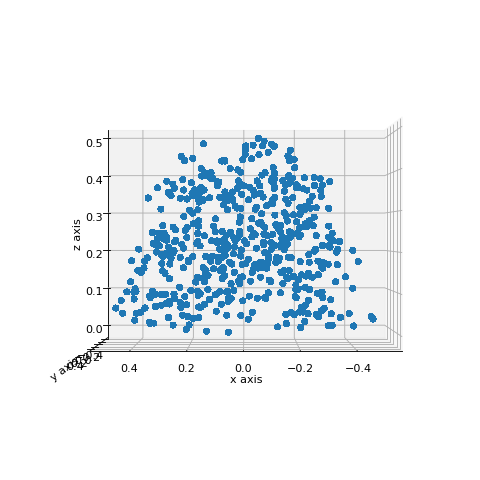

In [249]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

#fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

X = np.tile(x_train[2500:3000,0],(len(x_train[:500,0]),1))
Y = np.tile(x_train[2500:3000,1],(len(x_train[:500,1]),1))
Z = np.tile(x_train[2500:3000,2],(len(x_train[:500,2]),1))
ax.scatter(X,Y,Z)

ax.view_init(0,90)

ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


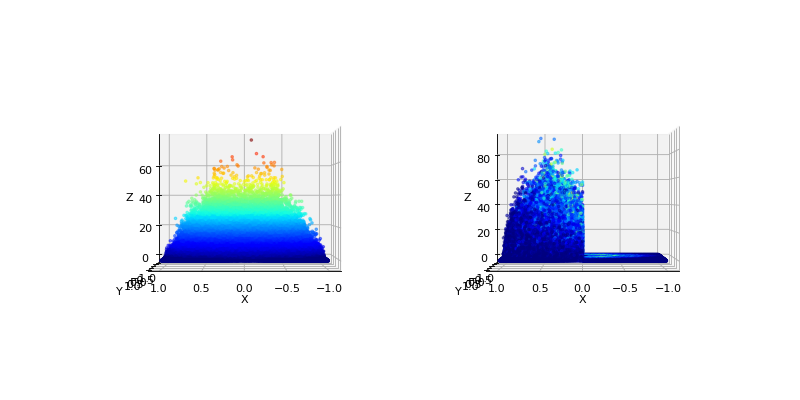

In [28]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np


fig, axs = plt.subplots(ncols=2, figsize=(10, 5), subplot_kw={"projection":"3d"})

for ax in axs:
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
data_criteria = 0.01
data_label = [-1. + data_criteria*i for i in range(200)]

x1,y1 = np.meshgrid(data_label,data_label)
Z = np.zeros([200,200])
Z2 = np.zeros([200,200])

position = x_train

for i_,i in enumerate(data_label):
    for j_,j in enumerate(data_label):
        count = np.sum(np.where( (position[:,0]> i) & (position[:,0] < i+data_criteria) & 
                               (position[:,1]<j+data_criteria ) & (position[:,1] > j),1,0))
        
        Z[i_][j_] = count
        
        count = np.sum(np.where( (position[:,0]> i) & (position[:,0] < i+data_criteria) & 
                               (position[:,2]<j+data_criteria ) & (position[:,2] > j),1,0))
        
        Z2[i_][j_] = count


#axs[0].plot_surface(x1,y1,Z,
#              cmap="jet",  alpha=0.5)

axs[0].scatter(x1, y1, Z,  # 3D scatter plot
               c=Z, cmap="jet", s=5, alpha=0.5)

axs[1].scatter(x1, y1, Z2,  # 3D scatter plot
               c=Z, cmap="jet", s=5, alpha=0.5)

axs[0].view_init(30,60)
axs[1].view_init(30,60)

plt.show()

In [30]:

axs[0].view_init(0,90)

axs[1].view_init(0,90)

plt.show()

In [448]:
print(np.sum(Z))
print(len(x_valid))
print(Z[75,83])

39962.0
40000
7.0


# Learn Model ! 

## Compile & fit model

In [48]:
robot_model = DNN_model(4,128,0,3)

In [114]:
pwd  = os.getcwd()
print(pwd)
model_name = robot_model.model_name

model_path = pwd + '/checkpoint/'+ model_name + '/val_loss/' +model_name +'_fast_loss.h5'

model_path


/home/irlab/juhan/IK_files/IK_DNN_class


'/home/irlab/juhan/IK_files/IK_DNN_class/checkpoint/DNN_IK_15_750_mish_he_normal_500/val_loss/DNN_IK_15_750_mish_he_normal_500_fast_loss.h5'

In [49]:
robot_model = DNN_model(15,1000,0,1)
robot_model.lr_init= 0.001

robot_model.make_model_2()
#robot_model.make_model()
#robot_model.get_weight_set_weight(model_path)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input states (InputLayer)       [(None, 8)]          0                                            
__________________________________________________________________________________________________
layer1 (Dense)                  (None, 1000)         9000        Input states[0][0]               
__________________________________________________________________________________________________
tf.convert_to_tensor (TFOpLambd (None, 1000)         0           layer1[0][0]                     
__________________________________________________________________________________________________
tf.math.softplus (TFOpLambda)   (None, 1000)         0           tf.convert_to_tensor[0][0]       
______________________________________________________________________________________________

In [113]:
robot_model.model_name

'DNN_IK_15_750_mish_he_normal_500'

In [120]:
robot.position_data[10]

array([ 0.52684677,  0.23205669,  0.74078053, -0.58567303, -0.44716996,
        0.05853066,  0.6734986 , 50.        ], dtype=float32)

In [68]:
#robot_model = DNN_model(8,1500,0,1)
epoch = 1000
robot_model.batch_size = 2000
robot.batch_size = 2000

for i in range(10):
    x_train,y_train,x_test,y_test,x_valid,y_valid = robot.data_split(robot.position_data[1:],robot.th_data[1:])

    x_train = x_train[:round(len(x_train),-3)]
    y_train = y_train[:round(len(y_train),-3)]
    x_valid = x_valid[:round(len(y_valid),-3)]
    y_valid = y_valid[:round(len(y_valid),-3)]

    x_train = x_train[:300000]
    y_train = y_train[:300000]
    x_valid = x_valid[:20000]
    y_valid = y_valid[:20000]


    print(len(x_train))
    print(len(x_valid))
    
    if i<2:
        robot_model.lr_init = 0.0005
    elif i<4:
        robot_model.lr_init = 0.0005
    elif i<6:
        robot_model.lr_init = 0.0003
    else:
        robot_model.lr_init = 0.0002
    #obot_model.get_weight_set_weight(model_path)
    robot_model.fit_fast(x_train,y_train,robot_model.batch_size,x_valid,y_valid)
    


300000
20000
Epoch 1/1000
tf.Tensor(0.0005, shape=(), dtype=float32)
150/150 [==============================] - 8s 34ms/step - loss: 0.2226 - mean_absolute_error: 0.1874 - val_loss: 0.2154 - val_mean_absolute_error: 0.2037
Epoch 2/1000
tf.Tensor(0.00049999903, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1925 - mean_absolute_error: 0.1868 - val_loss: 0.2150 - val_mean_absolute_error: 0.1897
Epoch 3/1000
tf.Tensor(0.00049999706, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1840 - mean_absolute_error: 0.1833 - val_loss: 0.2212 - val_mean_absolute_error: 0.1886
Epoch 4/1000
tf.Tensor(0.000499994, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1747 - mean_absolute_error: 0.1792 - val_loss: 0.2281 - val_mean_absolute_error: 0.1898
Epoch 5/1000
tf.Tensor(0.00049999, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.16

Epoch 76/1000
tf.Tensor(0.0004971584, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1174 - mean_absolute_error: 0.1446 - val_loss: 0.4607 - val_mean_absolute_error: 0.2496
Epoch 77/1000
tf.Tensor(0.00049708283, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1167 - mean_absolute_error: 0.1442 - val_loss: 0.4623 - val_mean_absolute_error: 0.2561
Epoch 78/1000
tf.Tensor(0.0004970063, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1176 - mean_absolute_error: 0.1445 - val_loss: 0.4627 - val_mean_absolute_error: 0.2511
Epoch 79/1000
tf.Tensor(0.0004969288, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1168 - mean_absolute_error: 0.1440 - val_loss: 0.4618 - val_mean_absolute_error: 0.2514
Epoch 80/1000
tf.Tensor(0.00049685035, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1

Epoch 151/1000
tf.Tensor(0.0004888032, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1119 - mean_absolute_error: 0.1375 - val_loss: 0.4916 - val_mean_absolute_error: 0.2610
Epoch 152/1000
tf.Tensor(0.0004886556, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1131 - mean_absolute_error: 0.1393 - val_loss: 0.4932 - val_mean_absolute_error: 0.2633
Epoch 153/1000
tf.Tensor(0.0004885071, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1117 - mean_absolute_error: 0.1369 - val_loss: 0.4873 - val_mean_absolute_error: 0.2590
Epoch 154/1000
tf.Tensor(0.0004883576, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1121 - mean_absolute_error: 0.1378 - val_loss: 0.4861 - val_mean_absolute_error: 0.2602
Epoch 155/1000
tf.Tensor(0.0004882072, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 

Epoch 226/1000
tf.Tensor(0.00047521203, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1120 - mean_absolute_error: 0.1357 - val_loss: 0.5057 - val_mean_absolute_error: 0.2729
Epoch 227/1000
tf.Tensor(0.0004749973, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1116 - mean_absolute_error: 0.1361 - val_loss: 0.5089 - val_mean_absolute_error: 0.2701
Epoch 228/1000
tf.Tensor(0.0004747817, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1126 - mean_absolute_error: 0.1367 - val_loss: 0.5030 - val_mean_absolute_error: 0.2670
Epoch 229/1000
tf.Tensor(0.00047456523, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1123 - mean_absolute_error: 0.1369 - val_loss: 0.4994 - val_mean_absolute_error: 0.2653
Epoch 230/1000
tf.Tensor(0.00047434794, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - los

150/150 [==============================] - 4s 28ms/step - loss: 0.1100 - mean_absolute_error: 0.1336 - val_loss: 0.5057 - val_mean_absolute_error: 0.2652
Epoch 264/1000
tf.Tensor(0.00046646348, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1106 - mean_absolute_error: 0.1337 - val_loss: 0.5085 - val_mean_absolute_error: 0.2677
Epoch 265/1000
tf.Tensor(0.0004662173, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1086 - mean_absolute_error: 0.1325 - val_loss: 0.5020 - val_mean_absolute_error: 0.2667
Epoch 266/1000
tf.Tensor(0.00046597028, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1095 - mean_absolute_error: 0.1331 - val_loss: 0.5064 - val_mean_absolute_error: 0.2667
Epoch 267/1000
tf.Tensor(0.00046572246, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1096 - mean_absolute_error: 0.1327 - val_loss: 0.5044 - val

Epoch 301/1000
tf.Tensor(0.00045683054, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1108 - mean_absolute_error: 0.1338 - val_loss: 0.5136 - val_mean_absolute_error: 0.2743
Epoch 302/1000
tf.Tensor(0.0004565556, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1103 - mean_absolute_error: 0.1339 - val_loss: 0.5107 - val_mean_absolute_error: 0.2678
Epoch 303/1000
tf.Tensor(0.00045627993, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1091 - mean_absolute_error: 0.1315 - val_loss: 0.5081 - val_mean_absolute_error: 0.2678
Epoch 304/1000
tf.Tensor(0.00045600353, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1095 - mean_absolute_error: 0.1317 - val_loss: 0.5134 - val_mean_absolute_error: 0.2707
Epoch 305/1000
tf.Tensor(0.00045572637, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - lo

Epoch 376/1000
tf.Tensor(0.00043424708, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1103 - mean_absolute_error: 0.1317 - val_loss: 0.5125 - val_mean_absolute_error: 0.2700
Epoch 377/1000
tf.Tensor(0.00043392068, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1088 - mean_absolute_error: 0.1307 - val_loss: 0.5143 - val_mean_absolute_error: 0.2710
Epoch 378/1000
tf.Tensor(0.00043359364, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1103 - mean_absolute_error: 0.1308 - val_loss: 0.5156 - val_mean_absolute_error: 0.2711
Epoch 379/1000
tf.Tensor(0.00043326596, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1084 - mean_absolute_error: 0.1301 - val_loss: 0.5159 - val_mean_absolute_error: 0.2719
Epoch 380/1000
tf.Tensor(0.00043293767, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - l

Epoch 451/1000
tf.Tensor(0.00040816233, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1071 - mean_absolute_error: 0.1284 - val_loss: 0.5169 - val_mean_absolute_error: 0.2700
Epoch 452/1000
tf.Tensor(0.00040779437, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1087 - mean_absolute_error: 0.1302 - val_loss: 0.5147 - val_mean_absolute_error: 0.2690
Epoch 453/1000
tf.Tensor(0.0004074259, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1076 - mean_absolute_error: 0.1304 - val_loss: 0.5151 - val_mean_absolute_error: 0.2703
Epoch 454/1000
tf.Tensor(0.00040705694, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1088 - mean_absolute_error: 0.1295 - val_loss: 0.5148 - val_mean_absolute_error: 0.2720
Epoch 455/1000
tf.Tensor(0.00040668753, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - lo

Epoch 526/1000
tf.Tensor(0.00037935266, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1072 - mean_absolute_error: 0.1278 - val_loss: 0.5179 - val_mean_absolute_error: 0.2708
Epoch 527/1000
tf.Tensor(0.0003789538, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1085 - mean_absolute_error: 0.1280 - val_loss: 0.5166 - val_mean_absolute_error: 0.2705
Epoch 528/1000
tf.Tensor(0.00037855457, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1068 - mean_absolute_error: 0.1271 - val_loss: 0.5228 - val_mean_absolute_error: 0.2715
Epoch 529/1000
tf.Tensor(0.00037815503, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1076 - mean_absolute_error: 0.1269 - val_loss: 0.5191 - val_mean_absolute_error: 0.2703
Epoch 530/1000
tf.Tensor(0.00037775518, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - lo

Epoch 601/1000
tf.Tensor(0.00034863225, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1084 - mean_absolute_error: 0.1270 - val_loss: 0.5196 - val_mean_absolute_error: 0.2708
Epoch 602/1000
tf.Tensor(0.00034821345, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1079 - mean_absolute_error: 0.1272 - val_loss: 0.5233 - val_mean_absolute_error: 0.2719
Epoch 603/1000
tf.Tensor(0.00034779447, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1075 - mean_absolute_error: 0.1265 - val_loss: 0.5229 - val_mean_absolute_error: 0.2737
Epoch 604/1000
tf.Tensor(0.00034737526, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1081 - mean_absolute_error: 0.1273 - val_loss: 0.5207 - val_mean_absolute_error: 0.2709
Epoch 605/1000
tf.Tensor(0.00034695587, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - l

Epoch 676/1000
tf.Tensor(0.00031681513, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1079 - mean_absolute_error: 0.1263 - val_loss: 0.5198 - val_mean_absolute_error: 0.2724
Epoch 677/1000
tf.Tensor(0.0003163871, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1073 - mean_absolute_error: 0.1261 - val_loss: 0.5221 - val_mean_absolute_error: 0.2724
Epoch 678/1000
tf.Tensor(0.000315959, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1070 - mean_absolute_error: 0.1260 - val_loss: 0.5210 - val_mean_absolute_error: 0.2719
Epoch 679/1000
tf.Tensor(0.00031553087, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1081 - mean_absolute_error: 0.1271 - val_loss: 0.5201 - val_mean_absolute_error: 0.2724
Epoch 680/1000
tf.Tensor(0.00031510266, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss

Epoch 751/1000
tf.Tensor(0.0002846811, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1059 - mean_absolute_error: 0.1235 - val_loss: 0.5248 - val_mean_absolute_error: 0.2737
Epoch 752/1000
tf.Tensor(0.00028425382, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1058 - mean_absolute_error: 0.1238 - val_loss: 0.5230 - val_mean_absolute_error: 0.2711
Epoch 753/1000
tf.Tensor(0.00028382664, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1068 - mean_absolute_error: 0.1242 - val_loss: 0.5223 - val_mean_absolute_error: 0.2707
Epoch 754/1000
tf.Tensor(0.00028339954, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1056 - mean_absolute_error: 0.1239 - val_loss: 0.5234 - val_mean_absolute_error: 0.2714
Epoch 755/1000
tf.Tensor(0.0002829725, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - los

Epoch 826/1000
tf.Tensor(0.00025294468, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1063 - mean_absolute_error: 0.1239 - val_loss: 0.5242 - val_mean_absolute_error: 0.2710
Epoch 827/1000
tf.Tensor(0.00025252716, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1064 - mean_absolute_error: 0.1241 - val_loss: 0.5228 - val_mean_absolute_error: 0.2713
Epoch 828/1000
tf.Tensor(0.00025210984, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1055 - mean_absolute_error: 0.1220 - val_loss: 0.5246 - val_mean_absolute_error: 0.2730
Epoch 829/1000
tf.Tensor(0.0002516927, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1064 - mean_absolute_error: 0.1236 - val_loss: 0.5250 - val_mean_absolute_error: 0.2709
Epoch 830/1000
tf.Tensor(0.00025127572, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - lo

150/150 [==============================] - 4s 28ms/step - loss: 0.1054 - mean_absolute_error: 0.1222 - val_loss: 0.5241 - val_mean_absolute_error: 0.2720
Epoch 864/1000
tf.Tensor(0.00023722032, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1052 - mean_absolute_error: 0.1220 - val_loss: 0.5255 - val_mean_absolute_error: 0.2712
Epoch 865/1000
tf.Tensor(0.00023681075, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1055 - mean_absolute_error: 0.1218 - val_loss: 0.5234 - val_mean_absolute_error: 0.2718
Epoch 866/1000
tf.Tensor(0.00023640144, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1062 - mean_absolute_error: 0.1234 - val_loss: 0.5249 - val_mean_absolute_error: 0.2708
Epoch 867/1000
tf.Tensor(0.00023599235, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1064 - mean_absolute_error: 0.1237 - val_loss: 0.5224 - va

Epoch 901/1000
tf.Tensor(0.000222232, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1061 - mean_absolute_error: 0.1226 - val_loss: 0.5251 - val_mean_absolute_error: 0.2733
Epoch 902/1000
tf.Tensor(0.00022183191, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1056 - mean_absolute_error: 0.1222 - val_loss: 0.5235 - val_mean_absolute_error: 0.2724
Epoch 903/1000
tf.Tensor(0.00022143208, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1057 - mean_absolute_error: 0.1219 - val_loss: 0.5263 - val_mean_absolute_error: 0.2745
Epoch 904/1000
tf.Tensor(0.00022103255, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1059 - mean_absolute_error: 0.1232 - val_loss: 0.5244 - val_mean_absolute_error: 0.2704
Epoch 905/1000
tf.Tensor(0.00022063327, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - los

150/150 [==============================] - 4s 28ms/step - loss: 0.1075 - mean_absolute_error: 0.1239 - val_loss: 0.5225 - val_mean_absolute_error: 0.2717
Epoch 976/1000
tf.Tensor(0.00019306419, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1059 - mean_absolute_error: 0.1226 - val_loss: 0.5236 - val_mean_absolute_error: 0.2710
Epoch 977/1000
tf.Tensor(0.0001926877, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1042 - mean_absolute_error: 0.1209 - val_loss: 0.5242 - val_mean_absolute_error: 0.2712
Epoch 978/1000
tf.Tensor(0.00019231156, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1068 - mean_absolute_error: 0.1234 - val_loss: 0.5249 - val_mean_absolute_error: 0.2725
Epoch 979/1000
tf.Tensor(0.00019193577, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1060 - mean_absolute_error: 0.1210 - val_loss: 0.5243 - val

Epoch 13/1000
tf.Tensor(0.0004999221, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1527 - mean_absolute_error: 0.1673 - val_loss: 0.2871 - val_mean_absolute_error: 0.2060
Epoch 14/1000
tf.Tensor(0.0004999091, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1502 - mean_absolute_error: 0.1665 - val_loss: 0.2937 - val_mean_absolute_error: 0.2093
Epoch 15/1000
tf.Tensor(0.00049989513, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1497 - mean_absolute_error: 0.1648 - val_loss: 0.3004 - val_mean_absolute_error: 0.2121
Epoch 16/1000
tf.Tensor(0.0004998802, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1505 - mean_absolute_error: 0.1662 - val_loss: 0.3039 - val_mean_absolute_error: 0.2124
Epoch 17/1000
tf.Tensor(0.00049986417, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1

Epoch 88/1000
tf.Tensor(0.00049618696, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1189 - mean_absolute_error: 0.1461 - val_loss: 0.4704 - val_mean_absolute_error: 0.2559
Epoch 89/1000
tf.Tensor(0.00049609964, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1195 - mean_absolute_error: 0.1461 - val_loss: 0.4675 - val_mean_absolute_error: 0.2586
Epoch 90/1000
tf.Tensor(0.0004960114, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1185 - mean_absolute_error: 0.1454 - val_loss: 0.4713 - val_mean_absolute_error: 0.2558
Epoch 91/1000
tf.Tensor(0.0004959221, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1162 - mean_absolute_error: 0.1435 - val_loss: 0.4700 - val_mean_absolute_error: 0.2555
Epoch 92/1000
tf.Tensor(0.0004958319, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1

Epoch 163/1000
tf.Tensor(0.00048697076, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1124 - mean_absolute_error: 0.1370 - val_loss: 0.5022 - val_mean_absolute_error: 0.2661
Epoch 164/1000
tf.Tensor(0.00048681203, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1129 - mean_absolute_error: 0.1384 - val_loss: 0.5059 - val_mean_absolute_error: 0.2662
Epoch 165/1000
tf.Tensor(0.0004866524, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1116 - mean_absolute_error: 0.1375 - val_loss: 0.5037 - val_mean_absolute_error: 0.2676
Epoch 166/1000
tf.Tensor(0.00048649183, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1115 - mean_absolute_error: 0.1361 - val_loss: 0.5047 - val_mean_absolute_error: 0.2661
Epoch 167/1000
tf.Tensor(0.00048633033, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - lo

150/150 [==============================] - 4s 28ms/step - loss: 0.1112 - mean_absolute_error: 0.1353 - val_loss: 0.5156 - val_mean_absolute_error: 0.2697
Epoch 238/1000
tf.Tensor(0.0004725792, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1100 - mean_absolute_error: 0.1343 - val_loss: 0.5140 - val_mean_absolute_error: 0.2694
Epoch 239/1000
tf.Tensor(0.00047235432, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1102 - mean_absolute_error: 0.1340 - val_loss: 0.5125 - val_mean_absolute_error: 0.2694
Epoch 240/1000
tf.Tensor(0.00047212862, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1093 - mean_absolute_error: 0.1343 - val_loss: 0.5169 - val_mean_absolute_error: 0.2699
Epoch 241/1000
tf.Tensor(0.00047190208, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1098 - mean_absolute_error: 0.1338 - val_loss: 0.5133 - val

Epoch 275/1000
tf.Tensor(0.00046371127, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1097 - mean_absolute_error: 0.1325 - val_loss: 0.5196 - val_mean_absolute_error: 0.2697
Epoch 276/1000
tf.Tensor(0.00046345632, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1088 - mean_absolute_error: 0.1321 - val_loss: 0.5141 - val_mean_absolute_error: 0.2688
Epoch 277/1000
tf.Tensor(0.00046320056, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1101 - mean_absolute_error: 0.1331 - val_loss: 0.5166 - val_mean_absolute_error: 0.2721
Epoch 278/1000
tf.Tensor(0.000462944, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1083 - mean_absolute_error: 0.1320 - val_loss: 0.5175 - val_mean_absolute_error: 0.2714
Epoch 279/1000
tf.Tensor(0.0004626867, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss

Epoch 350/1000
tf.Tensor(0.00044251006, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1083 - mean_absolute_error: 0.1316 - val_loss: 0.5213 - val_mean_absolute_error: 0.2709
Epoch 351/1000
tf.Tensor(0.00044220043, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1075 - mean_absolute_error: 0.1293 - val_loss: 0.5208 - val_mean_absolute_error: 0.2726
Epoch 352/1000
tf.Tensor(0.00044189012, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1099 - mean_absolute_error: 0.1320 - val_loss: 0.5192 - val_mean_absolute_error: 0.2703
Epoch 353/1000
tf.Tensor(0.00044157918, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1078 - mean_absolute_error: 0.1309 - val_loss: 0.5207 - val_mean_absolute_error: 0.2704
Epoch 354/1000
tf.Tensor(0.00044126753, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - l

Epoch 425/1000
tf.Tensor(0.00041755426, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1092 - mean_absolute_error: 0.1306 - val_loss: 0.5200 - val_mean_absolute_error: 0.2736
Epoch 426/1000
tf.Tensor(0.0004171995, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1089 - mean_absolute_error: 0.1304 - val_loss: 0.5234 - val_mean_absolute_error: 0.2724
Epoch 427/1000
tf.Tensor(0.00041684424, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1085 - mean_absolute_error: 0.1306 - val_loss: 0.5195 - val_mean_absolute_error: 0.2745
Epoch 428/1000
tf.Tensor(0.0004164884, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1092 - mean_absolute_error: 0.1309 - val_loss: 0.5231 - val_mean_absolute_error: 0.2720
Epoch 429/1000
tf.Tensor(0.00041613204, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - los

Epoch 500/1000
tf.Tensor(0.00038959814, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1065 - mean_absolute_error: 0.1270 - val_loss: 0.5203 - val_mean_absolute_error: 0.2707
Epoch 501/1000
tf.Tensor(0.00038920876, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1069 - mean_absolute_error: 0.1271 - val_loss: 0.5237 - val_mean_absolute_error: 0.2701
Epoch 502/1000
tf.Tensor(0.00038881894, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1061 - mean_absolute_error: 0.1271 - val_loss: 0.5234 - val_mean_absolute_error: 0.2723
Epoch 503/1000
tf.Tensor(0.00038842874, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1073 - mean_absolute_error: 0.1280 - val_loss: 0.5237 - val_mean_absolute_error: 0.2743
Epoch 504/1000
tf.Tensor(0.0003880382, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - lo

Epoch 575/1000
tf.Tensor(0.00035944715, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1075 - mean_absolute_error: 0.1266 - val_loss: 0.5250 - val_mean_absolute_error: 0.2715
Epoch 576/1000
tf.Tensor(0.00035903402, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1069 - mean_absolute_error: 0.1266 - val_loss: 0.5253 - val_mean_absolute_error: 0.2712
Epoch 577/1000
tf.Tensor(0.00035862066, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1067 - mean_absolute_error: 0.1251 - val_loss: 0.5278 - val_mean_absolute_error: 0.2724
Epoch 578/1000
tf.Tensor(0.00035820706, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1073 - mean_absolute_error: 0.1269 - val_loss: 0.5252 - val_mean_absolute_error: 0.2723
Epoch 579/1000
tf.Tensor(0.00035779324, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - l

Epoch 650/1000
tf.Tensor(0.0003279195, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1070 - mean_absolute_error: 0.1250 - val_loss: 0.5281 - val_mean_absolute_error: 0.2712
Epoch 651/1000
tf.Tensor(0.00032749347, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1056 - mean_absolute_error: 0.1248 - val_loss: 0.5255 - val_mean_absolute_error: 0.2721
Epoch 652/1000
tf.Tensor(0.00032706736, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1066 - mean_absolute_error: 0.1257 - val_loss: 0.5273 - val_mean_absolute_error: 0.2741
Epoch 653/1000
tf.Tensor(0.00032664114, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1060 - mean_absolute_error: 0.1236 - val_loss: 0.5243 - val_mean_absolute_error: 0.2715
Epoch 654/1000
tf.Tensor(0.00032621482, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - lo

Epoch 725/1000
tf.Tensor(0.00029581055, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1060 - mean_absolute_error: 0.1238 - val_loss: 0.5275 - val_mean_absolute_error: 0.2750
Epoch 726/1000
tf.Tensor(0.00029538193, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1073 - mean_absolute_error: 0.1254 - val_loss: 0.5282 - val_mean_absolute_error: 0.2747
Epoch 727/1000
tf.Tensor(0.00029495335, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1062 - mean_absolute_error: 0.1251 - val_loss: 0.5251 - val_mean_absolute_error: 0.2727
Epoch 728/1000
tf.Tensor(0.0002945248, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1068 - mean_absolute_error: 0.1242 - val_loss: 0.5278 - val_mean_absolute_error: 0.2726
Epoch 729/1000
tf.Tensor(0.00029409627, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - lo

Epoch 800/1000
tf.Tensor(0.00026386048, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1049 - mean_absolute_error: 0.1232 - val_loss: 0.5292 - val_mean_absolute_error: 0.2716
Epoch 801/1000
tf.Tensor(0.00026343865, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1062 - mean_absolute_error: 0.1236 - val_loss: 0.5250 - val_mean_absolute_error: 0.2710
Epoch 802/1000
tf.Tensor(0.00026301696, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1050 - mean_absolute_error: 0.1221 - val_loss: 0.5252 - val_mean_absolute_error: 0.2727
Epoch 803/1000
tf.Tensor(0.00026259542, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1044 - mean_absolute_error: 0.1210 - val_loss: 0.5275 - val_mean_absolute_error: 0.2721
Epoch 804/1000
tf.Tensor(0.00026217403, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - l

150/150 [==============================] - 4s 28ms/step - loss: 0.1050 - mean_absolute_error: 0.1215 - val_loss: 0.5245 - val_mean_absolute_error: 0.2720
Epoch 838/1000
tf.Tensor(0.000247947, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1050 - mean_absolute_error: 0.1221 - val_loss: 0.5301 - val_mean_absolute_error: 0.2728
Epoch 839/1000
tf.Tensor(0.00024753177, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1059 - mean_absolute_error: 0.1228 - val_loss: 0.5274 - val_mean_absolute_error: 0.2715
Epoch 840/1000
tf.Tensor(0.00024711675, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1060 - mean_absolute_error: 0.1227 - val_loss: 0.5292 - val_mean_absolute_error: 0.2723
Epoch 841/1000
tf.Tensor(0.00024670194, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1047 - mean_absolute_error: 0.1212 - val_loss: 0.5289 - val_

Epoch 912/1000
tf.Tensor(0.00021784635, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1069 - mean_absolute_error: 0.1231 - val_loss: 0.5278 - val_mean_absolute_error: 0.2715
Epoch 913/1000
tf.Tensor(0.00021744936, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1049 - mean_absolute_error: 0.1211 - val_loss: 0.5298 - val_mean_absolute_error: 0.2722
Epoch 914/1000
tf.Tensor(0.00021705266, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1046 - mean_absolute_error: 0.1211 - val_loss: 0.5281 - val_mean_absolute_error: 0.2723
Epoch 915/1000
tf.Tensor(0.00021665626, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1060 - mean_absolute_error: 0.1223 - val_loss: 0.5297 - val_mean_absolute_error: 0.2731
Epoch 916/1000
tf.Tensor(0.00021626014, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - l

150/150 [==============================] - 4s 28ms/step - loss: 0.1048 - mean_absolute_error: 0.1205 - val_loss: 0.5287 - val_mean_absolute_error: 0.2719
Epoch 987/1000
tf.Tensor(0.00018894213, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1044 - mean_absolute_error: 0.1196 - val_loss: 0.5282 - val_mean_absolute_error: 0.2713
Epoch 988/1000
tf.Tensor(0.00018856952, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1034 - mean_absolute_error: 0.1197 - val_loss: 0.5293 - val_mean_absolute_error: 0.2723
Epoch 989/1000
tf.Tensor(0.00018819729, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1043 - mean_absolute_error: 0.1203 - val_loss: 0.5287 - val_mean_absolute_error: 0.2717
Epoch 990/1000
tf.Tensor(0.00018782541, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1049 - mean_absolute_error: 0.1206 - val_loss: 0.5295 - va

Epoch 24/1000
tf.Tensor(0.00049972424, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1424 - mean_absolute_error: 0.1620 - val_loss: 0.3326 - val_mean_absolute_error: 0.2194
Epoch 25/1000
tf.Tensor(0.00049970025, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1406 - mean_absolute_error: 0.1595 - val_loss: 0.3307 - val_mean_absolute_error: 0.2203
Epoch 26/1000
tf.Tensor(0.0004996753, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1413 - mean_absolute_error: 0.1597 - val_loss: 0.3363 - val_mean_absolute_error: 0.2198
Epoch 27/1000
tf.Tensor(0.00049964926, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1397 - mean_absolute_error: 0.1597 - val_loss: 0.3424 - val_mean_absolute_error: 0.2226
Epoch 28/1000
tf.Tensor(0.00049962226, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0

Epoch 99/1000
tf.Tensor(0.0004951729, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1156 - mean_absolute_error: 0.1415 - val_loss: 0.4731 - val_mean_absolute_error: 0.2591
Epoch 100/1000
tf.Tensor(0.0004950749, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1161 - mean_absolute_error: 0.1425 - val_loss: 0.4706 - val_mean_absolute_error: 0.2582
Epoch 101/1000
tf.Tensor(0.0004949759, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1170 - mean_absolute_error: 0.1438 - val_loss: 0.4716 - val_mean_absolute_error: 0.2582
Epoch 102/1000
tf.Tensor(0.0004948759, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1163 - mean_absolute_error: 0.1422 - val_loss: 0.4719 - val_mean_absolute_error: 0.2569
Epoch 103/1000
tf.Tensor(0.00049477495, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 

Epoch 174/1000
tf.Tensor(0.00048517427, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1134 - mean_absolute_error: 0.1390 - val_loss: 0.5045 - val_mean_absolute_error: 0.2659
Epoch 175/1000
tf.Tensor(0.00048500547, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1140 - mean_absolute_error: 0.1396 - val_loss: 0.5024 - val_mean_absolute_error: 0.2687
Epoch 176/1000
tf.Tensor(0.00048483573, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1122 - mean_absolute_error: 0.1365 - val_loss: 0.5040 - val_mean_absolute_error: 0.2672
Epoch 177/1000
tf.Tensor(0.00048466513, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1119 - mean_absolute_error: 0.1373 - val_loss: 0.4997 - val_mean_absolute_error: 0.2670
Epoch 178/1000
tf.Tensor(0.00048449362, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - l

Epoch 249/1000
tf.Tensor(0.00047005957, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1103 - mean_absolute_error: 0.1334 - val_loss: 0.5106 - val_mean_absolute_error: 0.2701
Epoch 250/1000
tf.Tensor(0.00046982555, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1096 - mean_absolute_error: 0.1327 - val_loss: 0.5072 - val_mean_absolute_error: 0.2668
Epoch 251/1000
tf.Tensor(0.0004695907, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1104 - mean_absolute_error: 0.1336 - val_loss: 0.5094 - val_mean_absolute_error: 0.2709
Epoch 252/1000
tf.Tensor(0.00046935503, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1110 - mean_absolute_error: 0.1349 - val_loss: 0.5099 - val_mean_absolute_error: 0.2690
Epoch 253/1000
tf.Tensor(0.00046911853, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - lo

Epoch 324/1000
tf.Tensor(0.00045032107, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1107 - mean_absolute_error: 0.1334 - val_loss: 0.5153 - val_mean_absolute_error: 0.2696
Epoch 325/1000
tf.Tensor(0.0004500294, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1094 - mean_absolute_error: 0.1318 - val_loss: 0.5148 - val_mean_absolute_error: 0.2693
Epoch 326/1000
tf.Tensor(0.00044973695, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1093 - mean_absolute_error: 0.1313 - val_loss: 0.5175 - val_mean_absolute_error: 0.2695
Epoch 327/1000
tf.Tensor(0.00044944382, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1082 - mean_absolute_error: 0.1312 - val_loss: 0.5148 - val_mean_absolute_error: 0.2689
Epoch 328/1000
tf.Tensor(0.00044915, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss:

150/150 [==============================] - 4s 28ms/step - loss: 0.1093 - mean_absolute_error: 0.1301 - val_loss: 0.5190 - val_mean_absolute_error: 0.2704
Epoch 399/1000
tf.Tensor(0.00042658515, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1090 - mean_absolute_error: 0.1303 - val_loss: 0.5166 - val_mean_absolute_error: 0.2717
Epoch 400/1000
tf.Tensor(0.00042624486, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1077 - mean_absolute_error: 0.1283 - val_loss: 0.5137 - val_mean_absolute_error: 0.2714
Epoch 401/1000
tf.Tensor(0.00042590403, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1087 - mean_absolute_error: 0.1296 - val_loss: 0.5201 - val_mean_absolute_error: 0.2708
Epoch 402/1000
tf.Tensor(0.0004255626, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1092 - mean_absolute_error: 0.1298 - val_loss: 0.5202 - val

Epoch 436/1000
tf.Tensor(0.0004136229, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1085 - mean_absolute_error: 0.1285 - val_loss: 0.5204 - val_mean_absolute_error: 0.2725
Epoch 437/1000
tf.Tensor(0.0004132624, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1087 - mean_absolute_error: 0.1290 - val_loss: 0.5233 - val_mean_absolute_error: 0.2744
Epoch 438/1000
tf.Tensor(0.00041290137, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1085 - mean_absolute_error: 0.1282 - val_loss: 0.5247 - val_mean_absolute_error: 0.2719
Epoch 439/1000
tf.Tensor(0.00041253984, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1077 - mean_absolute_error: 0.1285 - val_loss: 0.5212 - val_mean_absolute_error: 0.2747
Epoch 440/1000
tf.Tensor(0.0004121778, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss

Epoch 511/1000
tf.Tensor(0.00038529377, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1079 - mean_absolute_error: 0.1286 - val_loss: 0.5248 - val_mean_absolute_error: 0.2752
Epoch 512/1000
tf.Tensor(0.0003849002, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1074 - mean_absolute_error: 0.1272 - val_loss: 0.5294 - val_mean_absolute_error: 0.2742
Epoch 513/1000
tf.Tensor(0.00038450627, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1076 - mean_absolute_error: 0.1279 - val_loss: 0.5250 - val_mean_absolute_error: 0.2742
Epoch 514/1000
tf.Tensor(0.00038411198, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1080 - mean_absolute_error: 0.1285 - val_loss: 0.5263 - val_mean_absolute_error: 0.2738
Epoch 515/1000
tf.Tensor(0.00038371733, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - lo

Epoch 586/1000
tf.Tensor(0.0003548898, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1078 - mean_absolute_error: 0.1270 - val_loss: 0.5276 - val_mean_absolute_error: 0.2738
Epoch 587/1000
tf.Tensor(0.00035447412, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1079 - mean_absolute_error: 0.1263 - val_loss: 0.5271 - val_mean_absolute_error: 0.2729
Epoch 588/1000
tf.Tensor(0.00035405823, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1077 - mean_absolute_error: 0.1262 - val_loss: 0.5275 - val_mean_absolute_error: 0.2723
Epoch 589/1000
tf.Tensor(0.00035364213, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1076 - mean_absolute_error: 0.1258 - val_loss: 0.5301 - val_mean_absolute_error: 0.2730
Epoch 590/1000
tf.Tensor(0.00035322577, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - lo

Epoch 661/1000
tf.Tensor(0.00032322807, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1063 - mean_absolute_error: 0.1254 - val_loss: 0.5256 - val_mean_absolute_error: 0.2744
Epoch 662/1000
tf.Tensor(0.00032280106, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1069 - mean_absolute_error: 0.1243 - val_loss: 0.5267 - val_mean_absolute_error: 0.2725
Epoch 663/1000
tf.Tensor(0.00032237393, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1072 - mean_absolute_error: 0.1261 - val_loss: 0.5312 - val_mean_absolute_error: 0.2736
Epoch 664/1000
tf.Tensor(0.00032194675, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1066 - mean_absolute_error: 0.1248 - val_loss: 0.5316 - val_mean_absolute_error: 0.2741
Epoch 665/1000
tf.Tensor(0.0003215195, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - lo

Epoch 736/1000
tf.Tensor(0.00029109782, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1063 - mean_absolute_error: 0.1232 - val_loss: 0.5298 - val_mean_absolute_error: 0.2738
Epoch 737/1000
tf.Tensor(0.00029066965, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1059 - mean_absolute_error: 0.1228 - val_loss: 0.5296 - val_mean_absolute_error: 0.2745
Epoch 738/1000
tf.Tensor(0.00029024153, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1064 - mean_absolute_error: 0.1241 - val_loss: 0.5294 - val_mean_absolute_error: 0.2734
Epoch 739/1000
tf.Tensor(0.00028981344, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1065 - mean_absolute_error: 0.1236 - val_loss: 0.5321 - val_mean_absolute_error: 0.2750
Epoch 740/1000
tf.Tensor(0.0002893854, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - lo

Epoch 811/1000
tf.Tensor(0.00025922863, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1055 - mean_absolute_error: 0.1238 - val_loss: 0.5270 - val_mean_absolute_error: 0.2750
Epoch 812/1000
tf.Tensor(0.00025880852, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1066 - mean_absolute_error: 0.1234 - val_loss: 0.5287 - val_mean_absolute_error: 0.2746
Epoch 813/1000
tf.Tensor(0.00025838855, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1068 - mean_absolute_error: 0.1234 - val_loss: 0.5349 - val_mean_absolute_error: 0.2799
Epoch 814/1000
tf.Tensor(0.00025796876, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1072 - mean_absolute_error: 0.1251 - val_loss: 0.5350 - val_mean_absolute_error: 0.2748
Epoch 815/1000
tf.Tensor(0.00025754914, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - l

150/150 [==============================] - 4s 28ms/step - loss: 0.1048 - mean_absolute_error: 0.1216 - val_loss: 0.5318 - val_mean_absolute_error: 0.2734
Epoch 886/1000
tf.Tensor(0.00022826601, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1073 - mean_absolute_error: 0.1231 - val_loss: 0.5311 - val_mean_absolute_error: 0.2734
Epoch 887/1000
tf.Tensor(0.00022786189, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1059 - mean_absolute_error: 0.1220 - val_loss: 0.5300 - val_mean_absolute_error: 0.2743
Epoch 888/1000
tf.Tensor(0.00022745802, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1053 - mean_absolute_error: 0.1216 - val_loss: 0.5301 - val_mean_absolute_error: 0.2730
Epoch 889/1000
tf.Tensor(0.0002270544, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1062 - mean_absolute_error: 0.1236 - val_loss: 0.5323 - val

Epoch 923/1000
tf.Tensor(0.00021349557, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1043 - mean_absolute_error: 0.1203 - val_loss: 0.5309 - val_mean_absolute_error: 0.2729
Epoch 924/1000
tf.Tensor(0.00021310183, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1062 - mean_absolute_error: 0.1224 - val_loss: 0.5332 - val_mean_absolute_error: 0.2742
Epoch 925/1000
tf.Tensor(0.00021270839, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1049 - mean_absolute_error: 0.1207 - val_loss: 0.5314 - val_mean_absolute_error: 0.2744
Epoch 926/1000
tf.Tensor(0.00021231525, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1064 - mean_absolute_error: 0.1228 - val_loss: 0.5330 - val_mean_absolute_error: 0.2747
Epoch 927/1000
tf.Tensor(0.00021192241, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - l

150/150 [==============================] - 4s 28ms/step - loss: 0.1068 - mean_absolute_error: 0.1220 - val_loss: 0.5323 - val_mean_absolute_error: 0.2732
Epoch 998/1000
tf.Tensor(0.00018486335, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1068 - mean_absolute_error: 0.1218 - val_loss: 0.5326 - val_mean_absolute_error: 0.2736
Epoch 999/1000
tf.Tensor(0.00018449474, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1054 - mean_absolute_error: 0.1213 - val_loss: 0.5305 - val_mean_absolute_error: 0.2736
Epoch 1000/1000
tf.Tensor(0.00018412649, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1057 - mean_absolute_error: 0.1220 - val_loss: 0.5339 - val_mean_absolute_error: 0.2739
300000
20000
Epoch 1/1000
tf.Tensor(0.0005, shape=(), dtype=float32)
150/150 [==============================] - 8s 33ms/step - loss: 0.2296 - mean_absolute_error: 0.1890 - val_loss: 0.2213

Epoch 35/1000
tf.Tensor(0.00049940555, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1367 - mean_absolute_error: 0.1588 - val_loss: 0.3434 - val_mean_absolute_error: 0.2207
Epoch 36/1000
tf.Tensor(0.0004993706, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1351 - mean_absolute_error: 0.1568 - val_loss: 0.3456 - val_mean_absolute_error: 0.2227
Epoch 37/1000
tf.Tensor(0.00049933465, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1355 - mean_absolute_error: 0.1570 - val_loss: 0.3482 - val_mean_absolute_error: 0.2224
Epoch 38/1000
tf.Tensor(0.0004992977, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1345 - mean_absolute_error: 0.1559 - val_loss: 0.3529 - val_mean_absolute_error: 0.2220
Epoch 39/1000
tf.Tensor(0.00049925974, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.

Epoch 110/1000
tf.Tensor(0.0004940413, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1165 - mean_absolute_error: 0.1425 - val_loss: 0.4662 - val_mean_absolute_error: 0.2541
Epoch 111/1000
tf.Tensor(0.00049393263, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1175 - mean_absolute_error: 0.1428 - val_loss: 0.4686 - val_mean_absolute_error: 0.2564
Epoch 112/1000
tf.Tensor(0.00049382297, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1167 - mean_absolute_error: 0.1422 - val_loss: 0.4634 - val_mean_absolute_error: 0.2522
Epoch 113/1000
tf.Tensor(0.0004937124, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1156 - mean_absolute_error: 0.1420 - val_loss: 0.4691 - val_mean_absolute_error: 0.2540
Epoch 114/1000
tf.Tensor(0.00049360085, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - los

150/150 [==============================] - 4s 28ms/step - loss: 0.1134 - mean_absolute_error: 0.1390 - val_loss: 0.4838 - val_mean_absolute_error: 0.2577
Epoch 148/1000
tf.Tensor(0.0004892404, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1149 - mean_absolute_error: 0.1378 - val_loss: 0.4822 - val_mean_absolute_error: 0.2581
Epoch 149/1000
tf.Tensor(0.0004890956, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1129 - mean_absolute_error: 0.1378 - val_loss: 0.4788 - val_mean_absolute_error: 0.2548
Epoch 150/1000
tf.Tensor(0.0004889498, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1143 - mean_absolute_error: 0.1386 - val_loss: 0.4823 - val_mean_absolute_error: 0.2580
Epoch 151/1000
tf.Tensor(0.0004888032, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1128 - mean_absolute_error: 0.1382 - val_loss: 0.4816 - val_me

Epoch 185/1000
tf.Tensor(0.0004832675, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1116 - mean_absolute_error: 0.1353 - val_loss: 0.4867 - val_mean_absolute_error: 0.2600
Epoch 186/1000
tf.Tensor(0.00048308875, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1128 - mean_absolute_error: 0.1370 - val_loss: 0.4952 - val_mean_absolute_error: 0.2614
Epoch 187/1000
tf.Tensor(0.0004829091, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1119 - mean_absolute_error: 0.1359 - val_loss: 0.4926 - val_mean_absolute_error: 0.2603
Epoch 188/1000
tf.Tensor(0.00048272853, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1107 - mean_absolute_error: 0.1359 - val_loss: 0.4928 - val_mean_absolute_error: 0.2600
Epoch 189/1000
tf.Tensor(0.00048254707, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - los

Epoch 260/1000
tf.Tensor(0.00046744032, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1097 - mean_absolute_error: 0.1330 - val_loss: 0.5000 - val_mean_absolute_error: 0.2630
Epoch 261/1000
tf.Tensor(0.00046719733, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1101 - mean_absolute_error: 0.1322 - val_loss: 0.4991 - val_mean_absolute_error: 0.2611
Epoch 262/1000
tf.Tensor(0.0004669535, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1105 - mean_absolute_error: 0.1336 - val_loss: 0.4971 - val_mean_absolute_error: 0.2591
Epoch 263/1000
tf.Tensor(0.00046670888, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1106 - mean_absolute_error: 0.1329 - val_loss: 0.4982 - val_mean_absolute_error: 0.2611
Epoch 264/1000
tf.Tensor(0.00046646348, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - lo

Epoch 335/1000
tf.Tensor(0.0004470735, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1091 - mean_absolute_error: 0.1306 - val_loss: 0.5058 - val_mean_absolute_error: 0.2637
Epoch 336/1000
tf.Tensor(0.00044677404, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1090 - mean_absolute_error: 0.1303 - val_loss: 0.5057 - val_mean_absolute_error: 0.2623
Epoch 337/1000
tf.Tensor(0.00044647392, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1099 - mean_absolute_error: 0.1309 - val_loss: 0.5028 - val_mean_absolute_error: 0.2625
Epoch 338/1000
tf.Tensor(0.0004461731, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1102 - mean_absolute_error: 0.1310 - val_loss: 0.5089 - val_mean_absolute_error: 0.2662
Epoch 339/1000
tf.Tensor(0.0004458716, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss

Epoch 410/1000
tf.Tensor(0.00042281055, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1082 - mean_absolute_error: 0.1294 - val_loss: 0.5088 - val_mean_absolute_error: 0.2669
Epoch 411/1000
tf.Tensor(0.000422464, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1100 - mean_absolute_error: 0.1293 - val_loss: 0.5098 - val_mean_absolute_error: 0.2652
Epoch 412/1000
tf.Tensor(0.0004221169, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1088 - mean_absolute_error: 0.1292 - val_loss: 0.5073 - val_mean_absolute_error: 0.2646
Epoch 413/1000
tf.Tensor(0.00042176922, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1088 - mean_absolute_error: 0.1299 - val_loss: 0.5051 - val_mean_absolute_error: 0.2637
Epoch 414/1000
tf.Tensor(0.000421421, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 

150/150 [==============================] - 4s 28ms/step - loss: 0.1090 - mean_absolute_error: 0.1289 - val_loss: 0.5082 - val_mean_absolute_error: 0.2685
Epoch 485/1000
tf.Tensor(0.0003953911, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1076 - mean_absolute_error: 0.1276 - val_loss: 0.5121 - val_mean_absolute_error: 0.2671
Epoch 486/1000
tf.Tensor(0.00039500778, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1077 - mean_absolute_error: 0.1278 - val_loss: 0.5113 - val_mean_absolute_error: 0.2657
Epoch 487/1000
tf.Tensor(0.00039462402, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1086 - mean_absolute_error: 0.1284 - val_loss: 0.5145 - val_mean_absolute_error: 0.2670
Epoch 488/1000
tf.Tensor(0.00039423985, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1079 - mean_absolute_error: 0.1280 - val_loss: 0.5117 - val

Epoch 522/1000
tf.Tensor(0.00038094466, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1073 - mean_absolute_error: 0.1276 - val_loss: 0.5117 - val_mean_absolute_error: 0.2650
Epoch 523/1000
tf.Tensor(0.00038054716, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1081 - mean_absolute_error: 0.1267 - val_loss: 0.5149 - val_mean_absolute_error: 0.2672
Epoch 524/1000
tf.Tensor(0.00038014934, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1074 - mean_absolute_error: 0.1265 - val_loss: 0.5130 - val_mean_absolute_error: 0.2666
Epoch 525/1000
tf.Tensor(0.00037975117, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1073 - mean_absolute_error: 0.1273 - val_loss: 0.5143 - val_mean_absolute_error: 0.2678
Epoch 526/1000
tf.Tensor(0.00037935266, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - l

Epoch 597/1000
tf.Tensor(0.00035030546, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1075 - mean_absolute_error: 0.1261 - val_loss: 0.5181 - val_mean_absolute_error: 0.2706
Epoch 598/1000
tf.Tensor(0.00034988747, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1081 - mean_absolute_error: 0.1277 - val_loss: 0.5166 - val_mean_absolute_error: 0.2677
Epoch 599/1000
tf.Tensor(0.00034946928, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1089 - mean_absolute_error: 0.1267 - val_loss: 0.5130 - val_mean_absolute_error: 0.2677
Epoch 600/1000
tf.Tensor(0.00034905085, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1079 - mean_absolute_error: 0.1271 - val_loss: 0.5162 - val_mean_absolute_error: 0.2675
Epoch 601/1000
tf.Tensor(0.00034863225, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - l

Epoch 672/1000
tf.Tensor(0.00031852673, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1064 - mean_absolute_error: 0.1239 - val_loss: 0.5170 - val_mean_absolute_error: 0.2663
Epoch 673/1000
tf.Tensor(0.0003180989, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1085 - mean_absolute_error: 0.1270 - val_loss: 0.5162 - val_mean_absolute_error: 0.2664
Epoch 674/1000
tf.Tensor(0.00031767102, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1073 - mean_absolute_error: 0.1239 - val_loss: 0.5127 - val_mean_absolute_error: 0.2658
Epoch 675/1000
tf.Tensor(0.0003172431, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1068 - mean_absolute_error: 0.1229 - val_loss: 0.5148 - val_mean_absolute_error: 0.2659
Epoch 676/1000
tf.Tensor(0.00031681513, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - los

Epoch 747/1000
tf.Tensor(0.00028639086, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1059 - mean_absolute_error: 0.1244 - val_loss: 0.5190 - val_mean_absolute_error: 0.2688
Epoch 748/1000
tf.Tensor(0.00028596332, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1061 - mean_absolute_error: 0.1239 - val_loss: 0.5153 - val_mean_absolute_error: 0.2657
Epoch 749/1000
tf.Tensor(0.00028553585, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1065 - mean_absolute_error: 0.1230 - val_loss: 0.5152 - val_mean_absolute_error: 0.2670
Epoch 750/1000
tf.Tensor(0.00028510843, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1054 - mean_absolute_error: 0.1224 - val_loss: 0.5180 - val_mean_absolute_error: 0.2691
Epoch 751/1000
tf.Tensor(0.0002846811, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - lo

150/150 [==============================] - 4s 28ms/step - loss: 0.1061 - mean_absolute_error: 0.1233 - val_loss: 0.5168 - val_mean_absolute_error: 0.2674
Epoch 822/1000
tf.Tensor(0.00025461652, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1067 - mean_absolute_error: 0.1241 - val_loss: 0.5162 - val_mean_absolute_error: 0.2668
Epoch 823/1000
tf.Tensor(0.0002541983, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1075 - mean_absolute_error: 0.1235 - val_loss: 0.5196 - val_mean_absolute_error: 0.2665
Epoch 824/1000
tf.Tensor(0.00025378025, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1073 - mean_absolute_error: 0.1228 - val_loss: 0.5162 - val_mean_absolute_error: 0.2661
Epoch 825/1000
tf.Tensor(0.00025336238, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1068 - mean_absolute_error: 0.1236 - val_loss: 0.5192 - val

Epoch 859/1000
tf.Tensor(0.00023927158, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1064 - mean_absolute_error: 0.1219 - val_loss: 0.5169 - val_mean_absolute_error: 0.2654
Epoch 860/1000
tf.Tensor(0.00023886086, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1058 - mean_absolute_error: 0.1224 - val_loss: 0.5160 - val_mean_absolute_error: 0.2655
Epoch 861/1000
tf.Tensor(0.00023845038, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1069 - mean_absolute_error: 0.1217 - val_loss: 0.5157 - val_mean_absolute_error: 0.2656
Epoch 862/1000
tf.Tensor(0.00023804013, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1058 - mean_absolute_error: 0.1229 - val_loss: 0.5175 - val_mean_absolute_error: 0.2654
Epoch 863/1000
tf.Tensor(0.00023763011, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - l

150/150 [==============================] - 4s 28ms/step - loss: 0.1057 - mean_absolute_error: 0.1210 - val_loss: 0.5178 - val_mean_absolute_error: 0.2660
Epoch 934/1000
tf.Tensor(0.00020918106, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1064 - mean_absolute_error: 0.1216 - val_loss: 0.5205 - val_mean_absolute_error: 0.2678
Epoch 935/1000
tf.Tensor(0.00020879068, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1062 - mean_absolute_error: 0.1217 - val_loss: 0.5174 - val_mean_absolute_error: 0.2655
Epoch 936/1000
tf.Tensor(0.00020840061, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1049 - mean_absolute_error: 0.1202 - val_loss: 0.5206 - val_mean_absolute_error: 0.2674
Epoch 937/1000
tf.Tensor(0.00020801084, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1053 - mean_absolute_error: 0.1207 - val_loss: 0.5175 - va

Epoch 8/1000
tf.Tensor(0.00029998325, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1713 - mean_absolute_error: 0.1743 - val_loss: 0.2365 - val_mean_absolute_error: 0.1890
Epoch 9/1000
tf.Tensor(0.00029997845, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1683 - mean_absolute_error: 0.1725 - val_loss: 0.2406 - val_mean_absolute_error: 0.1873
Epoch 10/1000
tf.Tensor(0.00029997303, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1679 - mean_absolute_error: 0.1729 - val_loss: 0.2458 - val_mean_absolute_error: 0.1892
Epoch 11/1000
tf.Tensor(0.00029996704, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1638 - mean_absolute_error: 0.1700 - val_loss: 0.2497 - val_mean_absolute_error: 0.1908
Epoch 12/1000
tf.Tensor(0.00029996046, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.

Epoch 83/1000
tf.Tensor(0.0002979655, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1245 - mean_absolute_error: 0.1489 - val_loss: 0.4099 - val_mean_absolute_error: 0.2370
Epoch 84/1000
tf.Tensor(0.00029791606, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1250 - mean_absolute_error: 0.1489 - val_loss: 0.4130 - val_mean_absolute_error: 0.2378
Epoch 85/1000
tf.Tensor(0.00029786603, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1251 - mean_absolute_error: 0.1497 - val_loss: 0.4200 - val_mean_absolute_error: 0.2411
Epoch 86/1000
tf.Tensor(0.0002978154, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1229 - mean_absolute_error: 0.1473 - val_loss: 0.4162 - val_mean_absolute_error: 0.2382
Epoch 87/1000
tf.Tensor(0.00029776417, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.

Epoch 158/1000
tf.Tensor(0.00029265045, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1158 - mean_absolute_error: 0.1395 - val_loss: 0.4689 - val_mean_absolute_error: 0.2516
Epoch 159/1000
tf.Tensor(0.000292558, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1151 - mean_absolute_error: 0.1397 - val_loss: 0.4649 - val_mean_absolute_error: 0.2500
Epoch 160/1000
tf.Tensor(0.00029246497, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1147 - mean_absolute_error: 0.1391 - val_loss: 0.4660 - val_mean_absolute_error: 0.2507
Epoch 161/1000
tf.Tensor(0.0002923714, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1149 - mean_absolute_error: 0.1383 - val_loss: 0.4680 - val_mean_absolute_error: 0.2521
Epoch 162/1000
tf.Tensor(0.00029227728, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss

Epoch 233/1000
tf.Tensor(0.0002842148, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1122 - mean_absolute_error: 0.1368 - val_loss: 0.4836 - val_mean_absolute_error: 0.2572
Epoch 234/1000
tf.Tensor(0.0002840824, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1130 - mean_absolute_error: 0.1362 - val_loss: 0.4841 - val_mean_absolute_error: 0.2552
Epoch 235/1000
tf.Tensor(0.00028394948, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1112 - mean_absolute_error: 0.1343 - val_loss: 0.4855 - val_mean_absolute_error: 0.2548
Epoch 236/1000
tf.Tensor(0.00028381607, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1121 - mean_absolute_error: 0.1361 - val_loss: 0.4862 - val_mean_absolute_error: 0.2582
Epoch 237/1000
tf.Tensor(0.00028368217, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - los

Epoch 308/1000
tf.Tensor(0.00027293456, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1102 - mean_absolute_error: 0.1334 - val_loss: 0.4927 - val_mean_absolute_error: 0.2565
Epoch 309/1000
tf.Tensor(0.00027276648, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1096 - mean_absolute_error: 0.1310 - val_loss: 0.4974 - val_mean_absolute_error: 0.2578
Epoch 310/1000
tf.Tensor(0.00027259797, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1103 - mean_absolute_error: 0.1322 - val_loss: 0.4957 - val_mean_absolute_error: 0.2578
Epoch 311/1000
tf.Tensor(0.000272429, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1109 - mean_absolute_error: 0.1334 - val_loss: 0.4939 - val_mean_absolute_error: 0.2576
Epoch 312/1000
tf.Tensor(0.0002722596, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss

Epoch 383/1000
tf.Tensor(0.0002591698, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1103 - mean_absolute_error: 0.1303 - val_loss: 0.5013 - val_mean_absolute_error: 0.2608
Epoch 384/1000
tf.Tensor(0.00025897135, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1105 - mean_absolute_error: 0.1314 - val_loss: 0.5015 - val_mean_absolute_error: 0.2591
Epoch 385/1000
tf.Tensor(0.00025877255, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1104 - mean_absolute_error: 0.1312 - val_loss: 0.4998 - val_mean_absolute_error: 0.2603
Epoch 386/1000
tf.Tensor(0.0002585734, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1103 - mean_absolute_error: 0.1318 - val_loss: 0.5003 - val_mean_absolute_error: 0.2588
Epoch 387/1000
tf.Tensor(0.00025837385, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - los

Epoch 458/1000
tf.Tensor(0.00024334619, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1084 - mean_absolute_error: 0.1294 - val_loss: 0.5065 - val_mean_absolute_error: 0.2592
Epoch 459/1000
tf.Tensor(0.00024312339, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1093 - mean_absolute_error: 0.1295 - val_loss: 0.5078 - val_mean_absolute_error: 0.2604
Epoch 460/1000
tf.Tensor(0.0002429003, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1096 - mean_absolute_error: 0.1297 - val_loss: 0.5054 - val_mean_absolute_error: 0.2594
Epoch 461/1000
tf.Tensor(0.00024267695, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1086 - mean_absolute_error: 0.1287 - val_loss: 0.5040 - val_mean_absolute_error: 0.2601
Epoch 462/1000
tf.Tensor(0.00024245332, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - lo

150/150 [==============================] - 4s 28ms/step - loss: 0.1093 - mean_absolute_error: 0.1285 - val_loss: 0.5070 - val_mean_absolute_error: 0.2600
Epoch 533/1000
tf.Tensor(0.00022593247, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1103 - mean_absolute_error: 0.1302 - val_loss: 0.5074 - val_mean_absolute_error: 0.2604
Epoch 534/1000
tf.Tensor(0.00022569177, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1088 - mean_absolute_error: 0.1281 - val_loss: 0.5060 - val_mean_absolute_error: 0.2609
Epoch 535/1000
tf.Tensor(0.00022545086, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1078 - mean_absolute_error: 0.1278 - val_loss: 0.5041 - val_mean_absolute_error: 0.2600
Epoch 536/1000
tf.Tensor(0.00022520976, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1090 - mean_absolute_error: 0.1285 - val_loss: 0.5084 - va

150/150 [==============================] - 4s 28ms/step - loss: 0.1072 - mean_absolute_error: 0.1266 - val_loss: 0.5073 - val_mean_absolute_error: 0.2607
Epoch 607/1000
tf.Tensor(0.00020767015, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1093 - mean_absolute_error: 0.1282 - val_loss: 0.5084 - val_mean_absolute_error: 0.2626
Epoch 608/1000
tf.Tensor(0.00020741821, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1073 - mean_absolute_error: 0.1264 - val_loss: 0.5079 - val_mean_absolute_error: 0.2602
Epoch 609/1000
tf.Tensor(0.00020716614, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1093 - mean_absolute_error: 0.1282 - val_loss: 0.5082 - val_mean_absolute_error: 0.2626
Epoch 610/1000
tf.Tensor(0.00020691397, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1081 - mean_absolute_error: 0.1273 - val_loss: 0.5071 - va

150/150 [==============================] - 4s 28ms/step - loss: 0.1082 - mean_absolute_error: 0.1259 - val_loss: 0.5113 - val_mean_absolute_error: 0.2611
Epoch 681/1000
tf.Tensor(0.00018880484, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1065 - mean_absolute_error: 0.1256 - val_loss: 0.5118 - val_mean_absolute_error: 0.2613
Epoch 682/1000
tf.Tensor(0.00018854787, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1077 - mean_absolute_error: 0.1260 - val_loss: 0.5100 - val_mean_absolute_error: 0.2603
Epoch 683/1000
tf.Tensor(0.00018829085, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1093 - mean_absolute_error: 0.1260 - val_loss: 0.5107 - val_mean_absolute_error: 0.2617
Epoch 684/1000
tf.Tensor(0.00018803382, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1076 - mean_absolute_error: 0.1256 - val_loss: 0.5095 - va

Epoch 755/1000
tf.Tensor(0.00016978363, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1068 - mean_absolute_error: 0.1249 - val_loss: 0.5123 - val_mean_absolute_error: 0.2607
Epoch 756/1000
tf.Tensor(0.00016952744, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1075 - mean_absolute_error: 0.1254 - val_loss: 0.5141 - val_mean_absolute_error: 0.2625
Epoch 757/1000
tf.Tensor(0.00016927131, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1091 - mean_absolute_error: 0.1267 - val_loss: 0.5115 - val_mean_absolute_error: 0.2618
Epoch 758/1000
tf.Tensor(0.00016901523, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1075 - mean_absolute_error: 0.1253 - val_loss: 0.5103 - val_mean_absolute_error: 0.2611
Epoch 759/1000
tf.Tensor(0.0001687592, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - lo

150/150 [==============================] - 4s 28ms/step - loss: 0.1071 - mean_absolute_error: 0.1258 - val_loss: 0.5124 - val_mean_absolute_error: 0.2616
Epoch 793/1000
tf.Tensor(0.00016009051, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1076 - mean_absolute_error: 0.1252 - val_loss: 0.5123 - val_mean_absolute_error: 0.2622
Epoch 794/1000
tf.Tensor(0.00015983681, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1065 - mean_absolute_error: 0.1239 - val_loss: 0.5136 - val_mean_absolute_error: 0.2622
Epoch 795/1000
tf.Tensor(0.00015958319, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1062 - mean_absolute_error: 0.1247 - val_loss: 0.5131 - val_mean_absolute_error: 0.2615
Epoch 796/1000
tf.Tensor(0.00015932965, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1076 - mean_absolute_error: 0.1244 - val_loss: 0.5114 - va

Epoch 830/1000
tf.Tensor(0.00015076555, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1079 - mean_absolute_error: 0.1241 - val_loss: 0.5132 - val_mean_absolute_error: 0.2612
Epoch 831/1000
tf.Tensor(0.0001505155, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1060 - mean_absolute_error: 0.1239 - val_loss: 0.5131 - val_mean_absolute_error: 0.2611
Epoch 832/1000
tf.Tensor(0.00015026555, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1080 - mean_absolute_error: 0.1257 - val_loss: 0.5132 - val_mean_absolute_error: 0.2618
Epoch 833/1000
tf.Tensor(0.00015001572, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1059 - mean_absolute_error: 0.1235 - val_loss: 0.5114 - val_mean_absolute_error: 0.2610
Epoch 834/1000
tf.Tensor(0.000149766, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss

Epoch 905/1000
tf.Tensor(0.00013238004, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1074 - mean_absolute_error: 0.1239 - val_loss: 0.5134 - val_mean_absolute_error: 0.2607
Epoch 906/1000
tf.Tensor(0.00013214065, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1077 - mean_absolute_error: 0.1252 - val_loss: 0.5138 - val_mean_absolute_error: 0.2622
Epoch 907/1000
tf.Tensor(0.00013190143, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1074 - mean_absolute_error: 0.1241 - val_loss: 0.5136 - val_mean_absolute_error: 0.2623
Epoch 908/1000
tf.Tensor(0.00013166237, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1070 - mean_absolute_error: 0.1249 - val_loss: 0.5124 - val_mean_absolute_error: 0.2615
Epoch 909/1000
tf.Tensor(0.00013142348, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - l

150/150 [==============================] - 4s 28ms/step - loss: 0.1057 - mean_absolute_error: 0.1239 - val_loss: 0.5135 - val_mean_absolute_error: 0.2626
Epoch 943/1000
tf.Tensor(0.00012340742, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1066 - mean_absolute_error: 0.1228 - val_loss: 0.5140 - val_mean_absolute_error: 0.2621
Epoch 944/1000
tf.Tensor(0.00012317489, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1068 - mean_absolute_error: 0.1240 - val_loss: 0.5129 - val_mean_absolute_error: 0.2610
Epoch 945/1000
tf.Tensor(0.00012294255, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1067 - mean_absolute_error: 0.1244 - val_loss: 0.5134 - val_mean_absolute_error: 0.2611
Epoch 946/1000
tf.Tensor(0.00012271042, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1071 - mean_absolute_error: 0.1242 - val_loss: 0.5140 - va

Epoch 17/1000
tf.Tensor(0.00029991847, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1515 - mean_absolute_error: 0.1638 - val_loss: 0.2615 - val_mean_absolute_error: 0.1903
Epoch 18/1000
tf.Tensor(0.00029990825, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1510 - mean_absolute_error: 0.1628 - val_loss: 0.2642 - val_mean_absolute_error: 0.1910
Epoch 19/1000
tf.Tensor(0.00029989745, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1491 - mean_absolute_error: 0.1626 - val_loss: 0.2679 - val_mean_absolute_error: 0.1925
Epoch 20/1000
tf.Tensor(0.00029988607, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1490 - mean_absolute_error: 0.1630 - val_loss: 0.2709 - val_mean_absolute_error: 0.1949
Epoch 21/1000
tf.Tensor(0.0002998741, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0

Epoch 92/1000
tf.Tensor(0.0002974993, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1208 - mean_absolute_error: 0.1458 - val_loss: 0.4132 - val_mean_absolute_error: 0.2345
Epoch 93/1000
tf.Tensor(0.00029744458, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1194 - mean_absolute_error: 0.1455 - val_loss: 0.4149 - val_mean_absolute_error: 0.2368
Epoch 94/1000
tf.Tensor(0.00029738926, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1206 - mean_absolute_error: 0.1458 - val_loss: 0.4151 - val_mean_absolute_error: 0.2360
Epoch 95/1000
tf.Tensor(0.00029733338, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1197 - mean_absolute_error: 0.1450 - val_loss: 0.4142 - val_mean_absolute_error: 0.2359
Epoch 96/1000
tf.Tensor(0.00029727689, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0

Epoch 167/1000
tf.Tensor(0.00029179835, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1141 - mean_absolute_error: 0.1400 - val_loss: 0.4556 - val_mean_absolute_error: 0.2444
Epoch 168/1000
tf.Tensor(0.0002917009, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1139 - mean_absolute_error: 0.1388 - val_loss: 0.4543 - val_mean_absolute_error: 0.2464
Epoch 169/1000
tf.Tensor(0.0002916029, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1144 - mean_absolute_error: 0.1398 - val_loss: 0.4563 - val_mean_absolute_error: 0.2453
Epoch 170/1000
tf.Tensor(0.00029150434, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1128 - mean_absolute_error: 0.1380 - val_loss: 0.4562 - val_mean_absolute_error: 0.2482
Epoch 171/1000
tf.Tensor(0.00029140525, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - los

Epoch 242/1000
tf.Tensor(0.00028300504, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1118 - mean_absolute_error: 0.1357 - val_loss: 0.4720 - val_mean_absolute_error: 0.2514
Epoch 243/1000
tf.Tensor(0.0002828681, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1115 - mean_absolute_error: 0.1350 - val_loss: 0.4725 - val_mean_absolute_error: 0.2512
Epoch 244/1000
tf.Tensor(0.00028273065, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1122 - mean_absolute_error: 0.1363 - val_loss: 0.4705 - val_mean_absolute_error: 0.2505
Epoch 245/1000
tf.Tensor(0.00028259272, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1118 - mean_absolute_error: 0.1359 - val_loss: 0.4731 - val_mean_absolute_error: 0.2490
Epoch 246/1000
tf.Tensor(0.0002824543, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - los

Epoch 317/1000
tf.Tensor(0.00027140608, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1099 - mean_absolute_error: 0.1336 - val_loss: 0.4788 - val_mean_absolute_error: 0.2512
Epoch 318/1000
tf.Tensor(0.00027123408, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1094 - mean_absolute_error: 0.1320 - val_loss: 0.4795 - val_mean_absolute_error: 0.2514
Epoch 319/1000
tf.Tensor(0.00027106164, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1108 - mean_absolute_error: 0.1328 - val_loss: 0.4811 - val_mean_absolute_error: 0.2517
Epoch 320/1000
tf.Tensor(0.00027088876, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1105 - mean_absolute_error: 0.1330 - val_loss: 0.4810 - val_mean_absolute_error: 0.2516
Epoch 321/1000
tf.Tensor(0.00027071545, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - l

Epoch 392/1000
tf.Tensor(0.00025737073, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1091 - mean_absolute_error: 0.1307 - val_loss: 0.4843 - val_mean_absolute_error: 0.2532
Epoch 393/1000
tf.Tensor(0.00025716904, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1106 - mean_absolute_error: 0.1311 - val_loss: 0.4806 - val_mean_absolute_error: 0.2545
Epoch 394/1000
tf.Tensor(0.00025696697, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1106 - mean_absolute_error: 0.1310 - val_loss: 0.4825 - val_mean_absolute_error: 0.2522
Epoch 395/1000
tf.Tensor(0.00025676456, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1097 - mean_absolute_error: 0.1309 - val_loss: 0.4848 - val_mean_absolute_error: 0.2539
Epoch 396/1000
tf.Tensor(0.0002565618, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - lo

Epoch 467/1000
tf.Tensor(0.00024133094, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1088 - mean_absolute_error: 0.1295 - val_loss: 0.4853 - val_mean_absolute_error: 0.2537
Epoch 468/1000
tf.Tensor(0.00024110563, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1084 - mean_absolute_error: 0.1294 - val_loss: 0.4881 - val_mean_absolute_error: 0.2531
Epoch 469/1000
tf.Tensor(0.00024088006, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1088 - mean_absolute_error: 0.1297 - val_loss: 0.4837 - val_mean_absolute_error: 0.2537
Epoch 470/1000
tf.Tensor(0.00024065423, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1094 - mean_absolute_error: 0.1303 - val_loss: 0.4863 - val_mean_absolute_error: 0.2535
Epoch 471/1000
tf.Tensor(0.00024042814, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - l

150/150 [==============================] - 4s 28ms/step - loss: 0.1080 - mean_absolute_error: 0.1292 - val_loss: 0.4910 - val_mean_absolute_error: 0.2552
Epoch 542/1000
tf.Tensor(0.00022375917, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1087 - mean_absolute_error: 0.1286 - val_loss: 0.4879 - val_mean_absolute_error: 0.2539
Epoch 543/1000
tf.Tensor(0.00022351675, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1087 - mean_absolute_error: 0.1286 - val_loss: 0.4885 - val_mean_absolute_error: 0.2545
Epoch 544/1000
tf.Tensor(0.00022327414, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1088 - mean_absolute_error: 0.1288 - val_loss: 0.4888 - val_mean_absolute_error: 0.2538
Epoch 545/1000
tf.Tensor(0.00022303135, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1087 - mean_absolute_error: 0.1288 - val_loss: 0.4908 - va

150/150 [==============================] - 4s 28ms/step - loss: 0.1080 - mean_absolute_error: 0.1285 - val_loss: 0.4928 - val_mean_absolute_error: 0.2547
Epoch 616/1000
tf.Tensor(0.00020539873, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1067 - mean_absolute_error: 0.1264 - val_loss: 0.4903 - val_mean_absolute_error: 0.2557
Epoch 617/1000
tf.Tensor(0.00020514584, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1083 - mean_absolute_error: 0.1275 - val_loss: 0.4926 - val_mean_absolute_error: 0.2549
Epoch 618/1000
tf.Tensor(0.00020489286, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1082 - mean_absolute_error: 0.1270 - val_loss: 0.4907 - val_mean_absolute_error: 0.2547
Epoch 619/1000
tf.Tensor(0.00020463977, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1085 - mean_absolute_error: 0.1286 - val_loss: 0.4910 - va

150/150 [==============================] - 4s 28ms/step - loss: 0.1090 - mean_absolute_error: 0.1274 - val_loss: 0.4936 - val_mean_absolute_error: 0.2546
Epoch 690/1000
tf.Tensor(0.0001864912, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1078 - mean_absolute_error: 0.1263 - val_loss: 0.4921 - val_mean_absolute_error: 0.2540
Epoch 691/1000
tf.Tensor(0.00018623403, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1079 - mean_absolute_error: 0.1261 - val_loss: 0.4916 - val_mean_absolute_error: 0.2548
Epoch 692/1000
tf.Tensor(0.00018597684, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1074 - mean_absolute_error: 0.1258 - val_loss: 0.4946 - val_mean_absolute_error: 0.2546
Epoch 693/1000
tf.Tensor(0.00018571962, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1080 - mean_absolute_error: 0.1264 - val_loss: 0.4928 - val

Epoch 727/1000
tf.Tensor(0.00017697219, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1079 - mean_absolute_error: 0.1254 - val_loss: 0.4949 - val_mean_absolute_error: 0.2556
Epoch 728/1000
tf.Tensor(0.00017671505, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1068 - mean_absolute_error: 0.1249 - val_loss: 0.4897 - val_mean_absolute_error: 0.2554
Epoch 729/1000
tf.Tensor(0.00017645794, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1075 - mean_absolute_error: 0.1261 - val_loss: 0.4927 - val_mean_absolute_error: 0.2546
Epoch 730/1000
tf.Tensor(0.00017620085, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1079 - mean_absolute_error: 0.1263 - val_loss: 0.4949 - val_mean_absolute_error: 0.2547
Epoch 731/1000
tf.Tensor(0.00017594379, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - l

150/150 [==============================] - 4s 28ms/step - loss: 0.1062 - mean_absolute_error: 0.1260 - val_loss: 0.4950 - val_mean_absolute_error: 0.2553
Epoch 802/1000
tf.Tensor(0.00015781025, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1072 - mean_absolute_error: 0.1243 - val_loss: 0.4934 - val_mean_absolute_error: 0.2554
Epoch 803/1000
tf.Tensor(0.00015755733, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1076 - mean_absolute_error: 0.1251 - val_loss: 0.4936 - val_mean_absolute_error: 0.2559
Epoch 804/1000
tf.Tensor(0.0001573045, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1069 - mean_absolute_error: 0.1252 - val_loss: 0.4950 - val_mean_absolute_error: 0.2546
Epoch 805/1000
tf.Tensor(0.00015705176, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1084 - mean_absolute_error: 0.1253 - val_loss: 0.4940 - val

Epoch 839/1000
tf.Tensor(0.00014851919, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1068 - mean_absolute_error: 0.1252 - val_loss: 0.4963 - val_mean_absolute_error: 0.2564
Epoch 840/1000
tf.Tensor(0.00014827018, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1072 - mean_absolute_error: 0.1246 - val_loss: 0.4936 - val_mean_absolute_error: 0.2558
Epoch 841/1000
tf.Tensor(0.0001480213, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1081 - mean_absolute_error: 0.1256 - val_loss: 0.4937 - val_mean_absolute_error: 0.2544
Epoch 842/1000
tf.Tensor(0.00014777255, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1060 - mean_absolute_error: 0.1240 - val_loss: 0.4939 - val_mean_absolute_error: 0.2547
Epoch 843/1000
tf.Tensor(0.00014752391, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - lo

Epoch 914/1000
tf.Tensor(0.00013023167, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1053 - mean_absolute_error: 0.1242 - val_loss: 0.4943 - val_mean_absolute_error: 0.2545
Epoch 915/1000
tf.Tensor(0.00012999383, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1070 - mean_absolute_error: 0.1239 - val_loss: 0.4932 - val_mean_absolute_error: 0.2540
Epoch 916/1000
tf.Tensor(0.00012975615, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1073 - mean_absolute_error: 0.1237 - val_loss: 0.4935 - val_mean_absolute_error: 0.2548
Epoch 917/1000
tf.Tensor(0.00012951867, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1060 - mean_absolute_error: 0.1246 - val_loss: 0.4936 - val_mean_absolute_error: 0.2541
Epoch 918/1000
tf.Tensor(0.00012928135, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - l

150/150 [==============================] - 4s 28ms/step - loss: 0.1065 - mean_absolute_error: 0.1236 - val_loss: 0.4939 - val_mean_absolute_error: 0.2545
Epoch 989/1000
tf.Tensor(0.00011291844, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1065 - mean_absolute_error: 0.1238 - val_loss: 0.4938 - val_mean_absolute_error: 0.2544
Epoch 990/1000
tf.Tensor(0.00011269531, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1069 - mean_absolute_error: 0.1229 - val_loss: 0.4946 - val_mean_absolute_error: 0.2553
Epoch 991/1000
tf.Tensor(0.00011247239, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1068 - mean_absolute_error: 0.1234 - val_loss: 0.4972 - val_mean_absolute_error: 0.2563
Epoch 992/1000
tf.Tensor(0.00011224969, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1061 - mean_absolute_error: 0.1227 - val_loss: 0.4951 - va

Epoch 26/1000
tf.Tensor(0.00019987008, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1504 - mean_absolute_error: 0.1634 - val_loss: 0.2778 - val_mean_absolute_error: 0.1951
Epoch 27/1000
tf.Tensor(0.00019985967, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1495 - mean_absolute_error: 0.1626 - val_loss: 0.2802 - val_mean_absolute_error: 0.1953
Epoch 28/1000
tf.Tensor(0.00019984887, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1484 - mean_absolute_error: 0.1616 - val_loss: 0.2843 - val_mean_absolute_error: 0.1965
Epoch 29/1000
tf.Tensor(0.00019983768, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1473 - mean_absolute_error: 0.1610 - val_loss: 0.2845 - val_mean_absolute_error: 0.1983
Epoch 30/1000
tf.Tensor(0.0001998261, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0

Epoch 101/1000
tf.Tensor(0.0001979904, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1230 - mean_absolute_error: 0.1478 - val_loss: 0.4104 - val_mean_absolute_error: 0.2307
Epoch 102/1000
tf.Tensor(0.00019795042, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1231 - mean_absolute_error: 0.1463 - val_loss: 0.4104 - val_mean_absolute_error: 0.2315
Epoch 103/1000
tf.Tensor(0.00019791003, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1231 - mean_absolute_error: 0.1469 - val_loss: 0.4102 - val_mean_absolute_error: 0.2324
Epoch 104/1000
tf.Tensor(0.00019786927, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1242 - mean_absolute_error: 0.1490 - val_loss: 0.4129 - val_mean_absolute_error: 0.2343
Epoch 105/1000
tf.Tensor(0.0001978281, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - los

Epoch 176/1000
tf.Tensor(0.00019393429, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1163 - mean_absolute_error: 0.1412 - val_loss: 0.4592 - val_mean_absolute_error: 0.2446
Epoch 177/1000
tf.Tensor(0.00019386604, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1151 - mean_absolute_error: 0.1414 - val_loss: 0.4600 - val_mean_absolute_error: 0.2441
Epoch 178/1000
tf.Tensor(0.00019379744, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1159 - mean_absolute_error: 0.1417 - val_loss: 0.4594 - val_mean_absolute_error: 0.2455
Epoch 179/1000
tf.Tensor(0.00019372845, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1171 - mean_absolute_error: 0.1427 - val_loss: 0.4582 - val_mean_absolute_error: 0.2440
Epoch 180/1000
tf.Tensor(0.00019365911, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - l

Epoch 251/1000
tf.Tensor(0.00018783628, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1131 - mean_absolute_error: 0.1375 - val_loss: 0.4794 - val_mean_absolute_error: 0.2489
Epoch 252/1000
tf.Tensor(0.00018774201, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1134 - mean_absolute_error: 0.1377 - val_loss: 0.4771 - val_mean_absolute_error: 0.2494
Epoch 253/1000
tf.Tensor(0.00018764741, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1136 - mean_absolute_error: 0.1373 - val_loss: 0.4780 - val_mean_absolute_error: 0.2491
Epoch 254/1000
tf.Tensor(0.00018755249, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1135 - mean_absolute_error: 0.1382 - val_loss: 0.4800 - val_mean_absolute_error: 0.2500
Epoch 255/1000
tf.Tensor(0.00018745725, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - l

150/150 [==============================] - 4s 28ms/step - loss: 0.1115 - mean_absolute_error: 0.1340 - val_loss: 0.4880 - val_mean_absolute_error: 0.2516
Epoch 326/1000
tf.Tensor(0.00017989476, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1116 - mean_absolute_error: 0.1346 - val_loss: 0.4872 - val_mean_absolute_error: 0.2516
Epoch 327/1000
tf.Tensor(0.00017977752, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1118 - mean_absolute_error: 0.1353 - val_loss: 0.4847 - val_mean_absolute_error: 0.2518
Epoch 328/1000
tf.Tensor(0.00017966, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1105 - mean_absolute_error: 0.1336 - val_loss: 0.4887 - val_mean_absolute_error: 0.2511
Epoch 329/1000
tf.Tensor(0.00017954218, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1114 - mean_absolute_error: 0.1347 - val_loss: 0.4871 - val_m

Epoch 363/1000
tf.Tensor(0.00017537326, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1116 - mean_absolute_error: 0.1352 - val_loss: 0.4912 - val_mean_absolute_error: 0.2527
Epoch 364/1000
tf.Tensor(0.000175246, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1114 - mean_absolute_error: 0.1337 - val_loss: 0.4924 - val_mean_absolute_error: 0.2523
Epoch 365/1000
tf.Tensor(0.00017511846, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1120 - mean_absolute_error: 0.1338 - val_loss: 0.4933 - val_mean_absolute_error: 0.2527
Epoch 366/1000
tf.Tensor(0.00017499067, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1111 - mean_absolute_error: 0.1342 - val_loss: 0.4912 - val_mean_absolute_error: 0.2533
Epoch 367/1000
tf.Tensor(0.00017486262, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - los

150/150 [==============================] - 4s 28ms/step - loss: 0.1110 - mean_absolute_error: 0.1337 - val_loss: 0.4955 - val_mean_absolute_error: 0.2540
Epoch 438/1000
tf.Tensor(0.00016516047, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1097 - mean_absolute_error: 0.1324 - val_loss: 0.4958 - val_mean_absolute_error: 0.2529
Epoch 439/1000
tf.Tensor(0.00016501585, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1097 - mean_absolute_error: 0.1312 - val_loss: 0.4958 - val_mean_absolute_error: 0.2530
Epoch 440/1000
tf.Tensor(0.00016487103, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1108 - mean_absolute_error: 0.1325 - val_loss: 0.4976 - val_mean_absolute_error: 0.2543
Epoch 441/1000
tf.Tensor(0.000164726, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1096 - mean_absolute_error: 0.1319 - val_loss: 0.4968 - val_

Epoch 475/1000
tf.Tensor(0.00015968029, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1101 - mean_absolute_error: 0.1330 - val_loss: 0.4992 - val_mean_absolute_error: 0.2555
Epoch 476/1000
tf.Tensor(0.00015952867, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1091 - mean_absolute_error: 0.1315 - val_loss: 0.4974 - val_mean_absolute_error: 0.2548
Epoch 477/1000
tf.Tensor(0.00015937687, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1108 - mean_absolute_error: 0.1326 - val_loss: 0.4965 - val_mean_absolute_error: 0.2536
Epoch 478/1000
tf.Tensor(0.00015922489, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1102 - mean_absolute_error: 0.1312 - val_loss: 0.4962 - val_mean_absolute_error: 0.2528
Epoch 479/1000
tf.Tensor(0.00015907275, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - l

150/150 [==============================] - 4s 28ms/step - loss: 0.1102 - mean_absolute_error: 0.1316 - val_loss: 0.4990 - val_mean_absolute_error: 0.2532
Epoch 550/1000
tf.Tensor(0.0001478761, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1094 - mean_absolute_error: 0.1301 - val_loss: 0.4991 - val_mean_absolute_error: 0.2554
Epoch 551/1000
tf.Tensor(0.00014771352, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1108 - mean_absolute_error: 0.1324 - val_loss: 0.5020 - val_mean_absolute_error: 0.2546
Epoch 552/1000
tf.Tensor(0.00014755083, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1100 - mean_absolute_error: 0.1306 - val_loss: 0.5004 - val_mean_absolute_error: 0.2542
Epoch 553/1000
tf.Tensor(0.00014738803, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1090 - mean_absolute_error: 0.1306 - val_loss: 0.5024 - val

Epoch 587/1000
tf.Tensor(0.00014178944, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1084 - mean_absolute_error: 0.1297 - val_loss: 0.5004 - val_mean_absolute_error: 0.2544
Epoch 588/1000
tf.Tensor(0.00014162308, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1087 - mean_absolute_error: 0.1302 - val_loss: 0.5014 - val_mean_absolute_error: 0.2550
Epoch 589/1000
tf.Tensor(0.00014145664, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1093 - mean_absolute_error: 0.1291 - val_loss: 0.5060 - val_mean_absolute_error: 0.2558
Epoch 590/1000
tf.Tensor(0.0001412901, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1085 - mean_absolute_error: 0.1297 - val_loss: 0.5022 - val_mean_absolute_error: 0.2553
Epoch 591/1000
tf.Tensor(0.00014112348, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - lo

150/150 [==============================] - 4s 28ms/step - loss: 0.1092 - mean_absolute_error: 0.1293 - val_loss: 0.5053 - val_mean_absolute_error: 0.2557
Epoch 662/1000
tf.Tensor(0.00012912024, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1080 - mean_absolute_error: 0.1289 - val_loss: 0.5028 - val_mean_absolute_error: 0.2545
Epoch 663/1000
tf.Tensor(0.00012894938, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1086 - mean_absolute_error: 0.1288 - val_loss: 0.5036 - val_mean_absolute_error: 0.2547
Epoch 664/1000
tf.Tensor(0.00012877851, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1087 - mean_absolute_error: 0.1292 - val_loss: 0.5022 - val_mean_absolute_error: 0.2547
Epoch 665/1000
tf.Tensor(0.00012860761, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1091 - mean_absolute_error: 0.1290 - val_loss: 0.5041 - va

150/150 [==============================] - 4s 28ms/step - loss: 0.1089 - mean_absolute_error: 0.1282 - val_loss: 0.5028 - val_mean_absolute_error: 0.2568
Epoch 736/1000
tf.Tensor(0.000116439, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1075 - mean_absolute_error: 0.1270 - val_loss: 0.5070 - val_mean_absolute_error: 0.2550
Epoch 737/1000
tf.Tensor(0.00011626772, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1082 - mean_absolute_error: 0.1284 - val_loss: 0.5042 - val_mean_absolute_error: 0.2544
Epoch 738/1000
tf.Tensor(0.000116096475, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1098 - mean_absolute_error: 0.1306 - val_loss: 0.5059 - val_mean_absolute_error: 0.2553
Epoch 739/1000
tf.Tensor(0.00011592524, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1097 - mean_absolute_error: 0.1301 - val_loss: 0.5069 - val

150/150 [==============================] - 4s 28ms/step - loss: 0.1081 - mean_absolute_error: 0.1289 - val_loss: 0.5068 - val_mean_absolute_error: 0.2559
Epoch 810/1000
tf.Tensor(0.000103859435, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1089 - mean_absolute_error: 0.1293 - val_loss: 0.5065 - val_mean_absolute_error: 0.2548
Epoch 811/1000
tf.Tensor(0.000103691316, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1084 - mean_absolute_error: 0.1268 - val_loss: 0.5075 - val_mean_absolute_error: 0.2554
Epoch 812/1000
tf.Tensor(0.00010352327, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1078 - mean_absolute_error: 0.1282 - val_loss: 0.5054 - val_mean_absolute_error: 0.2552
Epoch 813/1000
tf.Tensor(0.00010335528, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1081 - mean_absolute_error: 0.1281 - val_loss: 0.5052 - 

Epoch 884/1000
tf.Tensor(9.162987e-05, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1074 - mean_absolute_error: 0.1264 - val_loss: 0.5063 - val_mean_absolute_error: 0.2553
Epoch 885/1000
tf.Tensor(9.1468006e-05, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1076 - mean_absolute_error: 0.1277 - val_loss: 0.5073 - val_mean_absolute_error: 0.2554
Epoch 886/1000
tf.Tensor(9.1306254e-05, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1083 - mean_absolute_error: 0.1270 - val_loss: 0.5067 - val_mean_absolute_error: 0.2550
Epoch 887/1000
tf.Tensor(9.1144604e-05, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1076 - mean_absolute_error: 0.1266 - val_loss: 0.5075 - val_mean_absolute_error: 0.2554
Epoch 888/1000
tf.Tensor(9.0983056e-05, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - lo

Epoch 959/1000
tf.Tensor(7.980674e-05, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1070 - mean_absolute_error: 0.1259 - val_loss: 0.5070 - val_mean_absolute_error: 0.2555
Epoch 960/1000
tf.Tensor(7.965382e-05, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1078 - mean_absolute_error: 0.1261 - val_loss: 0.5085 - val_mean_absolute_error: 0.2554
Epoch 961/1000
tf.Tensor(7.950104e-05, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1074 - mean_absolute_error: 0.1270 - val_loss: 0.5085 - val_mean_absolute_error: 0.2560
Epoch 962/1000
tf.Tensor(7.9348385e-05, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1079 - mean_absolute_error: 0.1257 - val_loss: 0.5083 - val_mean_absolute_error: 0.2552
Epoch 963/1000
tf.Tensor(7.919587e-05, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss:

Epoch 34/1000
tf.Tensor(0.00019977576, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1451 - mean_absolute_error: 0.1603 - val_loss: 0.3022 - val_mean_absolute_error: 0.2002
Epoch 35/1000
tf.Tensor(0.00019976219, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1416 - mean_absolute_error: 0.1585 - val_loss: 0.3048 - val_mean_absolute_error: 0.2014
Epoch 36/1000
tf.Tensor(0.0001997482, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1412 - mean_absolute_error: 0.1589 - val_loss: 0.3078 - val_mean_absolute_error: 0.2024
Epoch 37/1000
tf.Tensor(0.00019973383, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1421 - mean_absolute_error: 0.1597 - val_loss: 0.3094 - val_mean_absolute_error: 0.2035
Epoch 38/1000
tf.Tensor(0.00019971906, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0

Epoch 109/1000
tf.Tensor(0.00019765962, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1198 - mean_absolute_error: 0.1455 - val_loss: 0.4276 - val_mean_absolute_error: 0.2350
Epoch 110/1000
tf.Tensor(0.00019761654, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1205 - mean_absolute_error: 0.1464 - val_loss: 0.4290 - val_mean_absolute_error: 0.2340
Epoch 111/1000
tf.Tensor(0.00019757306, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1197 - mean_absolute_error: 0.1453 - val_loss: 0.4306 - val_mean_absolute_error: 0.2345
Epoch 112/1000
tf.Tensor(0.0001975292, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1186 - mean_absolute_error: 0.1445 - val_loss: 0.4318 - val_mean_absolute_error: 0.2356
Epoch 113/1000
tf.Tensor(0.00019748496, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - lo

Epoch 184/1000
tf.Tensor(0.00019337813, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1153 - mean_absolute_error: 0.1399 - val_loss: 0.4632 - val_mean_absolute_error: 0.2429
Epoch 185/1000
tf.Tensor(0.00019330699, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1157 - mean_absolute_error: 0.1403 - val_loss: 0.4618 - val_mean_absolute_error: 0.2425
Epoch 186/1000
tf.Tensor(0.00019323548, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1149 - mean_absolute_error: 0.1393 - val_loss: 0.4636 - val_mean_absolute_error: 0.2436
Epoch 187/1000
tf.Tensor(0.00019316362, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1169 - mean_absolute_error: 0.1412 - val_loss: 0.4630 - val_mean_absolute_error: 0.2437
Epoch 188/1000
tf.Tensor(0.0001930914, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - lo

150/150 [==============================] - 4s 28ms/step - loss: 0.1132 - mean_absolute_error: 0.1367 - val_loss: 0.4776 - val_mean_absolute_error: 0.2471
Epoch 259/1000
tf.Tensor(0.00018707299, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1125 - mean_absolute_error: 0.1371 - val_loss: 0.4757 - val_mean_absolute_error: 0.2479
Epoch 260/1000
tf.Tensor(0.00018697612, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1137 - mean_absolute_error: 0.1383 - val_loss: 0.4754 - val_mean_absolute_error: 0.2457
Epoch 261/1000
tf.Tensor(0.00018687893, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1132 - mean_absolute_error: 0.1360 - val_loss: 0.4731 - val_mean_absolute_error: 0.2484
Epoch 262/1000
tf.Tensor(0.0001867814, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1129 - mean_absolute_error: 0.1373 - val_loss: 0.4747 - val

Epoch 296/1000
tf.Tensor(0.00018327752, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1122 - mean_absolute_error: 0.1341 - val_loss: 0.4789 - val_mean_absolute_error: 0.2463
Epoch 297/1000
tf.Tensor(0.00018316905, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1118 - mean_absolute_error: 0.1347 - val_loss: 0.4783 - val_mean_absolute_error: 0.2473
Epoch 298/1000
tf.Tensor(0.00018306027, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1116 - mean_absolute_error: 0.1356 - val_loss: 0.4789 - val_mean_absolute_error: 0.2478
Epoch 299/1000
tf.Tensor(0.0001829512, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1122 - mean_absolute_error: 0.1354 - val_loss: 0.4801 - val_mean_absolute_error: 0.2477
Epoch 300/1000
tf.Tensor(0.00018284185, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - lo

Epoch 371/1000
tf.Tensor(0.00017434791, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1108 - mean_absolute_error: 0.1332 - val_loss: 0.4822 - val_mean_absolute_error: 0.2490
Epoch 372/1000
tf.Tensor(0.00017421859, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1105 - mean_absolute_error: 0.1328 - val_loss: 0.4829 - val_mean_absolute_error: 0.2496
Epoch 373/1000
tf.Tensor(0.00017408901, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1111 - mean_absolute_error: 0.1343 - val_loss: 0.4847 - val_mean_absolute_error: 0.2484
Epoch 374/1000
tf.Tensor(0.00017395921, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1110 - mean_absolute_error: 0.1336 - val_loss: 0.4829 - val_mean_absolute_error: 0.2479
Epoch 375/1000
tf.Tensor(0.00017382913, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - l

150/150 [==============================] - 4s 28ms/step - loss: 0.1106 - mean_absolute_error: 0.1323 - val_loss: 0.4858 - val_mean_absolute_error: 0.2474
Epoch 409/1000
tf.Tensor(0.00016926254, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1108 - mean_absolute_error: 0.1331 - val_loss: 0.4872 - val_mean_absolute_error: 0.2480
Epoch 410/1000
tf.Tensor(0.00016912413, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1100 - mean_absolute_error: 0.1319 - val_loss: 0.4869 - val_mean_absolute_error: 0.2492
Epoch 411/1000
tf.Tensor(0.00016898551, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1103 - mean_absolute_error: 0.1322 - val_loss: 0.4878 - val_mean_absolute_error: 0.2494
Epoch 412/1000
tf.Tensor(0.00016884667, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1091 - mean_absolute_error: 0.1315 - val_loss: 0.4854 - va

Epoch 446/1000
tf.Tensor(0.00016399789, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1098 - mean_absolute_error: 0.1318 - val_loss: 0.4881 - val_mean_absolute_error: 0.2491
Epoch 447/1000
tf.Tensor(0.00016385167, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1109 - mean_absolute_error: 0.1327 - val_loss: 0.4860 - val_mean_absolute_error: 0.2496
Epoch 448/1000
tf.Tensor(0.00016370525, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1106 - mean_absolute_error: 0.1323 - val_loss: 0.4863 - val_mean_absolute_error: 0.2487
Epoch 449/1000
tf.Tensor(0.00016355864, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1108 - mean_absolute_error: 0.1318 - val_loss: 0.4885 - val_mean_absolute_error: 0.2495
Epoch 450/1000
tf.Tensor(0.00016341182, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - l

150/150 [==============================] - 4s 28ms/step - loss: 0.1092 - mean_absolute_error: 0.1301 - val_loss: 0.4889 - val_mean_absolute_error: 0.2494
Epoch 521/1000
tf.Tensor(0.00015253654, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1090 - mean_absolute_error: 0.1308 - val_loss: 0.4917 - val_mean_absolute_error: 0.2510
Epoch 522/1000
tf.Tensor(0.00015237767, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1100 - mean_absolute_error: 0.1313 - val_loss: 0.4907 - val_mean_absolute_error: 0.2509
Epoch 523/1000
tf.Tensor(0.00015221868, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1110 - mean_absolute_error: 0.1322 - val_loss: 0.4899 - val_mean_absolute_error: 0.2504
Epoch 524/1000
tf.Tensor(0.00015205955, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1103 - mean_absolute_error: 0.1321 - val_loss: 0.4910 - va

Epoch 595/1000
tf.Tensor(0.00014045615, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1084 - mean_absolute_error: 0.1291 - val_loss: 0.4927 - val_mean_absolute_error: 0.2500
Epoch 596/1000
tf.Tensor(0.0001402891, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1084 - mean_absolute_error: 0.1296 - val_loss: 0.4915 - val_mean_absolute_error: 0.2503
Epoch 597/1000
tf.Tensor(0.00014012199, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1099 - mean_absolute_error: 0.1298 - val_loss: 0.4919 - val_mean_absolute_error: 0.2496
Epoch 598/1000
tf.Tensor(0.00013995479, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1094 - mean_absolute_error: 0.1298 - val_loss: 0.4934 - val_mean_absolute_error: 0.2511
Epoch 599/1000
tf.Tensor(0.00013978752, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - lo

150/150 [==============================] - 4s 28ms/step - loss: 0.1089 - mean_absolute_error: 0.1284 - val_loss: 0.4936 - val_mean_absolute_error: 0.2502
Epoch 670/1000
tf.Tensor(0.00012775268, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1092 - mean_absolute_error: 0.1294 - val_loss: 0.4917 - val_mean_absolute_error: 0.2501
Epoch 671/1000
tf.Tensor(0.0001275816, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1095 - mean_absolute_error: 0.1296 - val_loss: 0.4924 - val_mean_absolute_error: 0.2502
Epoch 672/1000
tf.Tensor(0.00012741052, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1072 - mean_absolute_error: 0.1267 - val_loss: 0.4933 - val_mean_absolute_error: 0.2507
Epoch 673/1000
tf.Tensor(0.00012723939, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1087 - mean_absolute_error: 0.1285 - val_loss: 0.4930 - val

150/150 [==============================] - 4s 28ms/step - loss: 0.1086 - mean_absolute_error: 0.1268 - val_loss: 0.4936 - val_mean_absolute_error: 0.2502
Epoch 744/1000
tf.Tensor(0.00011506941, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1075 - mean_absolute_error: 0.1262 - val_loss: 0.4930 - val_mean_absolute_error: 0.2505
Epoch 745/1000
tf.Tensor(0.00011489832, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1072 - mean_absolute_error: 0.1258 - val_loss: 0.4941 - val_mean_absolute_error: 0.2501
Epoch 746/1000
tf.Tensor(0.00011472725, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1089 - mean_absolute_error: 0.1270 - val_loss: 0.4958 - val_mean_absolute_error: 0.2503
Epoch 747/1000
tf.Tensor(0.000114556206, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1087 - mean_absolute_error: 0.1282 - val_loss: 0.4930 - v

150/150 [==============================] - 4s 28ms/step - loss: 0.1087 - mean_absolute_error: 0.1276 - val_loss: 0.4938 - val_mean_absolute_error: 0.2500
Epoch 818/1000
tf.Tensor(0.000102516366, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1076 - mean_absolute_error: 0.1265 - val_loss: 0.4942 - val_mean_absolute_error: 0.2499
Epoch 819/1000
tf.Tensor(0.00010234879, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1078 - mean_absolute_error: 0.1261 - val_loss: 0.4959 - val_mean_absolute_error: 0.2504
Epoch 820/1000
tf.Tensor(0.00010218128, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1073 - mean_absolute_error: 0.1276 - val_loss: 0.4954 - val_mean_absolute_error: 0.2502
Epoch 821/1000
tf.Tensor(0.00010201384, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1083 - mean_absolute_error: 0.1280 - val_loss: 0.4957 - v

Epoch 855/1000
tf.Tensor(9.636654e-05, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1079 - mean_absolute_error: 0.1266 - val_loss: 0.4954 - val_mean_absolute_error: 0.2506
Epoch 856/1000
tf.Tensor(9.62019e-05, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1077 - mean_absolute_error: 0.1268 - val_loss: 0.4962 - val_mean_absolute_error: 0.2509
Epoch 857/1000
tf.Tensor(9.603734e-05, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1087 - mean_absolute_error: 0.1276 - val_loss: 0.4968 - val_mean_absolute_error: 0.2514
Epoch 858/1000
tf.Tensor(9.587288e-05, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1076 - mean_absolute_error: 0.1268 - val_loss: 0.4956 - val_mean_absolute_error: 0.2508
Epoch 859/1000
tf.Tensor(9.57085e-05, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.

Epoch 930/1000
tf.Tensor(8.429814e-05, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1083 - mean_absolute_error: 0.1263 - val_loss: 0.4979 - val_mean_absolute_error: 0.2507
Epoch 931/1000
tf.Tensor(8.4141495e-05, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1076 - mean_absolute_error: 0.1255 - val_loss: 0.4951 - val_mean_absolute_error: 0.2507
Epoch 932/1000
tf.Tensor(8.398497e-05, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1081 - mean_absolute_error: 0.1274 - val_loss: 0.4964 - val_mean_absolute_error: 0.2505
Epoch 933/1000
tf.Tensor(8.382856e-05, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1085 - mean_absolute_error: 0.1270 - val_loss: 0.4967 - val_mean_absolute_error: 0.2507
Epoch 934/1000
tf.Tensor(8.367228e-05, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss:

Epoch 5/1000
tf.Tensor(0.00019999598, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1801 - mean_absolute_error: 0.1777 - val_loss: 0.2126 - val_mean_absolute_error: 0.1777
Epoch 6/1000
tf.Tensor(0.00019999399, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1749 - mean_absolute_error: 0.1754 - val_loss: 0.2136 - val_mean_absolute_error: 0.1782
Epoch 7/1000
tf.Tensor(0.00019999158, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1735 - mean_absolute_error: 0.1748 - val_loss: 0.2159 - val_mean_absolute_error: 0.1776
Epoch 8/1000
tf.Tensor(0.00019998878, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1708 - mean_absolute_error: 0.1736 - val_loss: 0.2185 - val_mean_absolute_error: 0.1794
Epoch 9/1000
tf.Tensor(0.00019998557, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.167

Epoch 80/1000
tf.Tensor(0.00019874013, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1218 - mean_absolute_error: 0.1465 - val_loss: 0.3958 - val_mean_absolute_error: 0.2273
Epoch 81/1000
tf.Tensor(0.00019870834, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1228 - mean_absolute_error: 0.1475 - val_loss: 0.3983 - val_mean_absolute_error: 0.2281
Epoch 82/1000
tf.Tensor(0.00019867615, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1234 - mean_absolute_error: 0.1481 - val_loss: 0.4016 - val_mean_absolute_error: 0.2281
Epoch 83/1000
tf.Tensor(0.00019864357, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1221 - mean_absolute_error: 0.1474 - val_loss: 0.4013 - val_mean_absolute_error: 0.2286
Epoch 84/1000
tf.Tensor(0.0001986106, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0

Epoch 155/1000
tf.Tensor(0.00019528285, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1152 - mean_absolute_error: 0.1406 - val_loss: 0.4533 - val_mean_absolute_error: 0.2420
Epoch 156/1000
tf.Tensor(0.00019522232, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1143 - mean_absolute_error: 0.1409 - val_loss: 0.4563 - val_mean_absolute_error: 0.2423
Epoch 157/1000
tf.Tensor(0.00019516144, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1152 - mean_absolute_error: 0.1406 - val_loss: 0.4538 - val_mean_absolute_error: 0.2417
Epoch 158/1000
tf.Tensor(0.00019510018, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1145 - mean_absolute_error: 0.1392 - val_loss: 0.4553 - val_mean_absolute_error: 0.2420
Epoch 159/1000
tf.Tensor(0.00019503853, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - l

Epoch 230/1000
tf.Tensor(0.00018973918, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1134 - mean_absolute_error: 0.1372 - val_loss: 0.4756 - val_mean_absolute_error: 0.2473
Epoch 231/1000
tf.Tensor(0.00018965192, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1130 - mean_absolute_error: 0.1382 - val_loss: 0.4740 - val_mean_absolute_error: 0.2459
Epoch 232/1000
tf.Tensor(0.00018956434, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1102 - mean_absolute_error: 0.1353 - val_loss: 0.4726 - val_mean_absolute_error: 0.2457
Epoch 233/1000
tf.Tensor(0.0001894764, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1121 - mean_absolute_error: 0.1360 - val_loss: 0.4747 - val_mean_absolute_error: 0.2465
Epoch 234/1000
tf.Tensor(0.00018938813, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - lo

Epoch 305/1000
tf.Tensor(0.00018229052, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1103 - mean_absolute_error: 0.1335 - val_loss: 0.4806 - val_mean_absolute_error: 0.2478
Epoch 306/1000
tf.Tensor(0.00018217936, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1104 - mean_absolute_error: 0.1330 - val_loss: 0.4840 - val_mean_absolute_error: 0.2478
Epoch 307/1000
tf.Tensor(0.00018206789, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1113 - mean_absolute_error: 0.1350 - val_loss: 0.4807 - val_mean_absolute_error: 0.2486
Epoch 308/1000
tf.Tensor(0.00018195613, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1098 - mean_absolute_error: 0.1332 - val_loss: 0.4800 - val_mean_absolute_error: 0.2473
Epoch 309/1000
tf.Tensor(0.00018184408, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - l

Epoch 380/1000
tf.Tensor(0.00017317504, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1102 - mean_absolute_error: 0.1312 - val_loss: 0.4861 - val_mean_absolute_error: 0.2490
Epoch 381/1000
tf.Tensor(0.00017304347, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1096 - mean_absolute_error: 0.1314 - val_loss: 0.4870 - val_mean_absolute_error: 0.2495
Epoch 382/1000
tf.Tensor(0.00017291166, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1101 - mean_absolute_error: 0.1323 - val_loss: 0.4864 - val_mean_absolute_error: 0.2499
Epoch 383/1000
tf.Tensor(0.00017277962, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1097 - mean_absolute_error: 0.1323 - val_loss: 0.4877 - val_mean_absolute_error: 0.2501
Epoch 384/1000
tf.Tensor(0.00017264731, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - l

Epoch 455/1000
tf.Tensor(0.00016267487, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1077 - mean_absolute_error: 0.1299 - val_loss: 0.4883 - val_mean_absolute_error: 0.2494
Epoch 456/1000
tf.Tensor(0.0001625269, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1096 - mean_absolute_error: 0.1302 - val_loss: 0.4887 - val_mean_absolute_error: 0.2509
Epoch 457/1000
tf.Tensor(0.00016237875, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1082 - mean_absolute_error: 0.1303 - val_loss: 0.4886 - val_mean_absolute_error: 0.2499
Epoch 458/1000
tf.Tensor(0.0001622304, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1080 - mean_absolute_error: 0.1296 - val_loss: 0.4893 - val_mean_absolute_error: 0.2496
Epoch 459/1000
tf.Tensor(0.00016208187, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - los

150/150 [==============================] - 4s 28ms/step - loss: 0.1088 - mean_absolute_error: 0.1295 - val_loss: 0.4913 - val_mean_absolute_error: 0.2502
Epoch 530/1000
tf.Tensor(0.00015110189, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1086 - mean_absolute_error: 0.1298 - val_loss: 0.4906 - val_mean_absolute_error: 0.2502
Epoch 531/1000
tf.Tensor(0.0001509418, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1091 - mean_absolute_error: 0.1301 - val_loss: 0.4891 - val_mean_absolute_error: 0.2498
Epoch 532/1000
tf.Tensor(0.00015078159, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1084 - mean_absolute_error: 0.1302 - val_loss: 0.4933 - val_mean_absolute_error: 0.2508
Epoch 533/1000
tf.Tensor(0.00015062124, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1076 - mean_absolute_error: 0.1291 - val_loss: 0.4915 - val

Epoch 604/1000
tf.Tensor(0.00013894992, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1075 - mean_absolute_error: 0.1279 - val_loss: 0.4927 - val_mean_absolute_error: 0.2514
Epoch 605/1000
tf.Tensor(0.00013878217, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1080 - mean_absolute_error: 0.1276 - val_loss: 0.4910 - val_mean_absolute_error: 0.2499
Epoch 606/1000
tf.Tensor(0.00013861434, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1095 - mean_absolute_error: 0.1293 - val_loss: 0.4910 - val_mean_absolute_error: 0.2512
Epoch 607/1000
tf.Tensor(0.00013844644, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1079 - mean_absolute_error: 0.1276 - val_loss: 0.4928 - val_mean_absolute_error: 0.2498
Epoch 608/1000
tf.Tensor(0.00013827848, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - l

150/150 [==============================] - 4s 28ms/step - loss: 0.1064 - mean_absolute_error: 0.1254 - val_loss: 0.4936 - val_mean_absolute_error: 0.2511
Epoch 679/1000
tf.Tensor(0.00012621217, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1075 - mean_absolute_error: 0.1283 - val_loss: 0.4942 - val_mean_absolute_error: 0.2514
Epoch 680/1000
tf.Tensor(0.00012604089, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1083 - mean_absolute_error: 0.1275 - val_loss: 0.4955 - val_mean_absolute_error: 0.2509
Epoch 681/1000
tf.Tensor(0.0001258696, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1071 - mean_absolute_error: 0.1273 - val_loss: 0.4941 - val_mean_absolute_error: 0.2511
Epoch 682/1000
tf.Tensor(0.0001256983, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1082 - mean_absolute_error: 0.1284 - val_loss: 0.4965 - val_

150/150 [==============================] - 4s 28ms/step - loss: 0.1077 - mean_absolute_error: 0.1278 - val_loss: 0.4959 - val_mean_absolute_error: 0.2514
Epoch 753/1000
tf.Tensor(0.000113530514, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1085 - mean_absolute_error: 0.1287 - val_loss: 0.4953 - val_mean_absolute_error: 0.2512
Epoch 754/1000
tf.Tensor(0.00011335967, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1060 - mean_absolute_error: 0.1261 - val_loss: 0.4972 - val_mean_absolute_error: 0.2513
Epoch 755/1000
tf.Tensor(0.00011318886, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1078 - mean_absolute_error: 0.1276 - val_loss: 0.4959 - val_mean_absolute_error: 0.2512
Epoch 756/1000
tf.Tensor(0.00011301807, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1073 - mean_absolute_error: 0.1269 - val_loss: 0.4938 - v

150/150 [==============================] - 4s 28ms/step - loss: 0.1073 - mean_absolute_error: 0.1263 - val_loss: 0.4969 - val_mean_absolute_error: 0.2509
Epoch 827/1000
tf.Tensor(0.000101010715, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1078 - mean_absolute_error: 0.1267 - val_loss: 0.4961 - val_mean_absolute_error: 0.2508
Epoch 828/1000
tf.Tensor(0.00010084378, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1071 - mean_absolute_error: 0.1263 - val_loss: 0.4968 - val_mean_absolute_error: 0.2510
Epoch 829/1000
tf.Tensor(0.00010067693, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1065 - mean_absolute_error: 0.1264 - val_loss: 0.4963 - val_mean_absolute_error: 0.2509
Epoch 830/1000
tf.Tensor(0.000100510144, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1076 - mean_absolute_error: 0.1260 - val_loss: 0.4965 - 

Epoch 864/1000
tf.Tensor(9.488798e-05, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1075 - mean_absolute_error: 0.1261 - val_loss: 0.4943 - val_mean_absolute_error: 0.2508
Epoch 865/1000
tf.Tensor(9.472416e-05, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1065 - mean_absolute_error: 0.1255 - val_loss: 0.4963 - val_mean_absolute_error: 0.2507
Epoch 866/1000
tf.Tensor(9.4560426e-05, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1064 - mean_absolute_error: 0.1248 - val_loss: 0.4961 - val_mean_absolute_error: 0.2509
Epoch 867/1000
tf.Tensor(9.43968e-05, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1066 - mean_absolute_error: 0.1253 - val_loss: 0.4968 - val_mean_absolute_error: 0.2508
Epoch 868/1000
tf.Tensor(9.4233255e-05, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss:

Epoch 939/1000
tf.Tensor(8.289277e-05, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1062 - mean_absolute_error: 0.1246 - val_loss: 0.4964 - val_mean_absolute_error: 0.2509
Epoch 940/1000
tf.Tensor(8.273725e-05, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1086 - mean_absolute_error: 0.1275 - val_loss: 0.4992 - val_mean_absolute_error: 0.2514
Epoch 941/1000
tf.Tensor(8.258185e-05, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1089 - mean_absolute_error: 0.1277 - val_loss: 0.4986 - val_mean_absolute_error: 0.2515
Epoch 942/1000
tf.Tensor(8.242657e-05, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1061 - mean_absolute_error: 0.1240 - val_loss: 0.4984 - val_mean_absolute_error: 0.2516
Epoch 943/1000
tf.Tensor(8.227143e-05, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 

Epoch 14/1000
tf.Tensor(0.00019996362, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1591 - mean_absolute_error: 0.1676 - val_loss: 0.2370 - val_mean_absolute_error: 0.1825
Epoch 15/1000
tf.Tensor(0.00019995803, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1578 - mean_absolute_error: 0.1666 - val_loss: 0.2388 - val_mean_absolute_error: 0.1841
Epoch 16/1000
tf.Tensor(0.00019995203, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1572 - mean_absolute_error: 0.1673 - val_loss: 0.2428 - val_mean_absolute_error: 0.1846
Epoch 17/1000
tf.Tensor(0.00019994563, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1562 - mean_absolute_error: 0.1663 - val_loss: 0.2471 - val_mean_absolute_error: 0.1860
Epoch 18/1000
tf.Tensor(0.00019993882, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 

Epoch 89/1000
tf.Tensor(0.00019843988, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1210 - mean_absolute_error: 0.1459 - val_loss: 0.4085 - val_mean_absolute_error: 0.2303
Epoch 90/1000
tf.Tensor(0.00019840458, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1215 - mean_absolute_error: 0.1459 - val_loss: 0.4126 - val_mean_absolute_error: 0.2319
Epoch 91/1000
tf.Tensor(0.00019836887, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1208 - mean_absolute_error: 0.1456 - val_loss: 0.4098 - val_mean_absolute_error: 0.2310
Epoch 92/1000
tf.Tensor(0.00019833277, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1208 - mean_absolute_error: 0.1449 - val_loss: 0.4091 - val_mean_absolute_error: 0.2303
Epoch 93/1000
tf.Tensor(0.00019829629, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 

Epoch 164/1000
tf.Tensor(0.0001947248, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1146 - mean_absolute_error: 0.1395 - val_loss: 0.4597 - val_mean_absolute_error: 0.2446
Epoch 165/1000
tf.Tensor(0.00019466094, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1142 - mean_absolute_error: 0.1396 - val_loss: 0.4578 - val_mean_absolute_error: 0.2418
Epoch 166/1000
tf.Tensor(0.00019459672, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1142 - mean_absolute_error: 0.1388 - val_loss: 0.4573 - val_mean_absolute_error: 0.2428
Epoch 167/1000
tf.Tensor(0.00019453213, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1137 - mean_absolute_error: 0.1385 - val_loss: 0.4571 - val_mean_absolute_error: 0.2422
Epoch 168/1000
tf.Tensor(0.00019446717, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - lo

Epoch 239/1000
tf.Tensor(0.00018894172, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1116 - mean_absolute_error: 0.1354 - val_loss: 0.4711 - val_mean_absolute_error: 0.2458
Epoch 240/1000
tf.Tensor(0.00018885144, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1127 - mean_absolute_error: 0.1365 - val_loss: 0.4715 - val_mean_absolute_error: 0.2447
Epoch 241/1000
tf.Tensor(0.00018876082, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1110 - mean_absolute_error: 0.1358 - val_loss: 0.4749 - val_mean_absolute_error: 0.2478
Epoch 242/1000
tf.Tensor(0.00018866986, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1134 - mean_absolute_error: 0.1362 - val_loss: 0.4733 - val_mean_absolute_error: 0.2450
Epoch 243/1000
tf.Tensor(0.00018857856, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - l

150/150 [==============================] - 4s 28ms/step - loss: 0.1096 - mean_absolute_error: 0.1324 - val_loss: 0.4803 - val_mean_absolute_error: 0.2474
Epoch 314/1000
tf.Tensor(0.00018127945, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1111 - mean_absolute_error: 0.1329 - val_loss: 0.4799 - val_mean_absolute_error: 0.2471
Epoch 315/1000
tf.Tensor(0.00018116565, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1105 - mean_absolute_error: 0.1326 - val_loss: 0.4801 - val_mean_absolute_error: 0.2482
Epoch 316/1000
tf.Tensor(0.00018105155, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1124 - mean_absolute_error: 0.1353 - val_loss: 0.4788 - val_mean_absolute_error: 0.2467
Epoch 317/1000
tf.Tensor(0.00018093716, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1106 - mean_absolute_error: 0.1330 - val_loss: 0.4799 - va

Epoch 351/1000
tf.Tensor(0.00017688016, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1100 - mean_absolute_error: 0.1319 - val_loss: 0.4819 - val_mean_absolute_error: 0.2480
Epoch 352/1000
tf.Tensor(0.00017675603, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1097 - mean_absolute_error: 0.1309 - val_loss: 0.4828 - val_mean_absolute_error: 0.2476
Epoch 353/1000
tf.Tensor(0.00017663166, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1106 - mean_absolute_error: 0.1327 - val_loss: 0.4831 - val_mean_absolute_error: 0.2482
Epoch 354/1000
tf.Tensor(0.000176507, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1092 - mean_absolute_error: 0.1313 - val_loss: 0.4826 - val_mean_absolute_error: 0.2479
Epoch 355/1000
tf.Tensor(0.00017638208, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - los

150/150 [==============================] - 4s 28ms/step - loss: 0.1103 - mean_absolute_error: 0.1317 - val_loss: 0.4863 - val_mean_absolute_error: 0.2479
Epoch 426/1000
tf.Tensor(0.00016687972, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1088 - mean_absolute_error: 0.1297 - val_loss: 0.4876 - val_mean_absolute_error: 0.2491
Epoch 427/1000
tf.Tensor(0.0001667376, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1103 - mean_absolute_error: 0.1315 - val_loss: 0.4867 - val_mean_absolute_error: 0.2483
Epoch 428/1000
tf.Tensor(0.00016659527, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1084 - mean_absolute_error: 0.1299 - val_loss: 0.4869 - val_mean_absolute_error: 0.2488
Epoch 429/1000
tf.Tensor(0.00016645274, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1089 - mean_absolute_error: 0.1307 - val_loss: 0.4876 - val

Epoch 463/1000
tf.Tensor(0.00016148586, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1093 - mean_absolute_error: 0.1311 - val_loss: 0.4862 - val_mean_absolute_error: 0.2489
Epoch 464/1000
tf.Tensor(0.0001613364, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1087 - mean_absolute_error: 0.1289 - val_loss: 0.4886 - val_mean_absolute_error: 0.2492
Epoch 465/1000
tf.Tensor(0.00016118675, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1084 - mean_absolute_error: 0.1293 - val_loss: 0.4855 - val_mean_absolute_error: 0.2505
Epoch 466/1000
tf.Tensor(0.00016103692, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1093 - mean_absolute_error: 0.1311 - val_loss: 0.4887 - val_mean_absolute_error: 0.2505
Epoch 467/1000
tf.Tensor(0.00016088689, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - lo

150/150 [==============================] - 4s 28ms/step - loss: 0.1093 - mean_absolute_error: 0.1306 - val_loss: 0.4906 - val_mean_absolute_error: 0.2509
Epoch 538/1000
tf.Tensor(0.00014981758, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1100 - mean_absolute_error: 0.1301 - val_loss: 0.4905 - val_mean_absolute_error: 0.2492
Epoch 539/1000
tf.Tensor(0.00014965647, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1082 - mean_absolute_error: 0.1284 - val_loss: 0.4883 - val_mean_absolute_error: 0.2500
Epoch 540/1000
tf.Tensor(0.00014949523, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1075 - mean_absolute_error: 0.1285 - val_loss: 0.4898 - val_mean_absolute_error: 0.2492
Epoch 541/1000
tf.Tensor(0.00014933386, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1095 - mean_absolute_error: 0.1299 - val_loss: 0.4897 - va

Epoch 575/1000
tf.Tensor(0.00014377863, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1086 - mean_absolute_error: 0.1291 - val_loss: 0.4917 - val_mean_absolute_error: 0.2505
Epoch 576/1000
tf.Tensor(0.00014361338, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1088 - mean_absolute_error: 0.1292 - val_loss: 0.4926 - val_mean_absolute_error: 0.2501
Epoch 577/1000
tf.Tensor(0.00014344804, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1094 - mean_absolute_error: 0.1302 - val_loss: 0.4910 - val_mean_absolute_error: 0.2514
Epoch 578/1000
tf.Tensor(0.0001432826, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1083 - mean_absolute_error: 0.1290 - val_loss: 0.4919 - val_mean_absolute_error: 0.2500
Epoch 579/1000
tf.Tensor(0.00014311707, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - lo

Epoch 650/1000
tf.Tensor(0.00013116762, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1094 - mean_absolute_error: 0.1289 - val_loss: 0.4942 - val_mean_absolute_error: 0.2506
Epoch 651/1000
tf.Tensor(0.00013099721, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1083 - mean_absolute_error: 0.1281 - val_loss: 0.4926 - val_mean_absolute_error: 0.2510
Epoch 652/1000
tf.Tensor(0.00013082677, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1082 - mean_absolute_error: 0.1275 - val_loss: 0.4930 - val_mean_absolute_error: 0.2517
Epoch 653/1000
tf.Tensor(0.00013065628, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1095 - mean_absolute_error: 0.1277 - val_loss: 0.4930 - val_mean_absolute_error: 0.2499
Epoch 654/1000
tf.Tensor(0.00013048574, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - l

150/150 [==============================] - 4s 28ms/step - loss: 0.1082 - mean_absolute_error: 0.1263 - val_loss: 0.4926 - val_mean_absolute_error: 0.2499
Epoch 725/1000
tf.Tensor(0.00011832409, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1087 - mean_absolute_error: 0.1276 - val_loss: 0.4933 - val_mean_absolute_error: 0.2509
Epoch 726/1000
tf.Tensor(0.000118152646, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1075 - mean_absolute_error: 0.1266 - val_loss: 0.4924 - val_mean_absolute_error: 0.2505
Epoch 727/1000
tf.Tensor(0.00011798121, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1078 - mean_absolute_error: 0.1271 - val_loss: 0.4944 - val_mean_absolute_error: 0.2501
Epoch 728/1000
tf.Tensor(0.000117809795, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1078 - mean_absolute_error: 0.1273 - val_loss: 0.4949 - 

150/150 [==============================] - 4s 28ms/step - loss: 0.1091 - mean_absolute_error: 0.1280 - val_loss: 0.4966 - val_mean_absolute_error: 0.2510
Epoch 799/1000
tf.Tensor(0.00010571284, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1080 - mean_absolute_error: 0.1272 - val_loss: 0.4946 - val_mean_absolute_error: 0.2502
Epoch 800/1000
tf.Tensor(0.000105544044, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1069 - mean_absolute_error: 0.1262 - val_loss: 0.4937 - val_mean_absolute_error: 0.2504
Epoch 801/1000
tf.Tensor(0.00010537531, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1080 - mean_absolute_error: 0.1268 - val_loss: 0.4949 - val_mean_absolute_error: 0.2502
Epoch 802/1000
tf.Tensor(0.00010520664, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1067 - mean_absolute_error: 0.1256 - val_loss: 0.4943 - v

Epoch 873/1000
tf.Tensor(9.3416995e-05, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1072 - mean_absolute_error: 0.1265 - val_loss: 0.4960 - val_mean_absolute_error: 0.2507
Epoch 874/1000
tf.Tensor(9.325403e-05, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1066 - mean_absolute_error: 0.1250 - val_loss: 0.4956 - val_mean_absolute_error: 0.2503
Epoch 875/1000
tf.Tensor(9.309116e-05, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1072 - mean_absolute_error: 0.1248 - val_loss: 0.4951 - val_mean_absolute_error: 0.2510
Epoch 876/1000
tf.Tensor(9.29284e-05, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1074 - mean_absolute_error: 0.1261 - val_loss: 0.4952 - val_mean_absolute_error: 0.2507
Epoch 877/1000
tf.Tensor(9.276574e-05, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 

Epoch 948/1000
tf.Tensor(8.149762e-05, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1070 - mean_absolute_error: 0.1253 - val_loss: 0.4953 - val_mean_absolute_error: 0.2504
Epoch 949/1000
tf.Tensor(8.134325e-05, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1079 - mean_absolute_error: 0.1259 - val_loss: 0.4958 - val_mean_absolute_error: 0.2506
Epoch 950/1000
tf.Tensor(8.118901e-05, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1073 - mean_absolute_error: 0.1248 - val_loss: 0.4941 - val_mean_absolute_error: 0.2507
Epoch 951/1000
tf.Tensor(8.10349e-05, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0.1069 - mean_absolute_error: 0.1252 - val_loss: 0.4960 - val_mean_absolute_error: 0.2510
Epoch 952/1000
tf.Tensor(8.088092e-05, shape=(), dtype=float32)
150/150 [==============================] - 4s 28ms/step - loss: 0

In [119]:
epoch = 2000
robot_model.batch_size = 500
robot.batch_size = 500

for i in range(100):
    x_train,y_train,x_test,y_test,x_valid,y_valid = robot.data_split(robot.position_data[1:],robot.th_data[1:])

    x_train = x_train[:round(len(x_train),-3)]
    y_train = y_train[:round(len(y_train),-3)]
    x_valid = x_valid[:round(len(y_valid),-3)]
    y_valid = y_valid[:round(len(y_valid),-3)]

    x_train = x_train[:100000]
    y_train = y_train[:100000]
    x_valid = x_valid[:10000]
    y_valid = y_valid[:10000]


    print(len(x_train))
    print(len(x_valid))
    
    if i<20:
        robot_model.lr_init = 0.0007
    elif i<40:
        robot_model.lr_init = 0.0005
    elif i<60:
        robot_model.lr_init = 0.0003
    else:
        robot_model.lr_init = 0.0002
    #robot_model.get_weight_set_weight(model_path)
    robot_model.fit_fast(x_train,y_train,robot_model.batch_size,x_valid,y_valid)
    


100000
10000
Epoch 1/2000
tf.Tensor(0.0007, shape=(), dtype=float32)
200/200 [==============================] - 6s 16ms/step - loss: 0.4135 - mean_absolute_error: 0.3213 - val_loss: 0.3489 - val_mean_absolute_error: 0.2905
Epoch 2/2000
tf.Tensor(0.0006999986, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.2928 - mean_absolute_error: 0.2879 - val_loss: 0.3414 - val_mean_absolute_error: 0.2816
Epoch 3/2000
tf.Tensor(0.0006999958, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.2432 - mean_absolute_error: 0.2657 - val_loss: 0.3380 - val_mean_absolute_error: 0.2760
Epoch 4/2000
tf.Tensor(0.0006999916, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.2211 - mean_absolute_error: 0.2537 - val_loss: 0.3354 - val_mean_absolute_error: 0.2722
Epoch 5/2000
tf.Tensor(0.000699986, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.19

200/200 [==============================] - 2s 12ms/step - loss: 0.0721 - mean_absolute_error: 0.1586 - val_loss: 0.4480 - val_mean_absolute_error: 0.2965
Epoch 77/2000
tf.Tensor(0.00069591624, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0725 - mean_absolute_error: 0.1611 - val_loss: 0.4421 - val_mean_absolute_error: 0.2933
Epoch 78/2000
tf.Tensor(0.0006958091, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0693 - mean_absolute_error: 0.1559 - val_loss: 0.4510 - val_mean_absolute_error: 0.2964
Epoch 79/2000
tf.Tensor(0.0006957006, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0714 - mean_absolute_error: 0.1571 - val_loss: 0.4434 - val_mean_absolute_error: 0.2938
Epoch 80/2000
tf.Tensor(0.0006955907, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0722 - mean_absolute_error: 0.1587 - val_loss: 0.4422 - val_mean_

Epoch 114/2000
tf.Tensor(0.00069104123, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0664 - mean_absolute_error: 0.1513 - val_loss: 0.4515 - val_mean_absolute_error: 0.2974
Epoch 115/2000
tf.Tensor(0.00069088367, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0642 - mean_absolute_error: 0.1474 - val_loss: 0.4520 - val_mean_absolute_error: 0.2971
Epoch 116/2000
tf.Tensor(0.0006907248, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0662 - mean_absolute_error: 0.1520 - val_loss: 0.4548 - val_mean_absolute_error: 0.2971
Epoch 117/2000
tf.Tensor(0.0006905646, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0651 - mean_absolute_error: 0.1491 - val_loss: 0.4578 - val_mean_absolute_error: 0.3000
Epoch 118/2000
tf.Tensor(0.000690403, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss:

Epoch 189/2000
tf.Tensor(0.0006755658, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0608 - mean_absolute_error: 0.1437 - val_loss: 0.4827 - val_mean_absolute_error: 0.3032
Epoch 190/2000
tf.Tensor(0.0006753105, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0607 - mean_absolute_error: 0.1426 - val_loss: 0.4773 - val_mean_absolute_error: 0.3036
Epoch 191/2000
tf.Tensor(0.0006750539, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0600 - mean_absolute_error: 0.1415 - val_loss: 0.4723 - val_mean_absolute_error: 0.3021
Epoch 192/2000
tf.Tensor(0.0006747961, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0612 - mean_absolute_error: 0.1433 - val_loss: 0.4676 - val_mean_absolute_error: 0.3007
Epoch 193/2000
tf.Tensor(0.0006745371, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 

Epoch 264/2000
tf.Tensor(0.00065304874, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0549 - mean_absolute_error: 0.1339 - val_loss: 0.4781 - val_mean_absolute_error: 0.3022
Epoch 265/2000
tf.Tensor(0.00065270404, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0556 - mean_absolute_error: 0.1344 - val_loss: 0.4802 - val_mean_absolute_error: 0.3041
Epoch 266/2000
tf.Tensor(0.0006523582, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0572 - mean_absolute_error: 0.1354 - val_loss: 0.4877 - val_mean_absolute_error: 0.3053
Epoch 267/2000
tf.Tensor(0.00065201125, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0580 - mean_absolute_error: 0.1357 - val_loss: 0.4862 - val_mean_absolute_error: 0.3046
Epoch 268/2000
tf.Tensor(0.00065166317, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - lo

Epoch 339/2000
tf.Tensor(0.0006242201, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0572 - mean_absolute_error: 0.1332 - val_loss: 0.4832 - val_mean_absolute_error: 0.3060
Epoch 340/2000
tf.Tensor(0.000623797, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0559 - mean_absolute_error: 0.1326 - val_loss: 0.4843 - val_mean_absolute_error: 0.3052
Epoch 341/2000
tf.Tensor(0.00062337297, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0553 - mean_absolute_error: 0.1301 - val_loss: 0.4895 - val_mean_absolute_error: 0.3069
Epoch 342/2000
tf.Tensor(0.000622948, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0551 - mean_absolute_error: 0.1331 - val_loss: 0.4837 - val_mean_absolute_error: 0.3057
Epoch 343/2000
tf.Tensor(0.0006225221, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0

Epoch 414/2000
tf.Tensor(0.00058998907, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0526 - mean_absolute_error: 0.1268 - val_loss: 0.4921 - val_mean_absolute_error: 0.3072
Epoch 415/2000
tf.Tensor(0.00058950076, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0524 - mean_absolute_error: 0.1280 - val_loss: 0.4963 - val_mean_absolute_error: 0.3089
Epoch 416/2000
tf.Tensor(0.0005890117, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0536 - mean_absolute_error: 0.1294 - val_loss: 0.4939 - val_mean_absolute_error: 0.3072
Epoch 417/2000
tf.Tensor(0.0005885219, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0534 - mean_absolute_error: 0.1283 - val_loss: 0.4892 - val_mean_absolute_error: 0.3060
Epoch 418/2000
tf.Tensor(0.0005880313, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss

Epoch 489/2000
tf.Tensor(0.00055139716, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0526 - mean_absolute_error: 0.1268 - val_loss: 0.5036 - val_mean_absolute_error: 0.3116
Epoch 490/2000
tf.Tensor(0.00055085815, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0520 - mean_absolute_error: 0.1263 - val_loss: 0.5064 - val_mean_absolute_error: 0.3126
Epoch 491/2000
tf.Tensor(0.00055031857, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0530 - mean_absolute_error: 0.1273 - val_loss: 0.4969 - val_mean_absolute_error: 0.3093
Epoch 492/2000
tf.Tensor(0.0005497784, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0515 - mean_absolute_error: 0.1257 - val_loss: 0.4969 - val_mean_absolute_error: 0.3095
Epoch 493/2000
tf.Tensor(0.00054923765, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - lo

Epoch 564/2000
tf.Tensor(0.0005095646, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0512 - mean_absolute_error: 0.1234 - val_loss: 0.5036 - val_mean_absolute_error: 0.3114
Epoch 565/2000
tf.Tensor(0.00050899014, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0514 - mean_absolute_error: 0.1244 - val_loss: 0.5036 - val_mean_absolute_error: 0.3114
Epoch 566/2000
tf.Tensor(0.0005084153, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0517 - mean_absolute_error: 0.1245 - val_loss: 0.5052 - val_mean_absolute_error: 0.3117
Epoch 567/2000
tf.Tensor(0.0005078401, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0527 - mean_absolute_error: 0.1244 - val_loss: 0.5017 - val_mean_absolute_error: 0.3109
Epoch 568/2000
tf.Tensor(0.0005072645, shape=(), dtype=float32)
200/200 [==============================] - 3s 12ms/step - loss:

Epoch 639/2000
tf.Tensor(0.00046563757, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0498 - mean_absolute_error: 0.1223 - val_loss: 0.5111 - val_mean_absolute_error: 0.3133
Epoch 640/2000
tf.Tensor(0.00046504286, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0511 - mean_absolute_error: 0.1218 - val_loss: 0.5119 - val_mean_absolute_error: 0.3133
Epoch 641/2000
tf.Tensor(0.00046444798, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0486 - mean_absolute_error: 0.1195 - val_loss: 0.5135 - val_mean_absolute_error: 0.3140
Epoch 642/2000
tf.Tensor(0.00046385295, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0514 - mean_absolute_error: 0.1250 - val_loss: 0.5119 - val_mean_absolute_error: 0.3128
Epoch 643/2000
tf.Tensor(0.00046325778, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - l

Epoch 714/2000
tf.Tensor(0.00042073725, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0505 - mean_absolute_error: 0.1217 - val_loss: 0.5129 - val_mean_absolute_error: 0.3144
Epoch 715/2000
tf.Tensor(0.0004201369, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0501 - mean_absolute_error: 0.1203 - val_loss: 0.5131 - val_mean_absolute_error: 0.3139
Epoch 716/2000
tf.Tensor(0.00041953658, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0504 - mean_absolute_error: 0.1241 - val_loss: 0.5140 - val_mean_absolute_error: 0.3139
Epoch 717/2000
tf.Tensor(0.00041893622, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0496 - mean_absolute_error: 0.1220 - val_loss: 0.5158 - val_mean_absolute_error: 0.3141
Epoch 718/2000
tf.Tensor(0.0004183359, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - los

Epoch 789/2000
tf.Tensor(0.0003759138, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0512 - mean_absolute_error: 0.1217 - val_loss: 0.5152 - val_mean_absolute_error: 0.3145
Epoch 790/2000
tf.Tensor(0.00037532108, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0482 - mean_absolute_error: 0.1191 - val_loss: 0.5134 - val_mean_absolute_error: 0.3139
Epoch 791/2000
tf.Tensor(0.00037472855, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0483 - mean_absolute_error: 0.1190 - val_loss: 0.5124 - val_mean_absolute_error: 0.3140
Epoch 792/2000
tf.Tensor(0.0003741362, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0483 - mean_absolute_error: 0.1175 - val_loss: 0.5117 - val_mean_absolute_error: 0.3136
Epoch 793/2000
tf.Tensor(0.00037354406, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - los

Epoch 864/2000
tf.Tensor(0.00033210826, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0473 - mean_absolute_error: 0.1166 - val_loss: 0.5189 - val_mean_absolute_error: 0.3159
Epoch 865/2000
tf.Tensor(0.0003315349, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0496 - mean_absolute_error: 0.1195 - val_loss: 0.5166 - val_mean_absolute_error: 0.3145
Epoch 866/2000
tf.Tensor(0.00033096183, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0498 - mean_absolute_error: 0.1195 - val_loss: 0.5207 - val_mean_absolute_error: 0.3157
Epoch 867/2000
tf.Tensor(0.00033038913, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0488 - mean_absolute_error: 0.1191 - val_loss: 0.5159 - val_mean_absolute_error: 0.3145
Epoch 868/2000
tf.Tensor(0.00032981674, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - lo

Epoch 939/2000
tf.Tensor(0.00029012506, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0492 - mean_absolute_error: 0.1175 - val_loss: 0.5180 - val_mean_absolute_error: 0.3154
Epoch 940/2000
tf.Tensor(0.00028958073, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0474 - mean_absolute_error: 0.1178 - val_loss: 0.5164 - val_mean_absolute_error: 0.3150
Epoch 941/2000
tf.Tensor(0.00028903683, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0496 - mean_absolute_error: 0.1182 - val_loss: 0.5180 - val_mean_absolute_error: 0.3149
Epoch 942/2000
tf.Tensor(0.00028849338, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0481 - mean_absolute_error: 0.1168 - val_loss: 0.5183 - val_mean_absolute_error: 0.3152
Epoch 943/2000
tf.Tensor(0.00028795036, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - l

200/200 [==============================] - 2s 12ms/step - loss: 0.0485 - mean_absolute_error: 0.1164 - val_loss: 0.5195 - val_mean_absolute_error: 0.3161
Epoch 1014/2000
tf.Tensor(0.0002506138, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0476 - mean_absolute_error: 0.1158 - val_loss: 0.5207 - val_mean_absolute_error: 0.3161
Epoch 1015/2000
tf.Tensor(0.00025010607, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0485 - mean_absolute_error: 0.1165 - val_loss: 0.5207 - val_mean_absolute_error: 0.3161
Epoch 1016/2000
tf.Tensor(0.00024959887, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0477 - mean_absolute_error: 0.1151 - val_loss: 0.5199 - val_mean_absolute_error: 0.3158
Epoch 1017/2000
tf.Tensor(0.0002490922, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0469 - mean_absolute_error: 0.1146 - val_loss: 0.5226 - 

200/200 [==============================] - 2s 12ms/step - loss: 0.0480 - mean_absolute_error: 0.1161 - val_loss: 0.5282 - val_mean_absolute_error: 0.3181
Epoch 1088/2000
tf.Tensor(0.00021452794, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0474 - mean_absolute_error: 0.1153 - val_loss: 0.5271 - val_mean_absolute_error: 0.3187
Epoch 1089/2000
tf.Tensor(0.00021406163, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0474 - mean_absolute_error: 0.1151 - val_loss: 0.5271 - val_mean_absolute_error: 0.3180
Epoch 1090/2000
tf.Tensor(0.00021359591, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0475 - mean_absolute_error: 0.1160 - val_loss: 0.5243 - val_mean_absolute_error: 0.3174
Epoch 1091/2000
tf.Tensor(0.00021313078, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0475 - mean_absolute_error: 0.1152 - val_loss: 0.5259 

200/200 [==============================] - 2s 12ms/step - loss: 0.0470 - mean_absolute_error: 0.1140 - val_loss: 0.5236 - val_mean_absolute_error: 0.3163
Epoch 1162/2000
tf.Tensor(0.00018163785, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0476 - mean_absolute_error: 0.1133 - val_loss: 0.5244 - val_mean_absolute_error: 0.3168
Epoch 1163/2000
tf.Tensor(0.00018121621, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0477 - mean_absolute_error: 0.1153 - val_loss: 0.5252 - val_mean_absolute_error: 0.3172
Epoch 1164/2000
tf.Tensor(0.00018079519, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0475 - mean_absolute_error: 0.1160 - val_loss: 0.5270 - val_mean_absolute_error: 0.3179
Epoch 1165/2000
tf.Tensor(0.0001803748, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0480 - mean_absolute_error: 0.1143 - val_loss: 0.5249 -

200/200 [==============================] - 3s 13ms/step - loss: 0.0481 - mean_absolute_error: 0.1159 - val_loss: 0.5265 - val_mean_absolute_error: 0.3169
Epoch 1236/2000
tf.Tensor(0.00015211513, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0480 - mean_absolute_error: 0.1166 - val_loss: 0.5260 - val_mean_absolute_error: 0.3170
Epoch 1237/2000
tf.Tensor(0.00015173956, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0466 - mean_absolute_error: 0.1123 - val_loss: 0.5260 - val_mean_absolute_error: 0.3169
Epoch 1238/2000
tf.Tensor(0.00015136463, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0469 - mean_absolute_error: 0.1121 - val_loss: 0.5263 - val_mean_absolute_error: 0.3170
Epoch 1239/2000
tf.Tensor(0.00015099032, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0477 - mean_absolute_error: 0.1162 - val_loss: 0.5264 

200/200 [==============================] - 2s 12ms/step - loss: 0.0467 - mean_absolute_error: 0.1136 - val_loss: 0.5282 - val_mean_absolute_error: 0.3181
Epoch 1310/2000
tf.Tensor(0.00012600335, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0460 - mean_absolute_error: 0.1123 - val_loss: 0.5281 - val_mean_absolute_error: 0.3180
Epoch 1311/2000
tf.Tensor(0.00012567364, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0474 - mean_absolute_error: 0.1130 - val_loss: 0.5294 - val_mean_absolute_error: 0.3179
Epoch 1312/2000
tf.Tensor(0.00012534457, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0462 - mean_absolute_error: 0.1118 - val_loss: 0.5281 - val_mean_absolute_error: 0.3181
Epoch 1313/2000
tf.Tensor(0.0001250161, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0473 - mean_absolute_error: 0.1142 - val_loss: 0.5289 -

200/200 [==============================] - 2s 12ms/step - loss: 0.0457 - mean_absolute_error: 0.1113 - val_loss: 0.5281 - val_mean_absolute_error: 0.3177
Epoch 1384/2000
tf.Tensor(0.00010323699, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0452 - mean_absolute_error: 0.1115 - val_loss: 0.5274 - val_mean_absolute_error: 0.3176
Epoch 1385/2000
tf.Tensor(0.00010295163, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0448 - mean_absolute_error: 0.1141 - val_loss: 0.5274 - val_mean_absolute_error: 0.3176
Epoch 1386/2000
tf.Tensor(0.00010266685, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0470 - mean_absolute_error: 0.1132 - val_loss: 0.5278 - val_mean_absolute_error: 0.3175
Epoch 1387/2000
tf.Tensor(0.00010238264, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0453 - mean_absolute_error: 0.1122 - val_loss: 0.5268 

200/200 [==============================] - 3s 13ms/step - loss: 0.0449 - mean_absolute_error: 0.1102 - val_loss: 0.5279 - val_mean_absolute_error: 0.3180
Epoch 1458/2000
tf.Tensor(8.3662744e-05, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0477 - mean_absolute_error: 0.1156 - val_loss: 0.5284 - val_mean_absolute_error: 0.3179
Epoch 1459/2000
tf.Tensor(8.341914e-05, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0470 - mean_absolute_error: 0.1136 - val_loss: 0.5289 - val_mean_absolute_error: 0.3181
Epoch 1460/2000
tf.Tensor(8.317608e-05, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0473 - mean_absolute_error: 0.1143 - val_loss: 0.5285 - val_mean_absolute_error: 0.3180
Epoch 1461/2000
tf.Tensor(8.2933555e-05, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0475 - mean_absolute_error: 0.1136 - val_loss: 0.5285 - 

200/200 [==============================] - 2s 12ms/step - loss: 0.0452 - mean_absolute_error: 0.1113 - val_loss: 0.5269 - val_mean_absolute_error: 0.3177
Epoch 1532/2000
tf.Tensor(6.7061366e-05, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0459 - mean_absolute_error: 0.1113 - val_loss: 0.5282 - val_mean_absolute_error: 0.3178
Epoch 1533/2000
tf.Tensor(6.6856206e-05, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0466 - mean_absolute_error: 0.1126 - val_loss: 0.5273 - val_mean_absolute_error: 0.3175
Epoch 1534/2000
tf.Tensor(6.665153e-05, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0464 - mean_absolute_error: 0.1117 - val_loss: 0.5281 - val_mean_absolute_error: 0.3179
Epoch 1535/2000
tf.Tensor(6.6447355e-05, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0467 - mean_absolute_error: 0.1129 - val_loss: 0.5284 -

200/200 [==============================] - 2s 12ms/step - loss: 0.0462 - mean_absolute_error: 0.1111 - val_loss: 0.5289 - val_mean_absolute_error: 0.3181
Epoch 1606/2000
tf.Tensor(5.3168726e-05, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0452 - mean_absolute_error: 0.1092 - val_loss: 0.5287 - val_mean_absolute_error: 0.3180
Epoch 1607/2000
tf.Tensor(5.299822e-05, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0463 - mean_absolute_error: 0.1129 - val_loss: 0.5287 - val_mean_absolute_error: 0.3179
Epoch 1608/2000
tf.Tensor(5.2828156e-05, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0465 - mean_absolute_error: 0.1129 - val_loss: 0.5289 - val_mean_absolute_error: 0.3181
Epoch 1609/2000
tf.Tensor(5.265853e-05, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0463 - mean_absolute_error: 0.1132 - val_loss: 0.5283 - 

200/200 [==============================] - 3s 13ms/step - loss: 0.0469 - mean_absolute_error: 0.1159 - val_loss: 0.5290 - val_mean_absolute_error: 0.3179
Epoch 1680/2000
tf.Tensor(4.1694995e-05, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0471 - mean_absolute_error: 0.1134 - val_loss: 0.5294 - val_mean_absolute_error: 0.3181
Epoch 1681/2000
tf.Tensor(4.1555133e-05, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0463 - mean_absolute_error: 0.1122 - val_loss: 0.5298 - val_mean_absolute_error: 0.3181
Epoch 1682/2000
tf.Tensor(4.141566e-05, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0459 - mean_absolute_error: 0.1121 - val_loss: 0.5303 - val_mean_absolute_error: 0.3183
Epoch 1683/2000
tf.Tensor(4.1276573e-05, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0468 - mean_absolute_error: 0.1134 - val_loss: 0.5289 -

200/200 [==============================] - 2s 12ms/step - loss: 0.0456 - mean_absolute_error: 0.1125 - val_loss: 0.5289 - val_mean_absolute_error: 0.3180
Epoch 1754/2000
tf.Tensor(3.2341115e-05, shape=(), dtype=float32)
200/200 [==============================] - 3s 12ms/step - loss: 0.0475 - mean_absolute_error: 0.1148 - val_loss: 0.5295 - val_mean_absolute_error: 0.3182
Epoch 1755/2000
tf.Tensor(3.222786e-05, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0456 - mean_absolute_error: 0.1099 - val_loss: 0.5295 - val_mean_absolute_error: 0.3180
Epoch 1756/2000
tf.Tensor(3.211494e-05, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0467 - mean_absolute_error: 0.1117 - val_loss: 0.5289 - val_mean_absolute_error: 0.3179
Epoch 1757/2000
tf.Tensor(3.200235e-05, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0471 - mean_absolute_error: 0.1112 - val_loss: 0.5287 - v

200/200 [==============================] - 3s 13ms/step - loss: 0.0451 - mean_absolute_error: 0.1107 - val_loss: 0.5299 - val_mean_absolute_error: 0.3182
Epoch 1828/2000
tf.Tensor(2.4812456e-05, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0444 - mean_absolute_error: 0.1074 - val_loss: 0.5301 - val_mean_absolute_error: 0.3182
Epoch 1829/2000
tf.Tensor(2.4721907e-05, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0454 - mean_absolute_error: 0.1112 - val_loss: 0.5297 - val_mean_absolute_error: 0.3181
Epoch 1830/2000
tf.Tensor(2.463164e-05, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0450 - mean_absolute_error: 0.1102 - val_loss: 0.5296 - val_mean_absolute_error: 0.3181
Epoch 1831/2000
tf.Tensor(2.4541652e-05, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0467 - mean_absolute_error: 0.1135 - val_loss: 0.5296 -

200/200 [==============================] - 2s 12ms/step - loss: 0.0444 - mean_absolute_error: 0.1095 - val_loss: 0.5297 - val_mean_absolute_error: 0.3180
Epoch 1902/2000
tf.Tensor(1.8829029e-05, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0460 - mean_absolute_error: 0.1123 - val_loss: 0.5300 - val_mean_absolute_error: 0.3181
Epoch 1903/2000
tf.Tensor(1.8757539e-05, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0451 - mean_absolute_error: 0.1103 - val_loss: 0.5299 - val_mean_absolute_error: 0.3181
Epoch 1904/2000
tf.Tensor(1.8686284e-05, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0459 - mean_absolute_error: 0.1114 - val_loss: 0.5301 - val_mean_absolute_error: 0.3182
Epoch 1905/2000
tf.Tensor(1.8615261e-05, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0458 - mean_absolute_error: 0.1125 - val_loss: 0.5297 

200/200 [==============================] - 2s 12ms/step - loss: 0.0464 - mean_absolute_error: 0.1121 - val_loss: 0.5302 - val_mean_absolute_error: 0.3181
Epoch 1976/2000
tf.Tensor(1.4132851e-05, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0471 - mean_absolute_error: 0.1134 - val_loss: 0.5299 - val_mean_absolute_error: 0.3181
Epoch 1977/2000
tf.Tensor(1.4077109e-05, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0450 - mean_absolute_error: 0.1080 - val_loss: 0.5299 - val_mean_absolute_error: 0.3181
Epoch 1978/2000
tf.Tensor(1.4021558e-05, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0456 - mean_absolute_error: 0.1110 - val_loss: 0.5297 - val_mean_absolute_error: 0.3180
Epoch 1979/2000
tf.Tensor(1.3966198e-05, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0460 - mean_absolute_error: 0.1107 - val_loss: 0.5298 

Epoch 50/2000
tf.Tensor(0.0006982876, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0799 - mean_absolute_error: 0.1649 - val_loss: 0.5365 - val_mean_absolute_error: 0.3206
Epoch 51/2000
tf.Tensor(0.00069821783, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0798 - mean_absolute_error: 0.1654 - val_loss: 0.5552 - val_mean_absolute_error: 0.3265
Epoch 52/2000
tf.Tensor(0.00069814664, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0795 - mean_absolute_error: 0.1648 - val_loss: 0.5400 - val_mean_absolute_error: 0.3218
Epoch 53/2000
tf.Tensor(0.000698074, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0793 - mean_absolute_error: 0.1653 - val_loss: 0.5437 - val_mean_absolute_error: 0.3228
Epoch 54/2000
tf.Tensor(0.000698, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0789 -

Epoch 88/2000
tf.Tensor(0.0006946619, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0704 - mean_absolute_error: 0.1536 - val_loss: 0.5480 - val_mean_absolute_error: 0.3228
Epoch 89/2000
tf.Tensor(0.0006945397, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0725 - mean_absolute_error: 0.1555 - val_loss: 0.5570 - val_mean_absolute_error: 0.3253
Epoch 90/2000
tf.Tensor(0.0006944161, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0685 - mean_absolute_error: 0.1524 - val_loss: 0.5497 - val_mean_absolute_error: 0.3233
Epoch 91/2000
tf.Tensor(0.00069429114, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0689 - mean_absolute_error: 0.1518 - val_loss: 0.5650 - val_mean_absolute_error: 0.3280
Epoch 92/2000
tf.Tensor(0.0006941648, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.07

Epoch 163/2000
tf.Tensor(0.00068175903, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0604 - mean_absolute_error: 0.1396 - val_loss: 0.5531 - val_mean_absolute_error: 0.3216
Epoch 164/2000
tf.Tensor(0.0006815368, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0624 - mean_absolute_error: 0.1410 - val_loss: 0.5563 - val_mean_absolute_error: 0.3232
Epoch 165/2000
tf.Tensor(0.0006813133, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0618 - mean_absolute_error: 0.1405 - val_loss: 0.5662 - val_mean_absolute_error: 0.3260
Epoch 166/2000
tf.Tensor(0.0006810885, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0614 - mean_absolute_error: 0.1396 - val_loss: 0.5588 - val_mean_absolute_error: 0.3242
Epoch 167/2000
tf.Tensor(0.0006808624, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss:

Epoch 238/2000
tf.Tensor(0.00066161086, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0583 - mean_absolute_error: 0.1350 - val_loss: 0.5642 - val_mean_absolute_error: 0.3255
Epoch 239/2000
tf.Tensor(0.000661296, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0597 - mean_absolute_error: 0.1359 - val_loss: 0.5609 - val_mean_absolute_error: 0.3234
Epoch 240/2000
tf.Tensor(0.00066098, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0572 - mean_absolute_error: 0.1336 - val_loss: 0.5701 - val_mean_absolute_error: 0.3269
Epoch 241/2000
tf.Tensor(0.00066066283, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0570 - mean_absolute_error: 0.1320 - val_loss: 0.5633 - val_mean_absolute_error: 0.3249
Epoch 242/2000
tf.Tensor(0.00066034443, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 

Epoch 313/2000
tf.Tensor(0.0006348754, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0564 - mean_absolute_error: 0.1303 - val_loss: 0.5785 - val_mean_absolute_error: 0.3286
Epoch 314/2000
tf.Tensor(0.00063447806, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0559 - mean_absolute_error: 0.1288 - val_loss: 0.5688 - val_mean_absolute_error: 0.3260
Epoch 315/2000
tf.Tensor(0.00063407974, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0566 - mean_absolute_error: 0.1307 - val_loss: 0.5702 - val_mean_absolute_error: 0.3271
Epoch 316/2000
tf.Tensor(0.0006336804, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0583 - mean_absolute_error: 0.1317 - val_loss: 0.5672 - val_mean_absolute_error: 0.3256
Epoch 317/2000
tf.Tensor(0.00063328, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 

Epoch 388/2000
tf.Tensor(0.00060240494, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0546 - mean_absolute_error: 0.1272 - val_loss: 0.5682 - val_mean_absolute_error: 0.3252
Epoch 389/2000
tf.Tensor(0.00060193765, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0563 - mean_absolute_error: 0.1291 - val_loss: 0.5656 - val_mean_absolute_error: 0.3252
Epoch 390/2000
tf.Tensor(0.0006014695, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0550 - mean_absolute_error: 0.1271 - val_loss: 0.5655 - val_mean_absolute_error: 0.3257
Epoch 391/2000
tf.Tensor(0.0006010005, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0550 - mean_absolute_error: 0.1277 - val_loss: 0.5630 - val_mean_absolute_error: 0.3239
Epoch 392/2000
tf.Tensor(0.0006005307, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss

Epoch 463/2000
tf.Tensor(0.0005652008, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0551 - mean_absolute_error: 0.1269 - val_loss: 0.5717 - val_mean_absolute_error: 0.3262
Epoch 464/2000
tf.Tensor(0.0005646777, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0521 - mean_absolute_error: 0.1240 - val_loss: 0.5662 - val_mean_absolute_error: 0.3245
Epoch 465/2000
tf.Tensor(0.00056415395, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0518 - mean_absolute_error: 0.1224 - val_loss: 0.5774 - val_mean_absolute_error: 0.3292
Epoch 466/2000
tf.Tensor(0.00056362955, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0556 - mean_absolute_error: 0.1270 - val_loss: 0.5632 - val_mean_absolute_error: 0.3234
Epoch 467/2000
tf.Tensor(0.00056310446, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - los

Epoch 538/2000
tf.Tensor(0.00052436197, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0536 - mean_absolute_error: 0.1247 - val_loss: 0.5743 - val_mean_absolute_error: 0.3265
Epoch 539/2000
tf.Tensor(0.00052379805, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0534 - mean_absolute_error: 0.1237 - val_loss: 0.5734 - val_mean_absolute_error: 0.3267
Epoch 540/2000
tf.Tensor(0.0005232337, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0533 - mean_absolute_error: 0.1234 - val_loss: 0.5821 - val_mean_absolute_error: 0.3305
Epoch 541/2000
tf.Tensor(0.00052266894, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0540 - mean_absolute_error: 0.1237 - val_loss: 0.5768 - val_mean_absolute_error: 0.3275
Epoch 542/2000
tf.Tensor(0.00052210374, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - lo

Epoch 613/2000
tf.Tensor(0.00048103166, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0532 - mean_absolute_error: 0.1235 - val_loss: 0.5845 - val_mean_absolute_error: 0.3292
Epoch 614/2000
tf.Tensor(0.00048044225, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0509 - mean_absolute_error: 0.1211 - val_loss: 0.5806 - val_mean_absolute_error: 0.3282
Epoch 615/2000
tf.Tensor(0.00047985264, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0541 - mean_absolute_error: 0.1221 - val_loss: 0.5752 - val_mean_absolute_error: 0.3272
Epoch 616/2000
tf.Tensor(0.0004792628, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0524 - mean_absolute_error: 0.1226 - val_loss: 0.5771 - val_mean_absolute_error: 0.3273
Epoch 617/2000
tf.Tensor(0.00047867274, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - lo

Epoch 688/2000
tf.Tensor(0.0004363454, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0526 - mean_absolute_error: 0.1218 - val_loss: 0.5821 - val_mean_absolute_error: 0.3290
Epoch 689/2000
tf.Tensor(0.0004357454, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0503 - mean_absolute_error: 0.1177 - val_loss: 0.5782 - val_mean_absolute_error: 0.3283
Epoch 690/2000
tf.Tensor(0.00043514537, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0518 - mean_absolute_error: 0.1208 - val_loss: 0.5779 - val_mean_absolute_error: 0.3272
Epoch 691/2000
tf.Tensor(0.0004345453, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0536 - mean_absolute_error: 0.1229 - val_loss: 0.5778 - val_mean_absolute_error: 0.3273
Epoch 692/2000
tf.Tensor(0.0004339452, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss:

Epoch 763/2000
tf.Tensor(0.00039138246, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0502 - mean_absolute_error: 0.1188 - val_loss: 0.5779 - val_mean_absolute_error: 0.3278
Epoch 764/2000
tf.Tensor(0.0003907857, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0511 - mean_absolute_error: 0.1200 - val_loss: 0.5780 - val_mean_absolute_error: 0.3278
Epoch 765/2000
tf.Tensor(0.00039018906, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0512 - mean_absolute_error: 0.1196 - val_loss: 0.5774 - val_mean_absolute_error: 0.3275
Epoch 766/2000
tf.Tensor(0.00038959252, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0516 - mean_absolute_error: 0.1193 - val_loss: 0.5763 - val_mean_absolute_error: 0.3275
Epoch 767/2000
tf.Tensor(0.00038899612, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - lo

Epoch 838/2000
tf.Tensor(0.00034712564, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0508 - mean_absolute_error: 0.1187 - val_loss: 0.5852 - val_mean_absolute_error: 0.3299
Epoch 839/2000
tf.Tensor(0.00034654434, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0497 - mean_absolute_error: 0.1162 - val_loss: 0.5851 - val_mean_absolute_error: 0.3293
Epoch 840/2000
tf.Tensor(0.00034596332, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0503 - mean_absolute_error: 0.1171 - val_loss: 0.5820 - val_mean_absolute_error: 0.3284
Epoch 841/2000
tf.Tensor(0.00034538258, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0516 - mean_absolute_error: 0.1176 - val_loss: 0.5803 - val_mean_absolute_error: 0.3282
Epoch 842/2000
tf.Tensor(0.00034480213, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - l

Epoch 913/2000
tf.Tensor(0.00030442895, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0516 - mean_absolute_error: 0.1190 - val_loss: 0.5862 - val_mean_absolute_error: 0.3293
Epoch 914/2000
tf.Tensor(0.00030387356, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0502 - mean_absolute_error: 0.1173 - val_loss: 0.5888 - val_mean_absolute_error: 0.3305
Epoch 915/2000
tf.Tensor(0.0003033186, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0509 - mean_absolute_error: 0.1173 - val_loss: 0.5893 - val_mean_absolute_error: 0.3305
Epoch 916/2000
tf.Tensor(0.00030276403, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0495 - mean_absolute_error: 0.1138 - val_loss: 0.5855 - val_mean_absolute_error: 0.3294
Epoch 917/2000
tf.Tensor(0.0003022099, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - los

Epoch 988/2000
tf.Tensor(0.00026399727, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0485 - mean_absolute_error: 0.1135 - val_loss: 0.5875 - val_mean_absolute_error: 0.3302
Epoch 989/2000
tf.Tensor(0.00026347613, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0487 - mean_absolute_error: 0.1141 - val_loss: 0.5879 - val_mean_absolute_error: 0.3307
Epoch 990/2000
tf.Tensor(0.0002629555, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0505 - mean_absolute_error: 0.1177 - val_loss: 0.5874 - val_mean_absolute_error: 0.3305
Epoch 991/2000
tf.Tensor(0.00026243535, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0500 - mean_absolute_error: 0.1163 - val_loss: 0.5863 - val_mean_absolute_error: 0.3302
Epoch 992/2000
tf.Tensor(0.0002619157, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - los

200/200 [==============================] - 2s 12ms/step - loss: 0.0501 - mean_absolute_error: 0.1156 - val_loss: 0.5849 - val_mean_absolute_error: 0.3294
Epoch 1063/2000
tf.Tensor(0.00022637425, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0495 - mean_absolute_error: 0.1149 - val_loss: 0.5862 - val_mean_absolute_error: 0.3295
Epoch 1064/2000
tf.Tensor(0.00022589348, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0493 - mean_absolute_error: 0.1159 - val_loss: 0.5887 - val_mean_absolute_error: 0.3301
Epoch 1065/2000
tf.Tensor(0.0002254133, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0488 - mean_absolute_error: 0.1143 - val_loss: 0.5881 - val_mean_absolute_error: 0.3304
Epoch 1066/2000
tf.Tensor(0.00022493368, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0492 - mean_absolute_error: 0.1135 - val_loss: 0.5877 -

200/200 [==============================] - 2s 12ms/step - loss: 0.0481 - mean_absolute_error: 0.1129 - val_loss: 0.5859 - val_mean_absolute_error: 0.3298
Epoch 1137/2000
tf.Tensor(0.00019237847, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0486 - mean_absolute_error: 0.1135 - val_loss: 0.5882 - val_mean_absolute_error: 0.3304
Epoch 1138/2000
tf.Tensor(0.00019194151, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0508 - mean_absolute_error: 0.1161 - val_loss: 0.5845 - val_mean_absolute_error: 0.3292
Epoch 1139/2000
tf.Tensor(0.00019150514, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0489 - mean_absolute_error: 0.1146 - val_loss: 0.5872 - val_mean_absolute_error: 0.3299
Epoch 1140/2000
tf.Tensor(0.00019106938, shape=(), dtype=float32)
200/200 [==============================] - 3s 12ms/step - loss: 0.0499 - mean_absolute_error: 0.1157 - val_loss: 0.5856 

200/200 [==============================] - 2s 12ms/step - loss: 0.0489 - mean_absolute_error: 0.1125 - val_loss: 0.5873 - val_mean_absolute_error: 0.3301
Epoch 1211/2000
tf.Tensor(0.00016170724, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0482 - mean_absolute_error: 0.1129 - val_loss: 0.5852 - val_mean_absolute_error: 0.3297
Epoch 1212/2000
tf.Tensor(0.00016131606, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0480 - mean_absolute_error: 0.1118 - val_loss: 0.5883 - val_mean_absolute_error: 0.3304
Epoch 1213/2000
tf.Tensor(0.0001609255, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0495 - mean_absolute_error: 0.1148 - val_loss: 0.5855 - val_mean_absolute_error: 0.3293
Epoch 1214/2000
tf.Tensor(0.00016053556, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0482 - mean_absolute_error: 0.1134 - val_loss: 0.5861 -

200/200 [==============================] - 2s 12ms/step - loss: 0.0498 - mean_absolute_error: 0.1154 - val_loss: 0.5861 - val_mean_absolute_error: 0.3299
Epoch 1285/2000
tf.Tensor(0.00013444542, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0489 - mean_absolute_error: 0.1145 - val_loss: 0.5882 - val_mean_absolute_error: 0.3308
Epoch 1286/2000
tf.Tensor(0.00013410034, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0475 - mean_absolute_error: 0.1118 - val_loss: 0.5864 - val_mean_absolute_error: 0.3300
Epoch 1287/2000
tf.Tensor(0.00013375588, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0495 - mean_absolute_error: 0.1155 - val_loss: 0.5862 - val_mean_absolute_error: 0.3301
Epoch 1288/2000
tf.Tensor(0.00013341205, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0493 - mean_absolute_error: 0.1126 - val_loss: 0.5865 

200/200 [==============================] - 2s 12ms/step - loss: 0.0471 - mean_absolute_error: 0.1111 - val_loss: 0.5851 - val_mean_absolute_error: 0.3295
Epoch 1359/2000
tf.Tensor(0.00011056206, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0494 - mean_absolute_error: 0.1143 - val_loss: 0.5858 - val_mean_absolute_error: 0.3296
Epoch 1360/2000
tf.Tensor(0.000110261964, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0490 - mean_absolute_error: 0.1140 - val_loss: 0.5876 - val_mean_absolute_error: 0.3301
Epoch 1361/2000
tf.Tensor(0.00010996246, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0485 - mean_absolute_error: 0.1122 - val_loss: 0.5859 - val_mean_absolute_error: 0.3296
Epoch 1362/2000
tf.Tensor(0.000109663546, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0495 - mean_absolute_error: 0.1129 - val_loss: 0.586

200/200 [==============================] - 3s 13ms/step - loss: 0.0476 - mean_absolute_error: 0.1101 - val_loss: 0.5823 - val_mean_absolute_error: 0.3288
Epoch 1433/2000
tf.Tensor(8.993107e-05, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0494 - mean_absolute_error: 0.1138 - val_loss: 0.5832 - val_mean_absolute_error: 0.3288
Epoch 1434/2000
tf.Tensor(8.96737e-05, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0486 - mean_absolute_error: 0.1118 - val_loss: 0.5858 - val_mean_absolute_error: 0.3297
Epoch 1435/2000
tf.Tensor(8.9416884e-05, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0475 - mean_absolute_error: 0.1132 - val_loss: 0.5849 - val_mean_absolute_error: 0.3290
Epoch 1436/2000
tf.Tensor(8.9160625e-05, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0479 - mean_absolute_error: 0.1123 - val_loss: 0.5845 - v

200/200 [==============================] - 2s 12ms/step - loss: 0.0492 - mean_absolute_error: 0.1122 - val_loss: 0.5864 - val_mean_absolute_error: 0.3295
Epoch 1507/2000
tf.Tensor(7.235308e-05, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0480 - mean_absolute_error: 0.1123 - val_loss: 0.5863 - val_mean_absolute_error: 0.3295
Epoch 1508/2000
tf.Tensor(7.213534e-05, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0479 - mean_absolute_error: 0.1105 - val_loss: 0.5860 - val_mean_absolute_error: 0.3293
Epoch 1509/2000
tf.Tensor(7.191811e-05, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0492 - mean_absolute_error: 0.1129 - val_loss: 0.5874 - val_mean_absolute_error: 0.3297
Epoch 1510/2000
tf.Tensor(7.170139e-05, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0483 - mean_absolute_error: 0.1111 - val_loss: 0.5875 - va

200/200 [==============================] - 3s 13ms/step - loss: 0.0484 - mean_absolute_error: 0.1123 - val_loss: 0.5867 - val_mean_absolute_error: 0.3295
Epoch 1581/2000
tf.Tensor(5.757682e-05, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0481 - mean_absolute_error: 0.1129 - val_loss: 0.5864 - val_mean_absolute_error: 0.3294
Epoch 1582/2000
tf.Tensor(5.7395053e-05, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0470 - mean_absolute_error: 0.1114 - val_loss: 0.5864 - val_mean_absolute_error: 0.3295
Epoch 1583/2000
tf.Tensor(5.721374e-05, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0483 - mean_absolute_error: 0.1109 - val_loss: 0.5866 - val_mean_absolute_error: 0.3294
Epoch 1584/2000
tf.Tensor(5.7032885e-05, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0485 - mean_absolute_error: 0.1133 - val_loss: 0.5861 - 

200/200 [==============================] - 3s 13ms/step - loss: 0.0475 - mean_absolute_error: 0.1106 - val_loss: 0.5856 - val_mean_absolute_error: 0.3291
Epoch 1655/2000
tf.Tensor(4.5319204e-05, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0475 - mean_absolute_error: 0.1100 - val_loss: 0.5859 - val_mean_absolute_error: 0.3293
Epoch 1656/2000
tf.Tensor(4.5169447e-05, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0461 - mean_absolute_error: 0.1096 - val_loss: 0.5851 - val_mean_absolute_error: 0.3291
Epoch 1657/2000
tf.Tensor(4.5020093e-05, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0480 - mean_absolute_error: 0.1109 - val_loss: 0.5856 - val_mean_absolute_error: 0.3293
Epoch 1658/2000
tf.Tensor(4.4871143e-05, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0491 - mean_absolute_error: 0.1119 - val_loss: 0.5856 

200/200 [==============================] - 3s 13ms/step - loss: 0.0487 - mean_absolute_error: 0.1114 - val_loss: 0.5861 - val_mean_absolute_error: 0.3292
Epoch 1729/2000
tf.Tensor(3.5282574e-05, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0497 - mean_absolute_error: 0.1143 - val_loss: 0.5863 - val_mean_absolute_error: 0.3293
Epoch 1730/2000
tf.Tensor(3.5160778e-05, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0486 - mean_absolute_error: 0.1120 - val_loss: 0.5870 - val_mean_absolute_error: 0.3296
Epoch 1731/2000
tf.Tensor(3.503933e-05, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0481 - mean_absolute_error: 0.1123 - val_loss: 0.5865 - val_mean_absolute_error: 0.3293
Epoch 1732/2000
tf.Tensor(3.4918234e-05, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0476 - mean_absolute_error: 0.1113 - val_loss: 0.5860 -

200/200 [==============================] - 2s 12ms/step - loss: 0.0469 - mean_absolute_error: 0.1125 - val_loss: 0.5848 - val_mean_absolute_error: 0.3290
Epoch 1803/2000
tf.Tensor(2.7169517e-05, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0501 - mean_absolute_error: 0.1138 - val_loss: 0.5858 - val_mean_absolute_error: 0.3291
Epoch 1804/2000
tf.Tensor(2.707172e-05, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0482 - mean_absolute_error: 0.1114 - val_loss: 0.5859 - val_mean_absolute_error: 0.3292
Epoch 1805/2000
tf.Tensor(2.6974221e-05, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0468 - mean_absolute_error: 0.1103 - val_loss: 0.5857 - val_mean_absolute_error: 0.3291
Epoch 1806/2000
tf.Tensor(2.687702e-05, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0483 - mean_absolute_error: 0.1122 - val_loss: 0.5854 - 

200/200 [==============================] - 2s 12ms/step - loss: 0.0483 - mean_absolute_error: 0.1132 - val_loss: 0.5861 - val_mean_absolute_error: 0.3293
Epoch 1877/2000
tf.Tensor(2.0694126e-05, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0479 - mean_absolute_error: 0.1132 - val_loss: 0.5854 - val_mean_absolute_error: 0.3291
Epoch 1878/2000
tf.Tensor(2.0616586e-05, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0481 - mean_absolute_error: 0.1111 - val_loss: 0.5858 - val_mean_absolute_error: 0.3292
Epoch 1879/2000
tf.Tensor(2.0539295e-05, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0490 - mean_absolute_error: 0.1116 - val_loss: 0.5861 - val_mean_absolute_error: 0.3293
Epoch 1880/2000
tf.Tensor(2.0462254e-05, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0466 - mean_absolute_error: 0.1103 - val_loss: 0.5860 

200/200 [==============================] - 2s 12ms/step - loss: 0.0476 - mean_absolute_error: 0.1117 - val_loss: 0.5871 - val_mean_absolute_error: 0.3294
Epoch 1951/2000
tf.Tensor(1.5590342e-05, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0485 - mean_absolute_error: 0.1116 - val_loss: 0.5866 - val_mean_absolute_error: 0.3293
Epoch 1952/2000
tf.Tensor(1.5529627e-05, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0484 - mean_absolute_error: 0.1113 - val_loss: 0.5861 - val_mean_absolute_error: 0.3293
Epoch 1953/2000
tf.Tensor(1.5469119e-05, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0481 - mean_absolute_error: 0.1115 - val_loss: 0.5865 - val_mean_absolute_error: 0.3294
Epoch 1954/2000
tf.Tensor(1.5408816e-05, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0488 - mean_absolute_error: 0.1125 - val_loss: 0.5860 

Epoch 25/2000
tf.Tensor(0.0006995804, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.1009 - mean_absolute_error: 0.1831 - val_loss: 0.5734 - val_mean_absolute_error: 0.3339
Epoch 26/2000
tf.Tensor(0.0006995455, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.1020 - mean_absolute_error: 0.1830 - val_loss: 0.5841 - val_mean_absolute_error: 0.3370
Epoch 27/2000
tf.Tensor(0.0006995091, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.1019 - mean_absolute_error: 0.1827 - val_loss: 0.5755 - val_mean_absolute_error: 0.3335
Epoch 28/2000
tf.Tensor(0.00069947133, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0998 - mean_absolute_error: 0.1809 - val_loss: 0.5764 - val_mean_absolute_error: 0.3362
Epoch 29/2000
tf.Tensor(0.00069943216, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0

Epoch 63/2000
tf.Tensor(0.0006972718, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0771 - mean_absolute_error: 0.1620 - val_loss: 0.6013 - val_mean_absolute_error: 0.3379
Epoch 64/2000
tf.Tensor(0.00069718395, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0741 - mean_absolute_error: 0.1579 - val_loss: 0.5960 - val_mean_absolute_error: 0.3357
Epoch 65/2000
tf.Tensor(0.0006970947, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0750 - mean_absolute_error: 0.1572 - val_loss: 0.6079 - val_mean_absolute_error: 0.3407
Epoch 66/2000
tf.Tensor(0.0006970041, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0769 - mean_absolute_error: 0.1600 - val_loss: 0.5987 - val_mean_absolute_error: 0.3379
Epoch 67/2000
tf.Tensor(0.00069691206, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0

Epoch 138/2000
tf.Tensor(0.000686891, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0647 - mean_absolute_error: 0.1441 - val_loss: 0.6070 - val_mean_absolute_error: 0.3399
Epoch 139/2000
tf.Tensor(0.0006867015, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0627 - mean_absolute_error: 0.1421 - val_loss: 0.6034 - val_mean_absolute_error: 0.3376
Epoch 140/2000
tf.Tensor(0.0006865106, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0644 - mean_absolute_error: 0.1447 - val_loss: 0.6153 - val_mean_absolute_error: 0.3409
Epoch 141/2000
tf.Tensor(0.0006863184, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0636 - mean_absolute_error: 0.1427 - val_loss: 0.6055 - val_mean_absolute_error: 0.3390
Epoch 142/2000
tf.Tensor(0.0006861249, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0

200/200 [==============================] - 2s 12ms/step - loss: 0.0612 - mean_absolute_error: 0.1396 - val_loss: 0.6120 - val_mean_absolute_error: 0.3390
Epoch 176/2000
tf.Tensor(0.00067877, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0586 - mean_absolute_error: 0.1367 - val_loss: 0.6075 - val_mean_absolute_error: 0.3384
Epoch 177/2000
tf.Tensor(0.0006785311, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0590 - mean_absolute_error: 0.1363 - val_loss: 0.6115 - val_mean_absolute_error: 0.3402
Epoch 178/2000
tf.Tensor(0.000678291, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0609 - mean_absolute_error: 0.1393 - val_loss: 0.6127 - val_mean_absolute_error: 0.3407
Epoch 179/2000
tf.Tensor(0.0006780496, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0620 - mean_absolute_error: 0.1412 - val_loss: 0.6105 - val_mean_

Epoch 213/2000
tf.Tensor(0.0006690956, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0567 - mean_absolute_error: 0.1335 - val_loss: 0.6091 - val_mean_absolute_error: 0.3368
Epoch 214/2000
tf.Tensor(0.0006688106, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0572 - mean_absolute_error: 0.1331 - val_loss: 0.6109 - val_mean_absolute_error: 0.3378
Epoch 215/2000
tf.Tensor(0.0006685244, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0585 - mean_absolute_error: 0.1347 - val_loss: 0.6112 - val_mean_absolute_error: 0.3368
Epoch 216/2000
tf.Tensor(0.00066823704, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0572 - mean_absolute_error: 0.1342 - val_loss: 0.6111 - val_mean_absolute_error: 0.3375
Epoch 217/2000
tf.Tensor(0.00066794845, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss

Epoch 288/2000
tf.Tensor(0.00064447, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0561 - mean_absolute_error: 0.1316 - val_loss: 0.6012 - val_mean_absolute_error: 0.3347
Epoch 289/2000
tf.Tensor(0.0006440989, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0553 - mean_absolute_error: 0.1297 - val_loss: 0.6062 - val_mean_absolute_error: 0.3364
Epoch 290/2000
tf.Tensor(0.00064372673, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0567 - mean_absolute_error: 0.1303 - val_loss: 0.6034 - val_mean_absolute_error: 0.3360
Epoch 291/2000
tf.Tensor(0.0006433535, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0574 - mean_absolute_error: 0.1319 - val_loss: 0.6049 - val_mean_absolute_error: 0.3360
Epoch 292/2000
tf.Tensor(0.00064297917, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 

Epoch 363/2000
tf.Tensor(0.00061380625, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0569 - mean_absolute_error: 0.1307 - val_loss: 0.6127 - val_mean_absolute_error: 0.3379
Epoch 364/2000
tf.Tensor(0.00061336084, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0543 - mean_absolute_error: 0.1271 - val_loss: 0.6125 - val_mean_absolute_error: 0.3381
Epoch 365/2000
tf.Tensor(0.00061291445, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0542 - mean_absolute_error: 0.1274 - val_loss: 0.6170 - val_mean_absolute_error: 0.3388
Epoch 366/2000
tf.Tensor(0.0006124672, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0546 - mean_absolute_error: 0.1271 - val_loss: 0.6035 - val_mean_absolute_error: 0.3347
Epoch 367/2000
tf.Tensor(0.00061201904, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - lo

Epoch 438/2000
tf.Tensor(0.0005780616, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0515 - mean_absolute_error: 0.1231 - val_loss: 0.6177 - val_mean_absolute_error: 0.3379
Epoch 439/2000
tf.Tensor(0.00057755545, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0522 - mean_absolute_error: 0.1236 - val_loss: 0.6262 - val_mean_absolute_error: 0.3414
Epoch 440/2000
tf.Tensor(0.0005770486, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0514 - mean_absolute_error: 0.1228 - val_loss: 0.6119 - val_mean_absolute_error: 0.3376
Epoch 441/2000
tf.Tensor(0.000576541, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0528 - mean_absolute_error: 0.1241 - val_loss: 0.6137 - val_mean_absolute_error: 0.3369
Epoch 442/2000
tf.Tensor(0.00057603273, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss:

Epoch 513/2000
tf.Tensor(0.00053830846, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0516 - mean_absolute_error: 0.1210 - val_loss: 0.6215 - val_mean_absolute_error: 0.3383
Epoch 514/2000
tf.Tensor(0.0005377565, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0518 - mean_absolute_error: 0.1226 - val_loss: 0.6237 - val_mean_absolute_error: 0.3404
Epoch 515/2000
tf.Tensor(0.000537204, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0515 - mean_absolute_error: 0.1219 - val_loss: 0.6155 - val_mean_absolute_error: 0.3369
Epoch 516/2000
tf.Tensor(0.00053665094, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0534 - mean_absolute_error: 0.1231 - val_loss: 0.6096 - val_mean_absolute_error: 0.3355
Epoch 517/2000
tf.Tensor(0.0005360974, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss:

Epoch 588/2000
tf.Tensor(0.0004956811, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0513 - mean_absolute_error: 0.1208 - val_loss: 0.6249 - val_mean_absolute_error: 0.3413
Epoch 589/2000
tf.Tensor(0.00049509853, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0497 - mean_absolute_error: 0.1183 - val_loss: 0.6212 - val_mean_absolute_error: 0.3388
Epoch 590/2000
tf.Tensor(0.00049451564, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0526 - mean_absolute_error: 0.1216 - val_loss: 0.6110 - val_mean_absolute_error: 0.3361
Epoch 591/2000
tf.Tensor(0.00049393246, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0526 - mean_absolute_error: 0.1198 - val_loss: 0.6127 - val_mean_absolute_error: 0.3368
Epoch 592/2000
tf.Tensor(0.000493349, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss

Epoch 663/2000
tf.Tensor(0.00045132323, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0507 - mean_absolute_error: 0.1183 - val_loss: 0.6178 - val_mean_absolute_error: 0.3388
Epoch 664/2000
tf.Tensor(0.00045072517, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0500 - mean_absolute_error: 0.1169 - val_loss: 0.6185 - val_mean_absolute_error: 0.3387
Epoch 665/2000
tf.Tensor(0.00045012703, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0501 - mean_absolute_error: 0.1179 - val_loss: 0.6185 - val_mean_absolute_error: 0.3389
Epoch 666/2000
tf.Tensor(0.00044952877, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0509 - mean_absolute_error: 0.1190 - val_loss: 0.6171 - val_mean_absolute_error: 0.3381
Epoch 667/2000
tf.Tensor(0.0004489304, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - lo

Epoch 738/2000
tf.Tensor(0.00040633787, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0503 - mean_absolute_error: 0.1181 - val_loss: 0.6128 - val_mean_absolute_error: 0.3364
Epoch 739/2000
tf.Tensor(0.00040573857, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0511 - mean_absolute_error: 0.1186 - val_loss: 0.6135 - val_mean_absolute_error: 0.3362
Epoch 740/2000
tf.Tensor(0.00040513935, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - loss: 0.0496 - mean_absolute_error: 0.1181 - val_loss: 0.6136 - val_mean_absolute_error: 0.3374
Epoch 741/2000
tf.Tensor(0.0004045402, shape=(), dtype=float32)
200/200 [==============================] - 3s 13ms/step - loss: 0.0493 - mean_absolute_error: 0.1160 - val_loss: 0.6192 - val_mean_absolute_error: 0.3390
Epoch 742/2000
tf.Tensor(0.00040394109, shape=(), dtype=float32)
200/200 [==============================] - 2s 12ms/step - lo

KeyboardInterrupt: 

In [117]:
robot_model.fit(x_train,y_train,robot_model.batch_size,x_valid,y_valid)

Epoch 1/2000
tf.Tensor(0.0007, shape=(), dtype=float32)
100/100 [==============================] - 30s 294ms/step - loss: 0.1040 - mean_absolute_error: 0.1541 - fk_above_1mm_dist: 100.0000 - fk_above_1cm_dist: 99.9903 - fk_mean_dist: 307.5993 - val_loss: 0.5428 - val_mean_absolute_error: 0.3457 - val_fk_above_1mm_dist: 100.0000 - val_fk_above_1cm_dist: 100.0000 - val_fk_mean_dist: 363.4399
Epoch 2/2000
tf.Tensor(0.0006999986, shape=(), dtype=float32)
 28/100 [=======>......................] - ETA: 18s - loss: 0.1575 - mean_absolute_error: 0.1974 - fk_above_1mm_dist: 100.0000 - fk_above_1cm_dist: 99.9941 - fk_mean_dist: 353.0178

KeyboardInterrupt: 

In [246]:
x_train,y_train,x_test,y_test,x_valid,y_valid = robot.data_split(robot.position_data[1:],robot.th_data[1:])

x_train = x_train[:round(len(x_train),-3)]
y_train = y_train[:round(len(y_train),-3)]
x_valid = x_valid[:round(len(y_valid),-3)]
y_valid = y_valid[:round(len(y_valid),-3)]

x_train = x_train[:325500]
y_train = y_train[:325500]
x_valid = x_valid[:40500]
y_valid = y_valid[:40500]

print(len(x_train))
print(len(x_valid))


325500
40500


In [144]:
x_train_ = tf.reverse(x_train,axis=[0])
y_train_ = tf.reverse(y_train,axis=[0])
x_valid_ = tf.reverse(x_valid,axis=[0])
y_valid_ = tf.reverse(y_valid,axis=[0])

In [105]:
x_train_.shape

TensorShape([100000, 7])

In [19]:
x_train = x_train[:74500]
y_train = y_train[:74500]

In [20]:

print(len(x_train))
print(len(x_valid))

74500
16000


In [56]:
th = y_valid[:10]
th = th.T
pos_ = robot.HTrans(th,2)

pos_

matrix([[-0.26755477, -0.21081817,  0.94019686,  0.01100948],
        [-0.06860901,  0.9774624 ,  0.19964986, -0.40861527],
        [-0.9610969 , -0.0110887 , -0.27598876,  0.14504357],
        [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [57]:
x_valid[2]

array([ 1.10057721e-02, -4.08616600e-01,  1.45054353e-01, -5.25451796e-02,
        2.12707193e-01,  1.90180175e+00,  4.00000000e+01])

In [353]:
a_ = tf.convert_to_tensor(a)
a

[[1.2, 2.1, 3.5]]

In [533]:
ths = np.array([[0.12,0.23,0.45,0.254,0.12,0.1]])
a_=tf.convert_to_tensor(ths)
a_=tf.transpose(a_)
a__ = robot.HTrans(a_,0)


tf.reduce_sum(a__)

<tf.Tensor: shape=(), dtype=float64, numpy=0.19435862933939818>

In [12]:
pwd = os.getcwd()
model_path = pwd + '/checkpoint/DNN_IK_4_128_mish_Glorot_500/val_loss/DNN_IK_4_128_mish_Glorot_500_loss.h5'

trained_model = tf.keras.models.load_model(model_path,compile = False)


TypeError: 'method' object is not subscriptable

In [85]:


def from_eul(mat):
    ## mat : Nx4x4  Tensor
    
    ## M : Nx3x3 array
    
    ## output : N x 4 Tensor        w x y z 
    M = mat[:,:3,:3]
    trace_ = tf.linalg.trace(M)
    
    q_0 = tf.sqrt((trace_+1)/4)
    q_1 = tf.sqrt(M[:,0,0]/2 + (1-trace_)/4 )
    q_2 = tf.sqrt(M[:,1,1]/2 + (1-trace_)/4 )
    q_3 = tf.sqrt(M[:,2,2]/2 + (1-trace_)/4 )
    
    q_ = tf.stack([q_0,q_1,q_2,q_3])
    q_ = tf.transpose(q_)
    return q_

def from_quat(qua):
    # qua : N x 4 Tensor   w x y z 
    
    q_w = qua[:,0]
    q_x = qua[:,1]
    q_y = qua[:,2]
    q_z = qua[:,3]
    
    q_0 = tf.square(q_w)
    
    
    e11 = q_0 + tf.square(q_x) - 0.5
    e12 = tf.math.multiply(q_x,q_y) - tf.math.multiply(q_w,q_z)
    e13 = tf.math.multiply(q_w,q_y) + tf.math.multiply(q_x,q_z)
    e21 = tf.math.multiply(q_w,q_z) + tf.math.multiply(q_x,q_y)
    e22 = q_0 + tf.square(q_y)-0.5
    e23 = tf.math.multiply(q_y,q_z) - tf.math.multiply(q_w,q_x)
    e31 = tf.math.multiply(q_x,q_z) - tf.math.multiply(q_w,q_y)
    e32 = tf.math.multiply(q_w,q_x) + tf.math.multiply(q_z,q_y)
    e33 = q_0 + tf.square(q_z) - 0.5 
    
    
    M = 2* np.array([e11, e12, e13,
                      e21, e22, e23,
                      e31, e32, e33])
    
    
    M = M.T
    M = np.reshape(M,(-1,3,3))
        
    return M 